In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker

from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


In [2]:
def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds


In [3]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f.yaml'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small_6views'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'ViT_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

6
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Time = 7.8 sec.


In [4]:
from torch_points3d.models.model_factory import instantiate_model

# ViT_masks 3rd run
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run' # 3rd run

# # ViT_masks 9 views
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-01-25/16-02-53'


# # MVFusion_orig
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/MVFusion_orig'


# # M2F masks 6 views small
# checkpoint_dir = "/home/fsun/DeepViewAgg/outputs/MVFusion_3D_6_views_m2f_masks"

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
# print(model)

# Load the checkpoint and recover the 'best_miou' model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')

Creating model: MVFusion_3D_small_6views
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small_6views
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
Return attention maps!
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Model loaded


In [94]:
# # _vh_clean_2.ply, .aggregation.json, _vh_clean_2.0.010000.segs.json

# scan_names=mapping_idx_to_scan_names.values()

# paths = [os.path.join(x, x + '_vh_clean_2.ply') for x in scan_names]

# for p in paths:
#     print(f"cp {p} /scratch-shared/fsun/data/scannet/scans/{p}")

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 50)

# Create validation loader
dataset.create_dataloaders(
    model,
    1,
    False,
    17,
    False,
    train_only=False,
    val_only=True,
    test_batch_size=1
)

mapping_idx_to_scan_names = getattr(dataset.val_dataset, "MAPPING_IDX_TO_SCAN_{}_NAMES".format(dataset.val_dataset.split.upper()))
# print(mapping_idx_to_scan_names)
# scan_name = mapping_idx_to_scan_names[0]
# scan_name

In [96]:
# def get_instance_labels(dset, scan_name):
#     scannet_dir = osp.join(dset.raw_dir, "scans" if dset.split in ["train", "val"] else "scans_test")
#     args = (
#             scannet_dir,
#             scan_name,
#             dset.label_map_file,
#             dset.donotcare_class_ids,
#             dset.max_num_point,
#             dset.VALID_CLASS_IDS,
#             dset.normalize_rgb,
#             dset.frame_depth,
#             dset.frame_rgb,
#             dset.frame_pose,
#             dset.frame_intrinsics,
#             dset.frame_skip,
#         )

#     data = dset.read_one_scan(*args)
#     return data['instance_labels']

### Cross-view entropy

- 1. gather all points of an instance

For now, an easy way to measure entropy is to:
- 2. aggregate all predictions from active views of this instance,
- 3a. group instances per semantic class
- 3b. loop over all validation scenes
- 4. measure the entropy per semantic class 

Better method to capture entropy is:
- Measure entropy score for each instance (because aggregating over all scenes puts a focus on label correctness instead of surface consistency)
- Then aggregate entropy scores between all scenes

In [97]:
# input_entropy_tracker = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
# output_entropy_tracker = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
# gt_entropy_tracker = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)


# idx = 0
# mapping_idx_to_scan_names = getattr(dataset.val_dataset, "MAPPING_IDX_TO_SCAN_{}_NAMES".format(dataset.val_dataset.split.upper()))
# scan_name = mapping_idx_to_scan_names[idx]

In [98]:
# instance_labels = get_instance_labels(dataset.val_dataset, scan_name)
# mm_data = dataset.val_dataset[idx]

In [99]:
# mm_data.data['instance_labels'] = instance_labels
# mm_data


In [11]:
def get_normalized_entropy(labels):
    counts = torch.unique(labels, return_counts=True)[1]
    
    pk = counts / counts.sum()
    len_pk = torch.tensor(len(pk))
    if len_pk == 1:
        normalized_entropy = 0.
    else:
        normalized_entropy = -sum(pk * torch.log2(pk)) / torch.log2(len_pk)
    return normalized_entropy
    
tracker = ScannetSegmentationTracker(dataset=dataset, stage='train', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker.reset(stage='train')

instance_count = torch.zeros(2, 20)
cum_n_entropy = torch.zeros(2, 20)

for mm_data in dataset._val_loader:
    print(mm_data.id_scan)
    
    with torch.no_grad():
        model.set_input(mm_data, model.device)
        model(mm_data)

    mm_data.data.pred = model.output.detach().cpu().argmax(1)
    
    mm_data = get_seen_points(mm_data)
    
    tracker.track(model=None, pred_labels=mm_data.data.pred, gt_labels=mm_data.data.y)


    for instance_id in mm_data.data['instance_labels'].unique():

        if instance_id == 0:
            continue

        instance_mask = mm_data.data['instance_labels'] == instance_id
        instance = mm_data[instance_mask]
        instance_class = instance.y[0]
        
        # Skip invalid semantic class
        if instance_class == -1:
            continue

        # Track all per-point predictions of active views for current instance. Some points have more 
        # predictions than others.
        input_preds = instance.modalities['image'][0].get_mapped_m2f_features().squeeze()
        output_preds = instance.modalities['image'][0].get_mapped_gt_labels().squeeze() + 1   # +1 label offset

        input_n_entropy = get_normalized_entropy(input_preds)
        output_n_entropy = get_normalized_entropy(output_preds)
                
        cum_n_entropy[0, instance_class] += input_n_entropy
        cum_n_entropy[1, instance_class] += output_n_entropy
        instance_count[:, instance_class] += 1
        
                
        

    #     # GT views contain invalid label, so mask those points out
    #     output_preds_valid_mask = output_preds != -1

#         gt_label = instance.y.unique()    
#         gt_labels = gt_label.repeat(len(input_preds))

#         input_entropy_tracker.track(model=None, pred_labels=input_preds, gt_labels=gt_labels)
#         output_entropy_tracker.track(model=None, pred_labels=output_preds, 
#                                      gt_labels=gt_labels)
        


    #     input_mask_labels, input_mask_counts = instance.modalities['image'][0].get_mapped_m2f_features().unique(return_counts=True)
    #     print(input_mask_labels, input_mask_counts)

print("3D seen points metrics")
print(tracker.get_metrics())
print(cum_n_entropy)
print(instance_count)

print("Final normalized entropy matrix over all instances")
print(cum_n_entropy / (instance_count + 1e-8))

""" ViT Masks refined
3D seen points metrics
{'train_acc': 92.66021202577072, 'train_macc': 83.70569221362946, 'train_miou': 75.68768085547666}
tensor([[312.2038,  26.8408,  94.0868,  14.3544, 503.6727,  21.2325, 122.7478,
         150.3396,  97.9678,  15.0548, 109.4467,  19.5293,  34.5468,  19.8944,
          14.7285,   8.3424,  18.4457,  42.0031,   4.7867, 179.6838],
        [229.2438,   9.2486,  56.4155,   7.0754, 120.2393,   7.9409,  44.4460,
         102.9044,  87.2189,   6.8330,  76.6685,  13.7709,  12.5995,  12.4757,
           5.0266,   3.5362,   5.3676,  36.9687,   2.2857,  89.8911]])
tensor([[1781.,  319.,  372.,   81., 1367.,   96.,  350.,  465.,  282.,   77.,
          222.,   52.,  127.,   67.,   57.,   28.,   58.,   98.,   31.,  528.],
        [1781.,  319.,  372.,   81., 1367.,   96.,  350.,  465.,  282.,   77.,
          222.,   52.,  127.,   67.,   57.,   28.,   58.,   98.,   31.,  528.]])
Final normalized entropy matrix over all instances
tensor([[0.1753, 0.0841, 0.2529, 0.1772, 0.3685, 0.2212, 0.3507, 0.3233, 0.3474,
         0.1955, 0.4930, 0.3756, 0.2720, 0.2969, 0.2584, 0.2979, 0.3180, 0.4286,
         0.1544, 0.3403],
        [0.1287, 0.0290, 0.1517, 0.0874, 0.0880, 0.0827, 0.1270, 0.2213, 0.3093,
         0.0887, 0.3454, 0.2648, 0.0992, 0.1862, 0.0882, 0.1263, 0.0925, 0.3772,
         0.0737, 0.1702]])
         
         
M2F_masks
3D seen points metrics
{'train_acc': 92.00312846686491, 'train_macc': 83.197711066367, 'train_miou': 74.68883256172798}
tensor([[344.9477,  29.3845, 104.1460,  15.6663, 452.5604,  25.0990, 128.4360,
         163.6485, 112.5904,  15.9026, 122.6382,  15.3401,  34.5984,  22.6733,
          16.1505,   7.8702,  15.1792,  42.9855,   5.7067, 185.2332],
        [188.5569,  12.3578,  44.5499,   7.4627, 406.3045,   9.0966,  76.6618,
          99.0183,  89.4181,  12.0120,  71.5745,  10.2352,  20.3377,   9.4022,
           8.2375,   5.6555,  11.5642,  25.0575,   1.6539, 108.4080]])
tensor([[1783.,  319.,  372.,   81., 1366.,   96.,  350.,  466.,  282.,   77.,
          222.,   52.,  127.,   67.,   57.,   28.,   58.,   98.,   31.,  530.],
        [1783.,  319.,  372.,   81., 1366.,   96.,  350.,  466.,  282.,   77.,
          222.,   52.,  127.,   67.,   57.,   28.,   58.,   98.,   31.,  530.]])
Final normalized entropy matrix over all instances
tensor([[0.1935, 0.0921, 0.2800, 0.1934, 0.3313, 0.2614, 0.3670, 0.3512, 0.3993,
         0.2065, 0.5524, 0.2950, 0.2724, 0.3384, 0.2833, 0.2811, 0.2617, 0.4386,
         0.1841, 0.3495],
        [0.1058, 0.0387, 0.1198, 0.0921, 0.2974, 0.0948, 0.2190, 0.2125, 0.3171,
         0.1560, 0.3224, 0.1968, 0.1601, 0.1403, 0.1445, 0.2020, 0.1994, 0.2557,
         0.0534, 0.2045]])
         
"""

Adding instance labels to mm_dataAdding instance labels to mm_data
filename: Adding instance labels to mm_data
Adding instance labels to mm_data 
filename: Adding instance labels to mm_data/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename: Adding instance labels to mm_dataAdding instance labels to mm_dataAdding instance labels to mm_dataAdding instance labels to mm_data
filename:  Adding instance labels to mm_data

filename: filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv

filename: filename: filename:   /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0050_01/scene0050_01_vh_clean_2.ply/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0

filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0193_00/scene0193_00_vh_clean_2.ply
tensor([26])
63
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0193_01/scene0193_01_vh_clean_2.ply
tensor([27])
36
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0196_00/scene0196_00_vh_clean_2.ply
tensor([28])
180
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0203_00/scene0203_00_vh_clean_2.ply
tensor([29])
Adding instance labels to mm_data
filenam

filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0356_01/scene0356_01_vh_clean_2.ply
tensor([85])
99
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0356_02/scene0356_02_vh_clean_2.ply
tensor([86])
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0357_00/scene0357_00_vh_clean_2.ply
tensor([87])
72
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0357_01/scene0357_01_vh_clean_2.ply
tensor([88])
81
81
Adding instance labels to mm_data
filen

filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0552_00/scene0552_00_vh_clean_2.ply
tensor([144])
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0552_01/scene0552_01_vh_clean_2.ply
tensor([145])
99
54
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0553_00/scene0553_00_vh_clean_2.ply
tensor([146])
90
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallre

Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0629_02/scene0629_02_vh_clean_2.ply
tensor([203])
225
126
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0633_00/scene0633_00_vh_clean_2.ply
tensor([204])
99
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0633_01/scene0633_01_vh_clean_2.ply
tensor([205])
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shar

filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0696_02/scene0696_02_vh_clean_2.ply
tensor([261])
279
180
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0697_00/scene0697_00_vh_clean_2.ply
tensor([262])
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0697_01/scene0697_01_vh_clean_2.ply
tensor([263])
162
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0697_02/scene0697_02_vh_clean_2.ply
tensor([264])
153
Adding instance labels to mm_da

" ViT Masks refined\n3D seen points metrics\n{'train_acc': 92.66021202577072, 'train_macc': 83.70569221362946, 'train_miou': 75.68768085547666}\ntensor([[312.2038,  26.8408,  94.0868,  14.3544, 503.6727,  21.2325, 122.7478,\n         150.3396,  97.9678,  15.0548, 109.4467,  19.5293,  34.5468,  19.8944,\n          14.7285,   8.3424,  18.4457,  42.0031,   4.7867, 179.6838],\n        [229.2438,   9.2486,  56.4155,   7.0754, 120.2393,   7.9409,  44.4460,\n         102.9044,  87.2189,   6.8330,  76.6685,  13.7709,  12.5995,  12.4757,\n           5.0266,   3.5362,   5.3676,  36.9687,   2.2857,  89.8911]])\ntensor([[1781.,  319.,  372.,   81., 1367.,   96.,  350.,  465.,  282.,   77.,\n          222.,   52.,  127.,   67.,   57.,   28.,   58.,   98.,   31.,  528.],\n        [1781.,  319.,  372.,   81., 1367.,   96.,  350.,  465.,  282.,   77.,\n          222.,   52.,  127.,   67.,   57.,   28.,   58.,   98.,   31.,  528.]])\nFinal normalized entropy matrix over all instances\ntensor([[0.1753, 

In [12]:
print(cum_n_entropy / (instance_count + 1e-8) * 100)


tensor([[19.3465,  9.2115, 27.9962, 19.3411, 33.1303, 26.1448, 36.6960, 35.1177,
         39.9257, 20.6528, 55.2424, 29.5002, 27.2429, 33.8408, 28.3342, 28.1079,
         26.1711, 43.8628, 18.4088, 34.9497],
        [10.5753,  3.8739, 11.9758,  9.2132, 29.7441,  9.4756, 21.9034, 21.2486,
         31.7085, 15.6000, 32.2408, 19.6831, 16.0139, 14.0331, 14.4517, 20.1982,
         19.9383, 25.5689,  5.3351, 20.4543]])


In [14]:
a = [19.3465,  9.2115, 27.9962, 19.3411, 33.1303, 26.1448, 36.6960, 35.1177,
         39.9257, 20.6528, 55.2424, 29.5002, 27.2429, 33.8408, 28.3342, 28.1079,
         26.1711, 43.8628, 18.4088, 34.9497]
a = [str(np.round(x, 2)) for x in a]
" & ".join(a)

'19.35 & 9.21 & 28.0 & 19.34 & 33.13 & 26.14 & 36.7 & 35.12 & 39.93 & 20.65 & 55.24 & 29.5 & 27.24 & 33.84 & 28.33 & 28.11 & 26.17 & 43.86 & 18.41 & 34.95'

In [26]:
a = "12.87 2.9 15.17 8.74 8.8 8.27 12.7 22.13 30.93 8.87 34.54 26.48 9.92 18.62 8.82 12.63 9.25 37.72 7.37 17.02"
a.replace(" ", ",")
a = a.split()
a = [float(x) for x in a]
np.mean(a)

15.6875

In [9]:



def get_multiview_entropy(tracker):

    confusion_mat = tracker._confusion_matrix.get_confusion_matrix()

    per_class_normalized_entropy = []
    for i in range(len(confusion_mat)):
        nonzero_entries = confusion_mat[:, i][confusion_mat[:, i] > 0]
        
        # normalized entropy using log2 base
        pk = nonzero_entries / nonzero_entries.sum()

        if len(pk) <= 1:
            per_class_normalized_entropy.append(0.)
        else:
            normalized_entropy = -sum(pk * np.log2(pk)) / np.log2(len(pk))
            per_class_normalized_entropy.append(normalized_entropy)

    print("per_class_normalized_entropy: ", np.round(per_class_normalized_entropy, 4))
    return np.mean(np.round(np.array(per_class_normalized_entropy), 4))

for tracker in [input_entropy_tracker, output_entropy_tracker]:
    print(get_multiview_entropy(tracker))

# MVFusion predicted 3d points: 0.1440264225076999
# M2F mode pred 3d points: 0.17243167203189816
# M2F view pred as 3d points (sampled more points): 0.28071956009032795

TypeError: object of type 'NoneType' has no len()

In [16]:
path = "/scratch-shared/fsun/data/scannet/scans"
path2 = "/home/fsun/data/scannet/scans"

for d in list(mapping_idx_to_scan_names.values()):
    mask_dir = osp.join(path, d, 'm2f_masks')
    
    mask2_dir = osp.join(path2, d, 'ViT_masks')

    n_images = len(os.listdir(mask_dir))
    
    n2_images = len(os.listdir(mask2_dir))
    
    if n2_images != n_images:
        print(d)
        print(f'Should have {n2_images} masks, but contains {n_images}')
        missing_imgs = set(os.listdir(mask2_dir)) - set(os.listdir(mask_dir))
        print(f'misses {missing_imgs}')
        
        for im in missing_imgs:
            print(f'cp {mask2_dir}/{im} {mask_dir}/{im}')

# Evaluate 2D and save refined masks

In [17]:
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq
# Feng: extra imports for 2D evaluation
from torch_points3d.utils.multimodal import lexargsort
from torch_points3d.core.multimodal.csr import CSRData
import scipy.ndimage
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Evaluator():
    
    def __init__(self):

        self._dataset = dataset
        self.wandb_log = False
        self.tensorboard_log = False
    
    
    def eval_3d_seen_points(self, stage_name=""):
        self._is_training = False
        
        self._tracker_baseline: BaseTracker = self._dataset.get_tracker(
            self.wandb_log, self.tensorboard_log)
        self._tracker_mvfusion: BaseTracker = self._dataset.get_tracker(
            self.wandb_log, self.tensorboard_log)
            
        print("trainer.py: Tracking 2D mask and 2D refined mask scores!")
        self._tracker_2d_model_pred_masks: BaseTracker = self._dataset.get_tracker(
            self.wandb_log, self.tensorboard_log)
        self._tracker_2d_mvfusion_pred_masks: BaseTracker = self._dataset.get_tracker(
            self.wandb_log, self.tensorboard_log)
                        
        epoch = 1

        if self._dataset.has_val_loader:
            if not stage_name or stage_name == "val":
                self._test_epoch_3d_seen_points(epoch, "val")    
    
    
    def _track_2d_results(self, model, mm_data, contains_pred=False, save_output=False):
        """ Track 2D scores for input semantic segmentation masks and output Multi-View Fusion refined 2D masks using simple nearest-neighbor interpolation and projected 3D point predictions.
        """
        if contains_pred == False:
            mm_data.data.pred = model.output.detach().cpu().argmax(1)
        
        mappings = mm_data.modalities['image'][0].mappings
        point_ids = torch.arange(
                        mappings.num_groups, device=mappings.device).repeat_interleave(
                        mappings.pointers[1:] - mappings.pointers[:-1])
        image_ids = mappings.images.repeat_interleave(
                        mappings.values[1].pointers[1:] - mappings.values[1].pointers[:-1])    
        pixels_full = mappings.pixels

        # Sort point and image ids based on image_id
        idx_sort = lexargsort(image_ids, point_ids)
        image_ids = image_ids[idx_sort]
        point_ids = point_ids[idx_sort]
        pixels_full = pixels_full[idx_sort].long()

        # Get pointers for easy indexing
        pointers = CSRData._sorted_indices_to_pointers(image_ids)

        # Save refined masks
        im_paths = mm_data.modalities['image'][0].gt_mask_path
        scan_dir = os.sep.join(im_paths[0].split(os.sep)[:-2])
        input_mask_name = mm_data.modalities['image'][0].m2f_pred_mask_path[0].split(os.sep)[-2]

        # Dirty workaround for masks in different directory
        if input_mask_name == 'ViT_masks':
            scan_id = scan_dir.split(os.sep)[-1]
            mask_im_dir = osp.join("/home/fsun/data/scannet/scans", scan_id, input_mask_name)
            refined_mask_im_dir = osp.join(scan_dir, input_mask_name + '_refined')
        else:
            mask_im_dir = osp.join(scan_dir, input_mask_name)
            refined_mask_im_dir = osp.join(scan_dir, input_mask_name + '_refined')
            
        if save_output:
            print("Creating refined mask dir at ", refined_mask_im_dir)
            os.makedirs(refined_mask_im_dir, exist_ok=True)
        
        # Loop over all N views
        for i, x in enumerate(mm_data.modalities['image'][0]):

            # Grab the 3D points corresponding to ith view
            start, end = pointers[i], pointers[i+1]    
            points = point_ids[start:end]
            pixels = pixels_full[start:end]
            # Image (x, y) pixel index
            w, h = pixels[:, 0], pixels[:, 1]

            # Grab set of points visible in current view
            mm_data_of_view = mm_data[points]
            
            im_ref_w, im_ref_h = x.ref_size

            # Get nearest neighbor interpolated projection image filled with 3D labels
            pred_mask_2d = -1 * torch.ones((im_ref_h, im_ref_w), dtype=torch.long, device=mm_data_of_view.device)    
            pred_mask_2d[h, w] = mm_data_of_view.data.pred.squeeze()
            
            nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
                pred_mask_2d==-1, return_distances=False, return_indices=True)    
            pred_mask_2d = pred_mask_2d[nearest_neighbor].numpy().astype(np.uint8)
            pred_mask_2d = Image.fromarray(pred_mask_2d, 'L')          
            
            # SAVE REFINED MASK IN GIVEN DIR
            im_name = x.m2f_pred_mask_path[0].split("/")[-1]
        
            pred_mask_2d = pred_mask_2d.resize((640, 480), resample=0)
            
            if save_output:
                pred_mask_2d.save(osp.join(refined_mask_im_dir, im_name))

            pred_mask_2d = np.asarray(pred_mask_2d)
            
            # 2D mIoU calculation for M2F labels per view
            # Get gt 2d image
            gt_img_path = x.m2f_pred_mask_path[0].split("/")
            # Adjust filepath after Snellius migration
            gt_img_path[1] = 'scratch-shared'
            gt_img_path[-2] = 'label-filt-scannet20'
            gt_img_path = "/".join(gt_img_path)
            gt_img = Image.open(gt_img_path)
            
            
            gt_img = np.asarray(gt_img.resize((640, 480), resample=0)).astype(int) - 1   # -1 label offset

            # Input mask and refined mask for current view
            refined_2d_pred = pred_mask_2d
            
            # Get gt 2d image
            orig_2d_pred = np.asarray(Image.open(x.m2f_pred_mask_path[0])).astype(int) - 1 # x.m2f_pred_mask[0][0]
            
            # 2D segmentation network mIoU
            self._tracker_2d_model_pred_masks.track(
                pred_labels=orig_2d_pred, gt_labels=gt_img, model=None)
                            
            # 2D MVFusion mIoU
            self._tracker_2d_mvfusion_pred_masks.track(
                pred_labels=refined_2d_pred, gt_labels=gt_img, model=None)
            
        return



    def _test_epoch_3d_seen_points(self, epoch, stage_name: str):
        
        def get_seen_points(mm_data):
            ### Select seen points
            csr_idx = mm_data.modalities['image'][0].view_csr_indexing
            dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
            # take subset of only seen points without re-indexing the same point
            mm_data = mm_data[dense_idx_list.unique()]
            return mm_data

        def get_mode_pred(data):
            pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
            mv_preds = data.data.mvfusion_input[:, :, -1].long()

            valid_m2f_feats = []
            for i in range(len(mv_preds)):
                valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

            mode_preds = []
            for m2feats_of_seen_point in valid_m2f_feats:
                mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
            mode_preds = torch.stack(mode_preds, dim=0)

            return mode_preds

        loaders = [self._dataset.val_dataloader]

        self._model.eval()
            
        count = 0

        for loader in loaders:
            print("Input mask type: ", loader.dataset.m2f_preds_dirname)
            
            stage_name = loader.dataset.name
            self._tracker_baseline.reset(stage_name)
            self._tracker_mvfusion.reset(stage_name)
            
            self._tracker_2d_mvfusion_pred_masks.reset(stage_name)
            self._tracker_2d_model_pred_masks.reset(stage_name)

            with Ctq(loader) as tq_loader:
                for data in tq_loader:
                    with torch.no_grad():

                        self._model.set_input(data, self._device)
                        with torch.cuda.amp.autocast(enabled=self._model.is_mixed_precision()):
                            self._model.forward(epoch=epoch)

                        data.data.pred = self._model.output.detach().cpu().argmax(1)

                        if count < 5:
                            print("Before subsampling")
                            print(data, flush=True)
                            print(data.data.pred, data.data.pred.shape, flush=True)
                            print(data.data.y, data.data.y.shape, flush=True)

                        data = get_seen_points(data)
                        mode_pred = get_mode_pred(data)

                        count += 1
                        if count < 5:
                            print("After subsampling")
                            print(data, flush=True)
                            print(data.data.pred, data.data.pred.shape, flush=True)
                            print(data.data.y, data.data.y.shape, flush=True)

                        # 3D mIoU
                        self._tracker_baseline.track(pred_labels=mode_pred, gt_labels=data.data.y, model=None)
                        self._tracker_mvfusion.track(pred_labels=data.data.pred, gt_labels=data.data.y, model=None)

                        # 2D mIoU
                        self._track_2d_results(self._model, data, contains_pred=True, save_output=True)

                    tq_loader.set_postfix(**self._tracker_mvfusion.get_metrics())


            log.info("Evaluated scores for 3D semantic segmentation on subset of seen points: ")
            self._finalize_epoch(epoch)
            log.info("--- Baseline 3D ---")
            self._tracker_baseline.print_summary()
            log.info("--- Baseline 2D ---")
            self._tracker_2d_model_pred_masks.print_summary()
            
            log.info("--- MVFusion_3D 3D ---")
            self._tracker_mvfusion.print_summary()
            log.info("--- MVFusion_3D 2D ---")
            self._tracker_2d_mvfusion_pred_masks.print_summary()

In [ ]:
evaluator = Evaluator()
evaluator._model = model
evaluator._device = model.device
evaluator.eval_3d_seen_points(stage_name='val')

trainer.py: Tracking 2D mask and 2D refined mask scores!
Input mask type:  m2f_masks
Adding instance labels to mm_dataAdding instance labels to mm_dataAdding instance labels to mm_dataAdding instance labels to mm_dataAdding instance labels to mm_dataAdding instance labels to mm_data
Adding instance labels to mm_data
filename: 

filename: Adding instance labels to mm_data filename: Adding instance labels to mm_data
filename: 
  
/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsvAdding instance labels to mm_data
/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv

filename: filename:  Adding instance labels to mm_data

filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv

  0%|          | 0/312 [00:01<?, ?it/s]

/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0019_01/scene0019_01_vh_clean_2.ply
 
Adding instance labels to mm_datafilename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0030_01/scene0030_01_vh_clean_2.ply
filename: filename: filename: /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0025_00/scene0025_00_vh_clean_2.ply
filename:  
filename: /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv  
  filename: /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0025_01/scene0025_01_vh_clean_2.ply Adding instance labels to mm_data

Adding instance labels to mm_data/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
/scra

tensor([1, 1, 1,  ..., 0, 0, 0]) torch.Size([97387])
tensor([ 1,  1,  1,  ..., -1, -1, -1]) torch.Size([97387])

filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0088_03/scene0088_03_vh_clean_2.ply
162
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0064_00/scene0064_00_vh_clean_2.ply
216
After subsampling
MMData(
    data = Batch(batch=[79446], coords=[79446, 3], grid_size=[1], id_scan=[1], instance_labels=[79446], mapping_index=[79446], mvfusion_input=[79446, 6, 10], origin_id=[79446], pos=[79446, 3], pred=[79446], ptr=[2], rgb=[79446, 3], x=[79446, 3], y=[79446])
    image = ImageBatch(num_settings=1, num_views=342, num_points=79446, device=cpu)
)
tensor([1, 1, 1,  ..., 0

Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0144_01/scene0144_01_vh_clean_2.ply
108
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0046_00/m2f_masks_refined
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0146_00/scene0146_00_vh_clean_2.ply
72
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0046_01/m2f_masks_refined
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0146_01/scene0146_01_vh_clean_2.ply
63
Creating

45
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0300_00/scene0300_00_vh_clean_2.ply
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0169_00/m2f_masks_refined
144
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0300_01/scene0300_01_vh_clean_2.ply
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0169_01/m2f_masks_refined
144
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0304_00/scene0304_00_vh_clean_2.ply
Creatin

Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0412_00/scene0412_00_vh_clean_2.ply
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0329_02/m2f_masks_refined
225
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0412_01/scene0412_01_vh_clean_2.ply
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0334_00/m2f_masks_refined
144
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0414_00/scene0414_00_vh_clean_2.ply
Creating r

54
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0553_00/scene0553_00_vh_clean_2.ply
90
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0430_00/m2f_masks_refined
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0553_01/scene0553_01_vh_clean_2.ply
81
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0430_01/m2f_masks_refined
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0553_02/scene0553_02_vh_clean_2.ply
Creating 

180
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0608_01/scene0608_01_vh_clean_2.ply
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0568_01/m2f_masks_refined
162
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0608_02/scene0608_02_vh_clean_2.ply
Creating refined mask dir at  /scratch-shared/fsun/data/scannet/scans/scene0568_02/m2f_masks_refined
180
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0609_00/scene0609_00_vh_clean_2.ply
Creati

In [19]:
print("Evaluated scores for 3D semantic segmentation on subset of seen points: ")
print("--- Baseline 3D ---")
print(evaluator._tracker_baseline._miou)
print("--- Baseline 2D ---")
# evaluator._tracker_2d_model_pred_masks.print_summary()
print(evaluator._tracker_2d_model_pred_masks._miou)

print("--- MVFusion_3D 3D ---")
# evaluator._tracker_mvfusion.print_summary()
print(evaluator._tracker_mvfusion._miou)

print("--- MVFusion_3D 2D ---")
# evaluator._tracker_2d_mvfusion_pred_masks.print_summary()
print(evaluator._tracker_2d_mvfusion_pred_masks._miou)


""" ViT_masks
Evaluated scores for 3D semantic segmentation on subset of seen points: 
--- Baseline 3D ---
73.0155679447881
--- Baseline 2D ---
73.08250254630084
--- MVFusion_3D 3D ---
79.55840757106
--- MVFusion_3D 2D ---
76.10503204883486
"""

""" m2f_masks
Evaluated scores for 3D semantic segmentation on subset of seen points: 
--- Baseline 3D ---
71.14105785606102
--- Baseline 2D ---
70.91280415196708
--- MVFusion_3D 3D ---
77.69794634598392
--- MVFusion_3D 2D ---
74.66308931687603
"""

Evaluated scores for 3D semantic segmentation on subset of seen points: 
--- Baseline 3D ---
71.14105785606102
--- Baseline 2D ---
70.91280415196708
--- MVFusion_3D 3D ---
77.69794634598392
--- MVFusion_3D 2D ---
74.66308931687603


' ViT_masks\nEvaluated scores for 3D semantic segmentation on subset of seen points: \n--- Baseline 3D ---\n73.0155679447881\n--- Baseline 2D ---\n73.08250254630084\n--- MVFusion_3D 3D ---\n79.55840757106\n--- MVFusion_3D 2D ---\n76.10503204883486\n'

# Find toilets and visualize 2D-3D predictions

In [102]:
class_id = 16   # toilet

In [103]:
path_3d_files = "/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/processed/processed_3d_val"

# Grab an mm_data with toilet
for p in os.listdir(path_3d_files):
    p = os.path.join(path_3d_files, p)
    
    data = torch.load(p)
    
    # check if toilet is in pcd
    if class_id in data.y:
        print(data.id_scan)
        
        mm_data = dataset.val_dataset[data.id_scan.item()]
    
        break

tensor([264])
Adding instance labels to mm_data
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/metadata/scannetv2-labels.combined.tsv
filename:  /scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/raw/scans/scene0664_01/scene0664_01_vh_clean_2.ply
54


In [10]:
visualize_mm_data(mm_data, figsize=1000, pointsize=3, voxel=0.01, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [100]:
print("current scan: ", mm_data.id_scan.item())


batch = MMBatch.from_mm_data_list([mm_data])
with torch.no_grad():
    model.set_input(batch, model.device)
    model(batch)

mm_data.data.pred = model.output.detach().cpu().argmax(1)

# mm_data = get_seen_points(mm_data)
instance = None
for instance_id in mm_data.data['instance_labels'].unique():

    if instance_id == 0:
        continue

    instance_mask = mm_data.data['instance_labels'] == instance_id
    instance = mm_data[instance_mask]
    instance_class = instance.y[0]

    # Skip invalid semantic class
    if instance_class == -1:
        continue
        
            
    # Only find class we are interested in
    if instance_class == class_id:
        selected_instance = instance
#         visualize_mm_data(instance, figsize=1000, pointsize=3, voxel=0.03, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)
    

NameError: name 'mm_data' is not defined

87.png


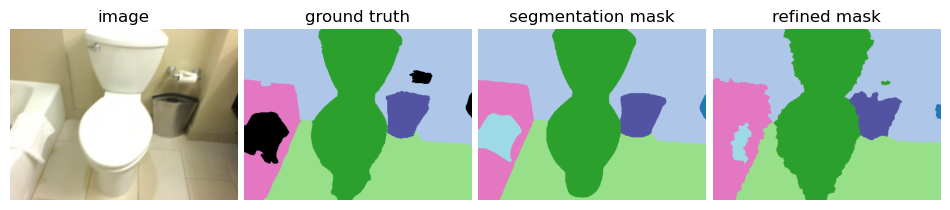

48.png


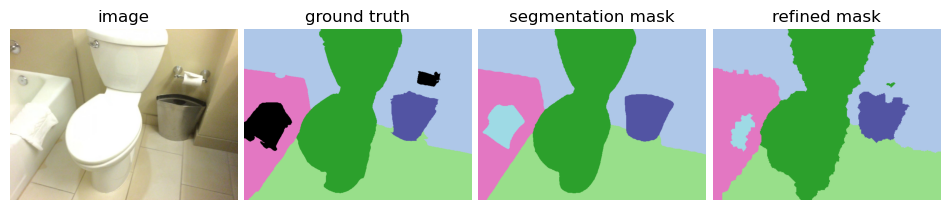

218.png


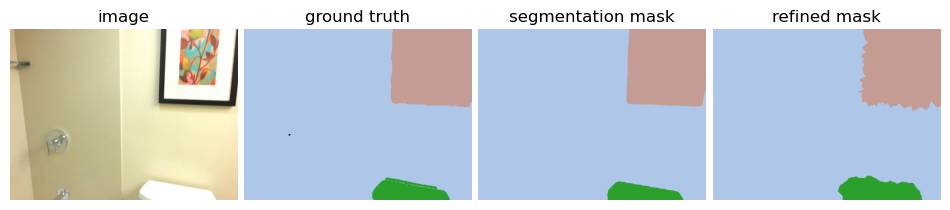

157.png


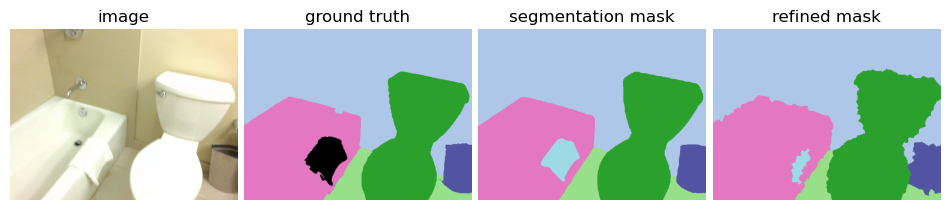

402.png


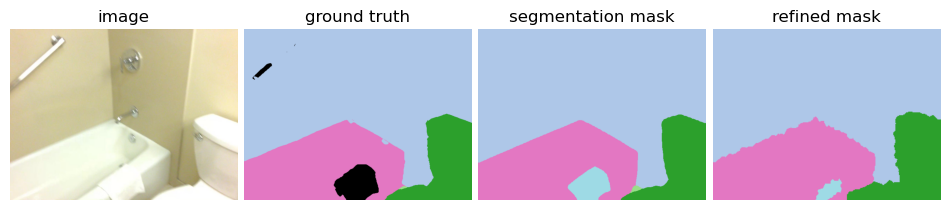

1344.png


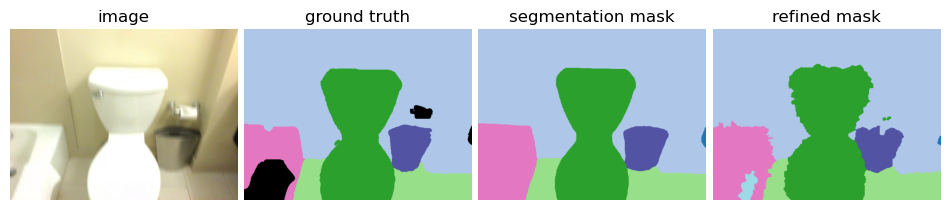

1325.png


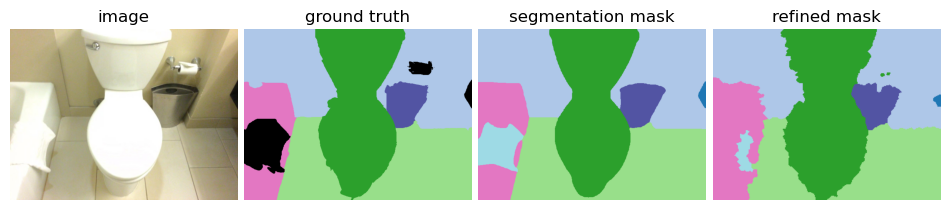

1244.png


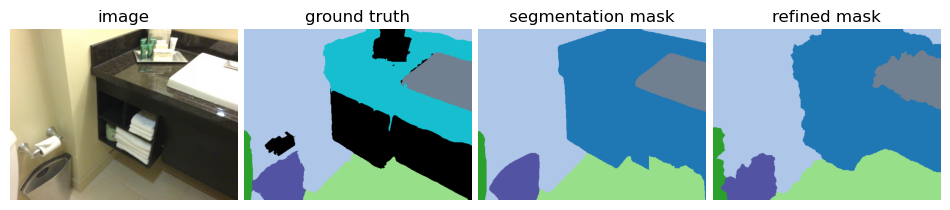

339.png


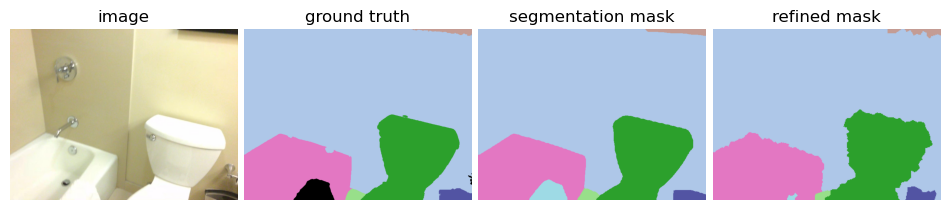

108.png


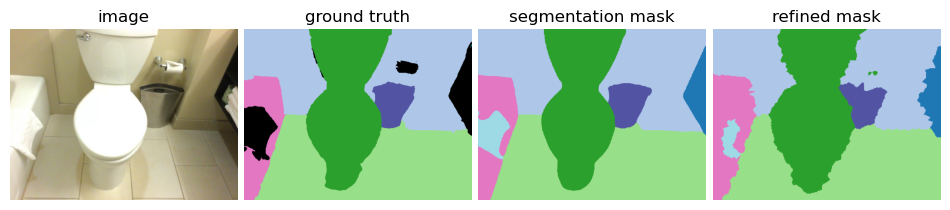

143.png


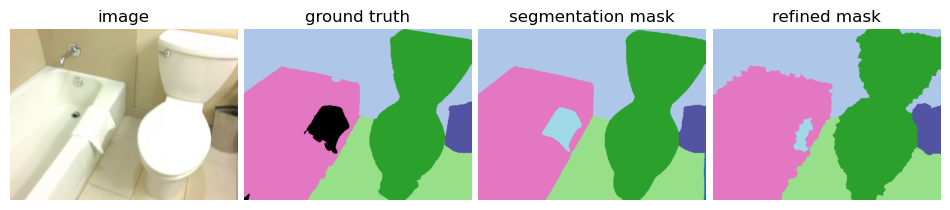

1276.png


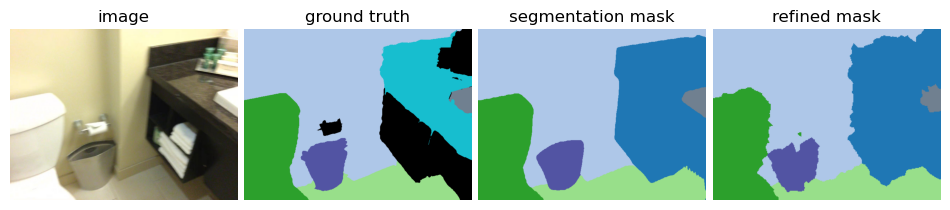

156.png


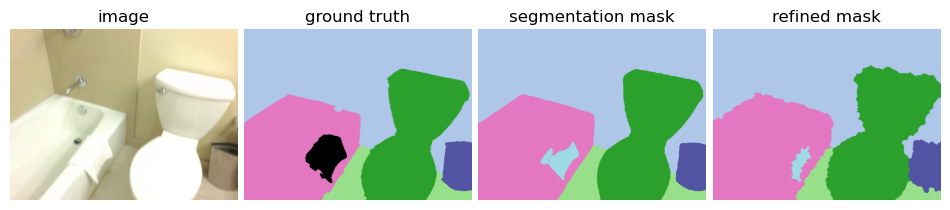

1305.png


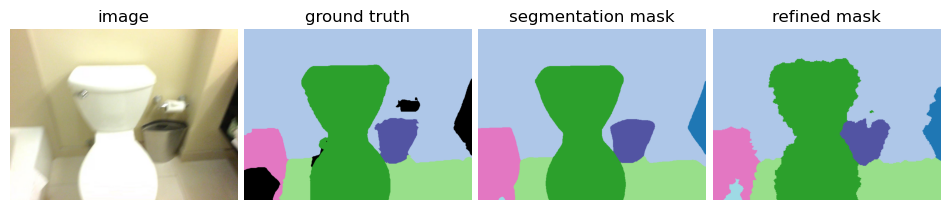

297.png


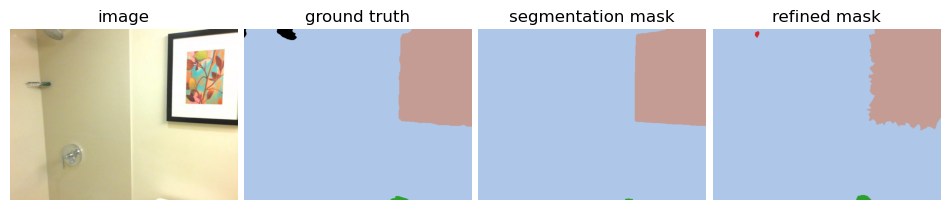

369.png


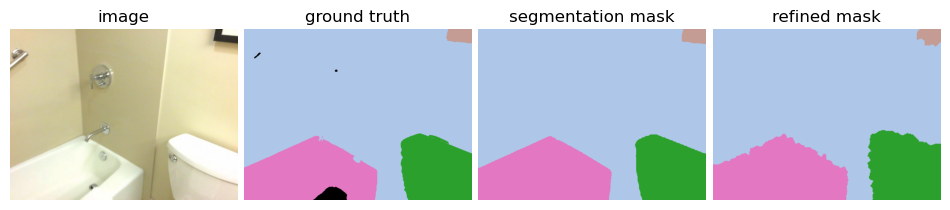

78.png


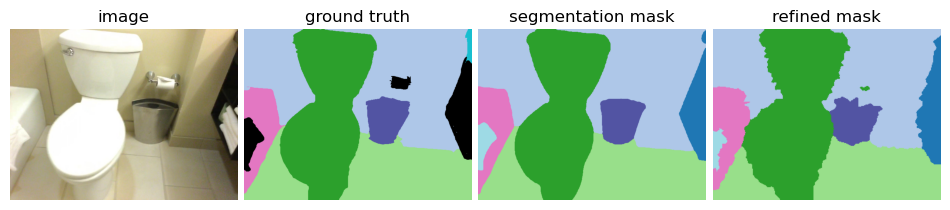

1296.png


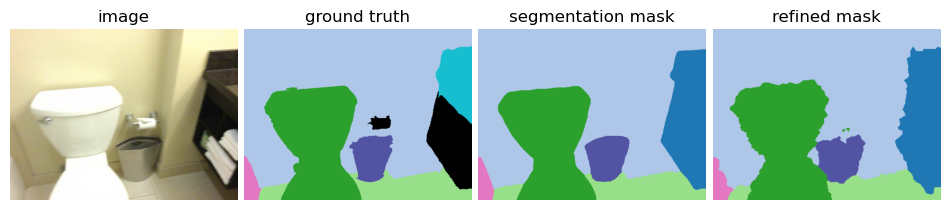

32.png


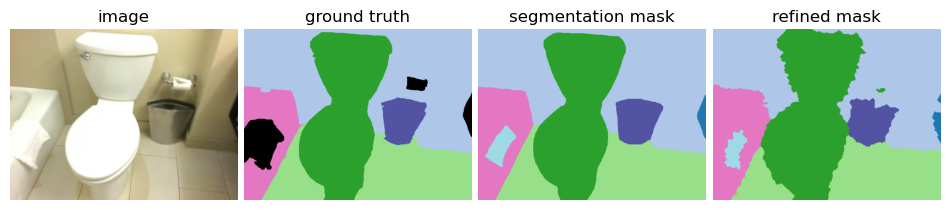

523.png


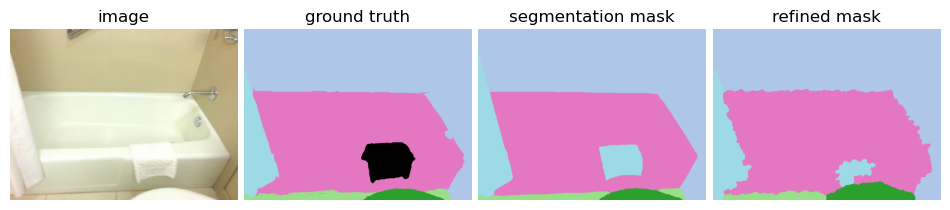

457.png


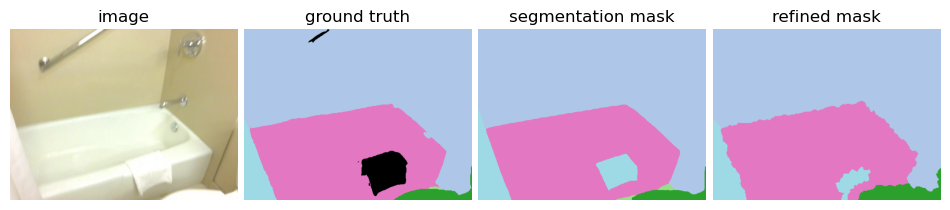

183.png


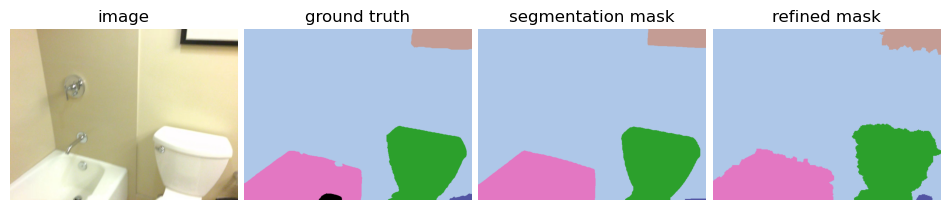

1267.png


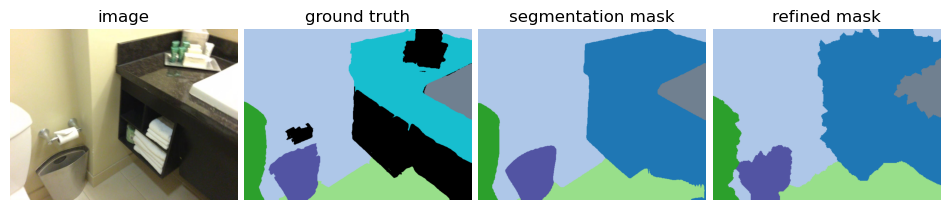

516.png


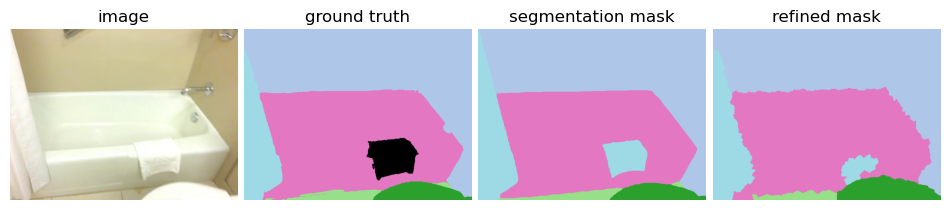

0.png


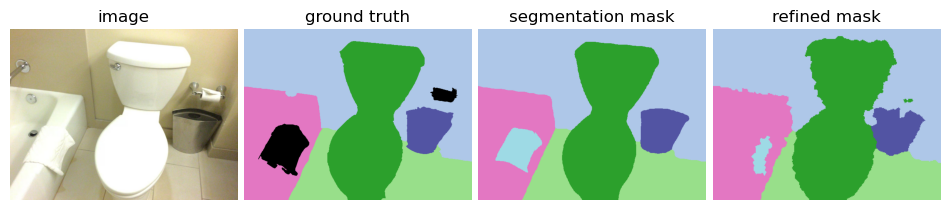

361.png


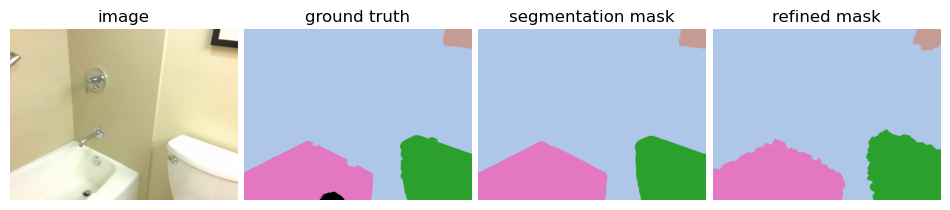

317.png


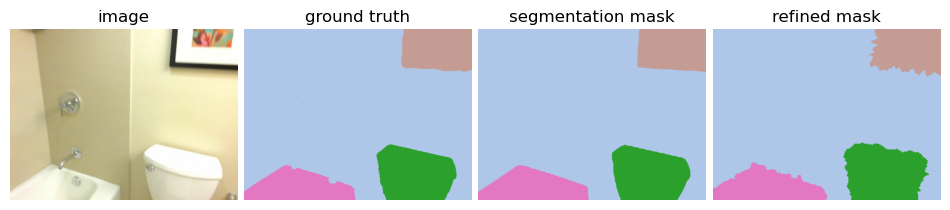

127.png


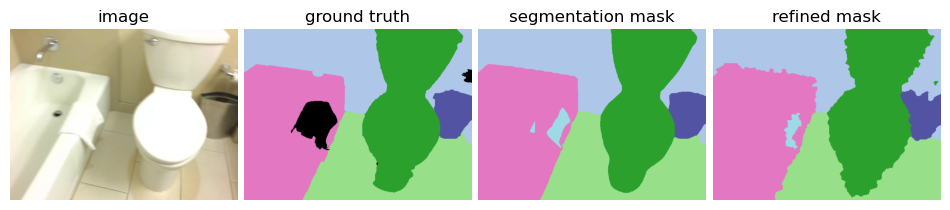

370.png


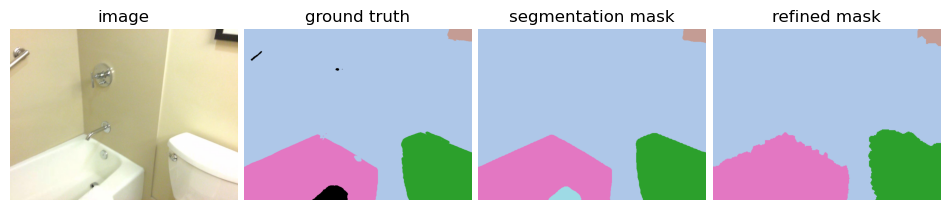

In [63]:
for mask_path in selected_instance.modalities['image'][0].m2f_pred_mask_path:
    visualize_2d(scene_id=mm_data.id_scan.item(), mask_names=[os.path.basename(mask_path)])

In [80]:
def visualize_2d(scene_id, mask_names):
    mapping_idx_to_names = dataset.val_dataset.MAPPING_IDX_TO_SCAN_VAL_NAMES
    scene_id = mapping_idx_to_names[scene_id]

    
    input_mask_dir = "/home/fsun/data/scannet/scans"
    input_mask_name = 'ViT_masks'

    refined_mask_dir = "/scratch-shared/fsun/data/scannet/scans"
    refined_mask_name = 'ViT_masks_refined'

#     mask_names = os.listdir(osp.join(refined_mask_dir, scene_id, refined_mask_name))
#     mask_names = sorted(mask_names, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

#     mask_names = [m for i, m in enumerate(mask_names) if i % 2 == 0]

    for m in mask_names:
        print(m)

        f, axarr = plt.subplots(1, 4, figsize=(12, 8))
        f.subplots_adjust(hspace=0.01, wspace=0.03)

        input_im = Image.open(osp.join(input_mask_dir, scene_id, input_mask_name, m))
        input_im = np.array(input_im) - 1   # label offset
        input_im = np.array(CLASS_COLORS)[input_im].astype(np.uint8)

        refined_im = Image.open(osp.join(refined_mask_dir, scene_id, refined_mask_name, m))
        refined_im = np.array(refined_im)
        refined_im = np.array(CLASS_COLORS)[refined_im].astype(np.uint8)

        gt_im = Image.open(osp.join(refined_mask_dir, scene_id, 'label-filt-scannet20', m))
        gt_im = np.array(gt_im).astype(int) - 1   # label offset
        gt_im = np.array(CLASS_COLORS)[gt_im].astype(np.uint8)

        im = Image.open(osp.join(refined_mask_dir, scene_id, 'color_resized', m))

        axarr[0].set_title("image")
        axarr[1].set_title("ground truth")
        axarr[2].set_title("segmentation mask")
        axarr[3].set_title("refined mask")

        axarr[0].imshow(im) 
        axarr[1].imshow(gt_im) 
        axarr[2].imshow(input_im)
        axarr[3].imshow(refined_im) 

        for x in axarr:
            x.axis('off')
        plt.show()

In [55]:
# Visualize refined masks on 0.01 voxel size
from torch_points3d.utils.multimodal import lexargsort
from torch_points3d.core.multimodal.csr import CSRData
import scipy.ndimage
from PIL import Image
import numpy as np

def visualize_2d_upscaled(model, mm_data, contains_pred=False, save_output=False):
    """ Track 2D scores for input semantic segmentation masks and output Multi-View Fusion refined 2D masks using simple nearest-neighbor interpolation and projected 3D point predictions.
    """
    if contains_pred == False:
        mm_data.data.pred = model.output.detach().cpu().argmax(1)

    mappings = mm_data.modalities['image'][0].mappings
    point_ids = torch.arange(
                    mappings.num_groups, device=mappings.device).repeat_interleave(
                    mappings.pointers[1:] - mappings.pointers[:-1])
    image_ids = mappings.images.repeat_interleave(
                    mappings.values[1].pointers[1:] - mappings.values[1].pointers[:-1])    
    pixels_full = mappings.pixels

    # Sort point and image ids based on image_id
    idx_sort = lexargsort(image_ids, point_ids)
    image_ids = image_ids[idx_sort]
    point_ids = point_ids[idx_sort]
    pixels_full = pixels_full[idx_sort].long()

    # Get pointers for easy indexing
    pointers = CSRData._sorted_indices_to_pointers(image_ids)

    # Save refined masks
    im_paths = mm_data.modalities['image'][0].gt_mask_path
    scan_dir = os.sep.join(im_paths[0].split(os.sep)[:-2])
    input_mask_name = mm_data.modalities['image'][0].m2f_pred_mask_path[0].split(os.sep)[-2]

    # Dirty workaround for masks in different directory
    if input_mask_name == 'ViT_masks':
        scan_id = scan_dir.split(os.sep)[-1]
        mask_im_dir = osp.join("/home/fsun/data/scannet/scans", scan_id, input_mask_name)
        refined_mask_im_dir = osp.join(scan_dir, input_mask_name + '_refined')
    else:
        mask_im_dir = osp.join(scan_dir, input_mask_name)
        refined_mask_im_dir = osp.join(scan_dir, input_mask_name + '_refined')

    if save_output:
        print("Creating refined mask dir at ", refined_mask_im_dir)
        os.makedirs(refined_mask_im_dir, exist_ok=True)

    # Loop over all N views
    for i, x in enumerate(mm_data.modalities['image'][0]):

        # Grab the 3D points corresponding to ith view
        start, end = pointers[i], pointers[i+1]    
        points = point_ids[start:end]
        pixels = pixels_full[start:end]
        # Image (x, y) pixel index
        w, h = pixels[:, 0], pixels[:, 1]

        # Grab set of points visible in current view
        mm_data_of_view = mm_data[points]

        im_ref_w, im_ref_h = x.ref_size

        # Get nearest neighbor interpolated projection image filled with 3D labels
        pred_mask_2d = -1 * torch.ones((im_ref_h, im_ref_w), dtype=torch.long, device=mm_data_of_view.device)    
        pred_mask_2d[h, w] = mm_data_of_view.data.pred.squeeze()

        nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
            pred_mask_2d==-1, return_distances=False, return_indices=True)    
        pred_mask_2d = pred_mask_2d[nearest_neighbor].numpy().astype(np.uint8)
        pred_mask_2d = Image.fromarray(pred_mask_2d, 'L')          

        # SAVE REFINED MASK IN GIVEN DIR
        im_name = x.m2f_pred_mask_path[0].split("/")[-1]

        pred_mask_2d = pred_mask_2d.resize((640, 480), resample=0)

        if save_output:
            pred_mask_2d.save(osp.join(refined_mask_im_dir, im_name))

        pred_mask_2d = np.asarray(pred_mask_2d)

        # 2D mIoU calculation for M2F labels per view
        # Get gt 2d image
        gt_img_path = x.m2f_pred_mask_path[0].split("/")
        # Adjust filepath after Snellius migration
        gt_img_path[1] = 'scratch-shared'
        gt_img_path[-2] = 'label-filt-scannet20'
        gt_img_path = "/".join(gt_img_path)
        gt_img = Image.open(gt_img_path)

        gt_img = np.asarray(gt_img.resize((640, 480), resample=0)).astype(int) - 1   # -1 label offset

        # Input mask and refined mask for current view
        refined_im = pred_mask_2d
        gt_im = gt_img



        f, axarr = plt.subplots(1, 2, figsize=(12, 8))
        f.subplots_adjust(hspace=0.01, wspace=0.03)

#         input_im = Image.open(osp.join(input_mask_dir, scene_id, input_mask_name, m))
#         input_im = np.array(input_im) - 1   # label offset
#         input_im = np.array(CLASS_COLORS)[input_im].astype(np.uint8)

#         refined_im = Image.open(osp.join(refined_mask_dir, scene_id, refined_mask_name, m))
#         refined_im = np.array(refined_im)
        refined_im = np.array(CLASS_COLORS)[refined_im].astype(np.uint8)

#         gt_im = Image.open(osp.join(refined_mask_dir, scene_id, 'label-filt-scannet20', m))
#         gt_im = np.array(gt_im).astype(int) - 1   # label offset
        gt_im = np.array(CLASS_COLORS)[gt_im].astype(np.uint8)

#         im = Image.open(osp.join(refined_mask_dir, scene_id, 'color_resized', m))

        axarr[0].set_title("ground truth")
        axarr[1].set_title("refined mask")
#         axarr[2].set_title("segmentation mask")
#         axarr[3].set_title("refined mask")

        axarr[0].imshow(gt_im) 
        axarr[1].imshow(refined_im) 
#         axarr[2].imshow(input_im)
#         axarr[3].imshow(refined_im) 

        for x in axarr:
            x.axis('off')
        plt.show()

In [56]:
mm_data

MMData(
    data = Data(coords=[19851, 3], grid_size=[1], id_scan=[1], instance_labels=[19851], mapping_index=[19851], mvfusion_input=[15033, 6, 10], origin_id=[19851], pos=[19851, 3], pred=[19851], rgb=[19851, 3], x=[19851, 3], y=[19851])
    image = ImageData(num_settings=1, num_views=54, num_points=19851, device=cpu)
)

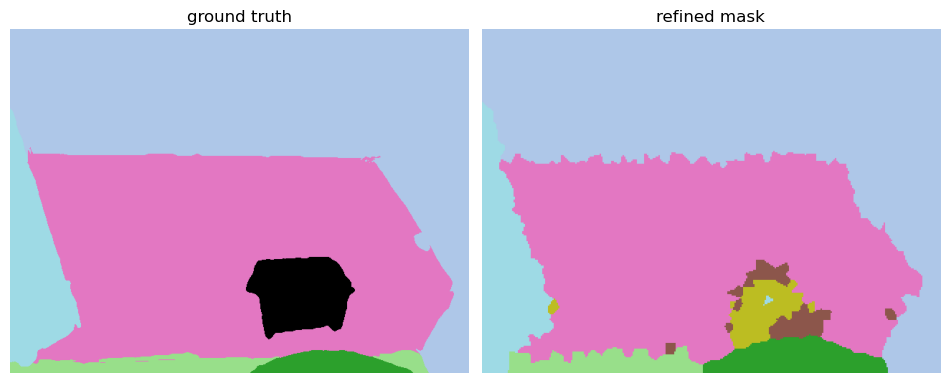

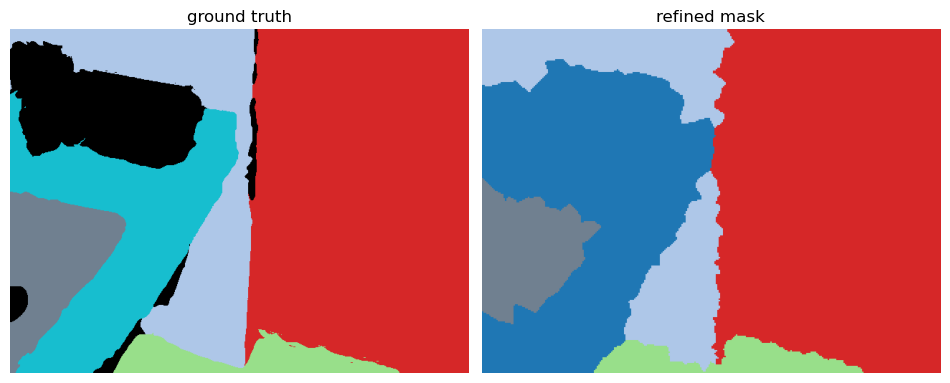

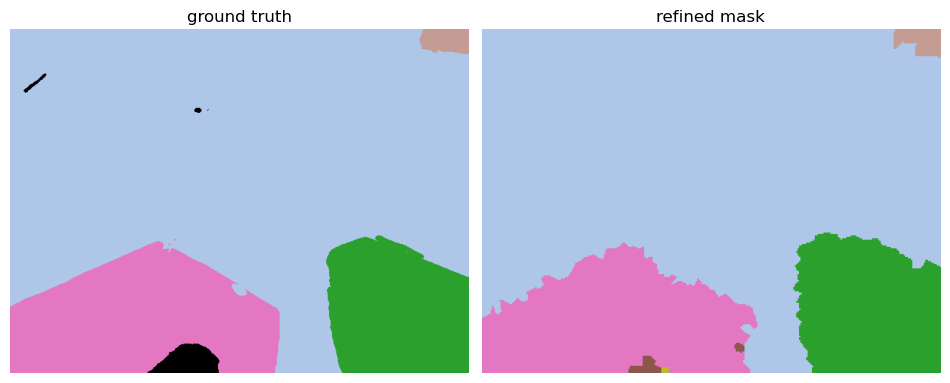

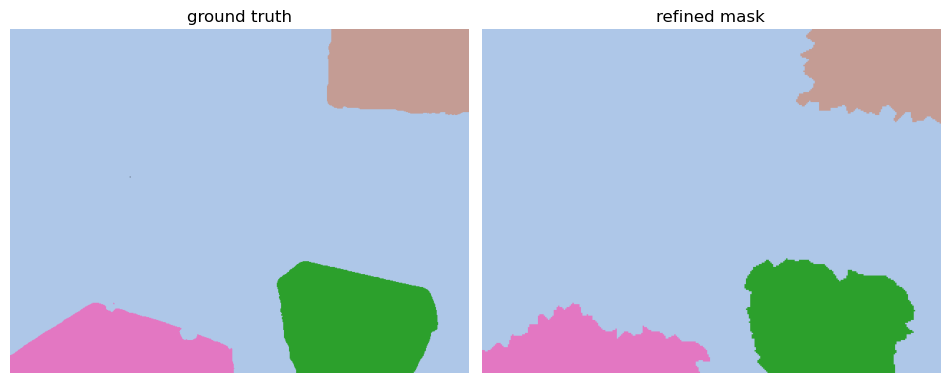

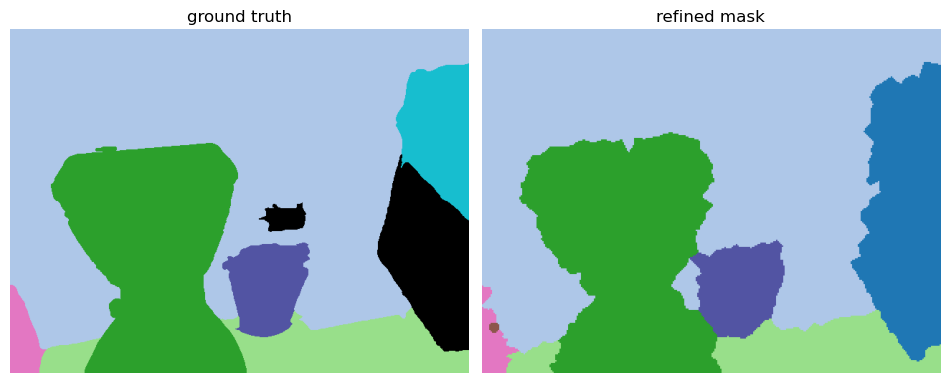

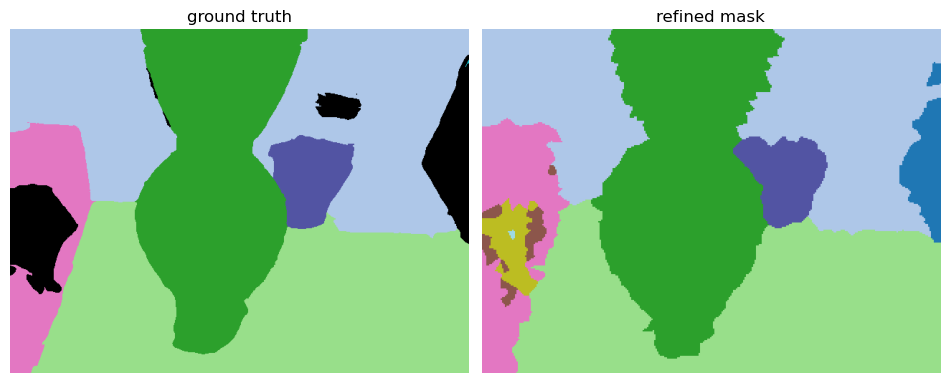

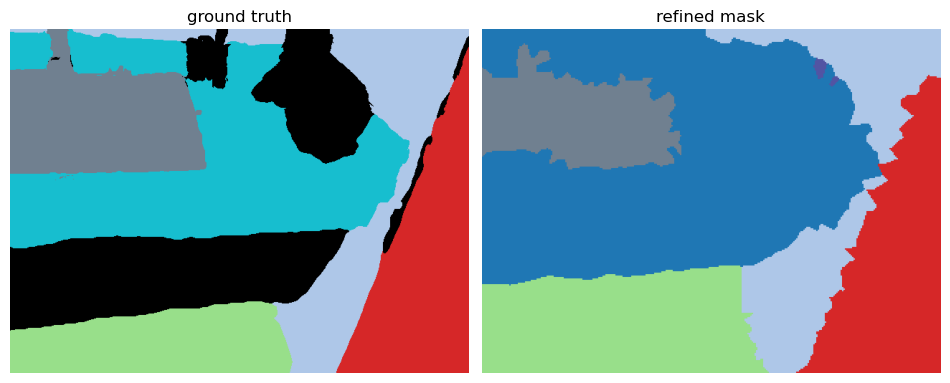

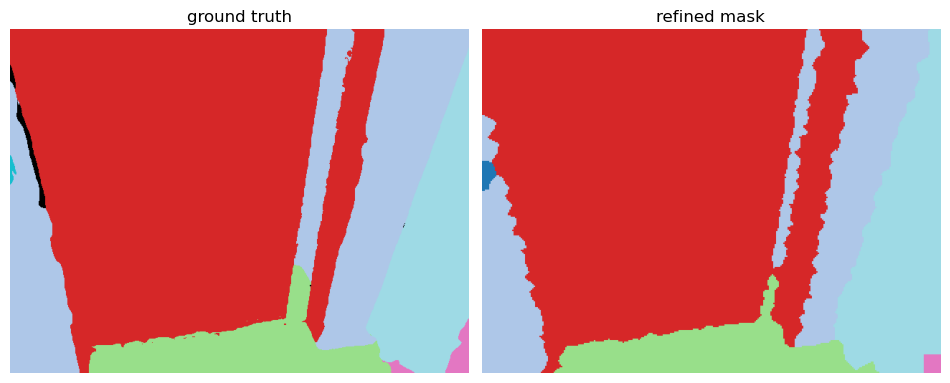

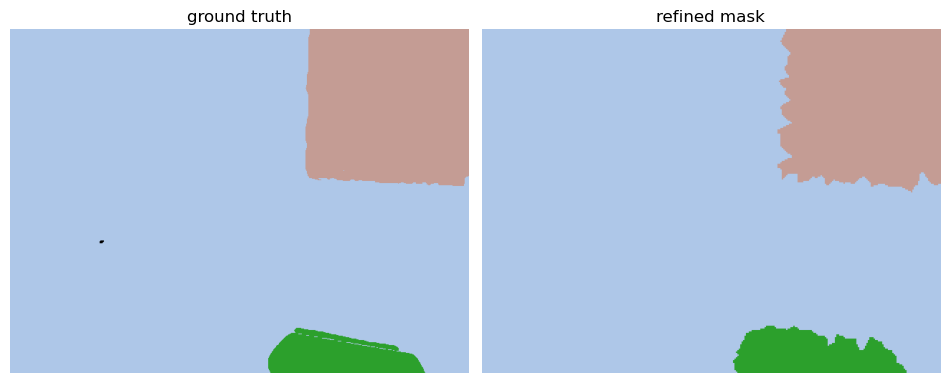

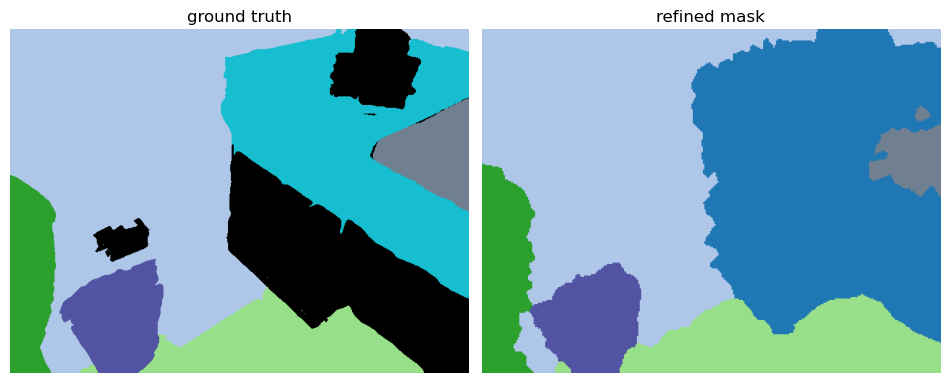

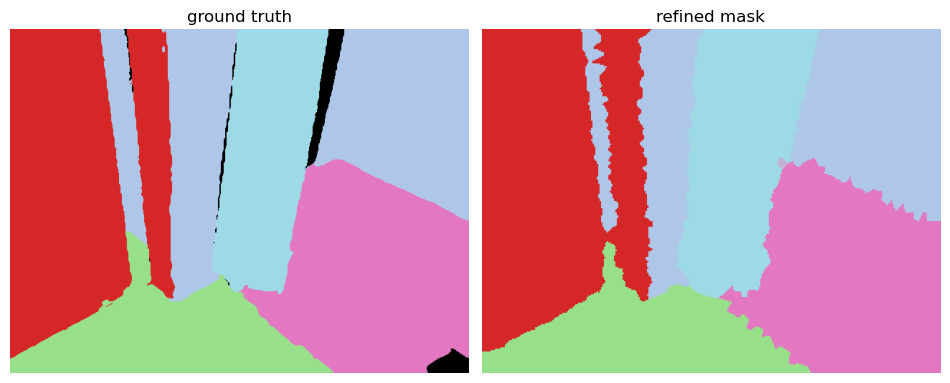

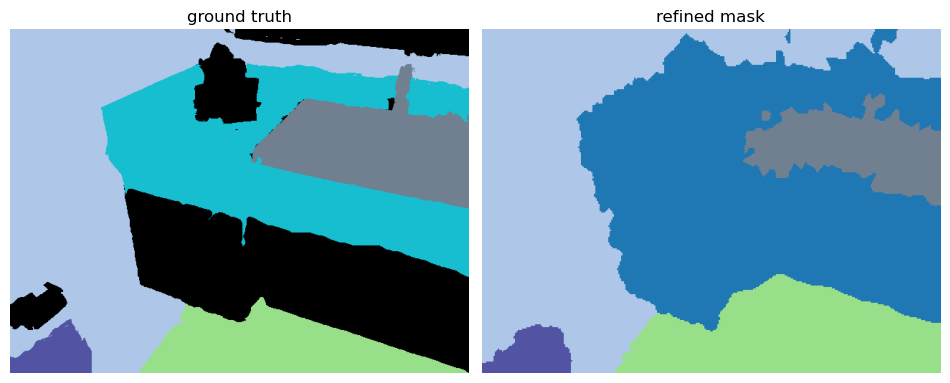

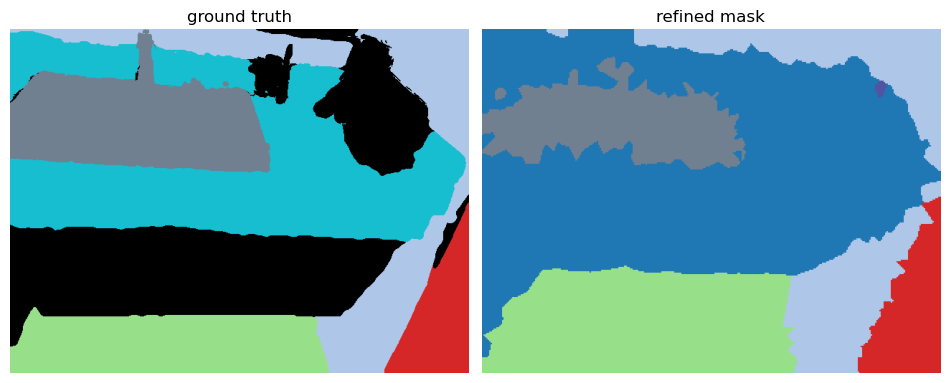

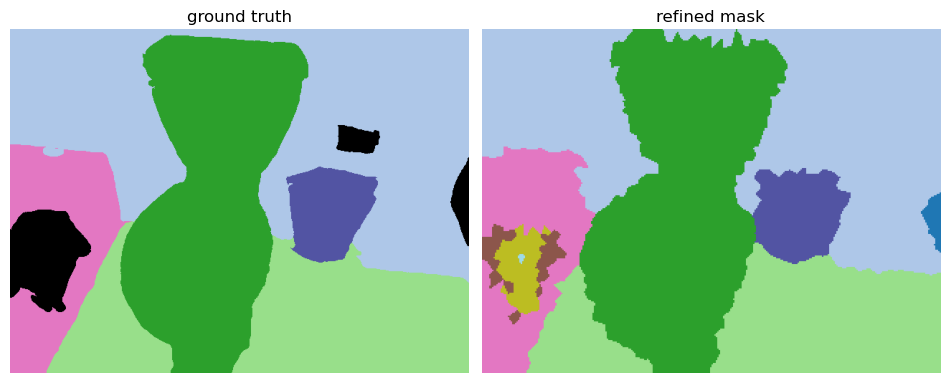

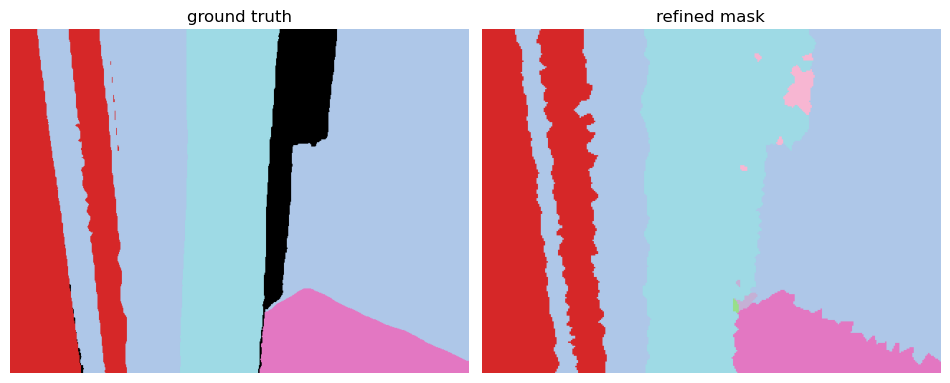

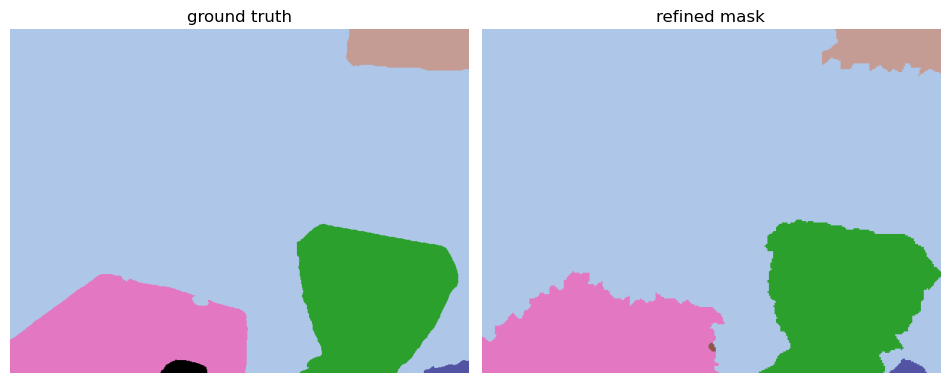

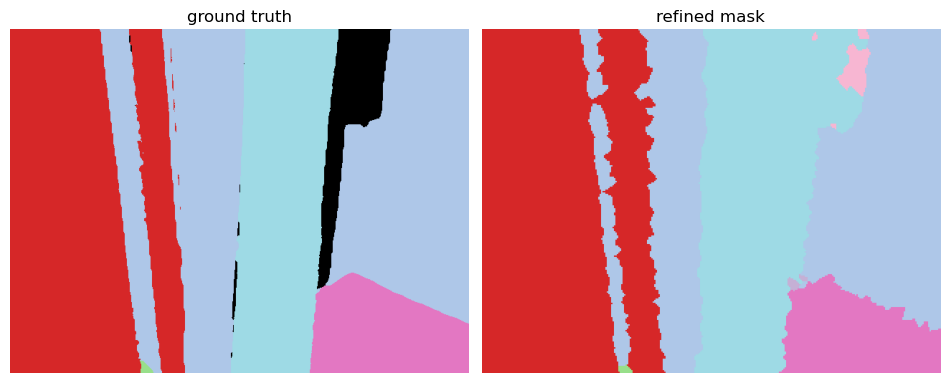

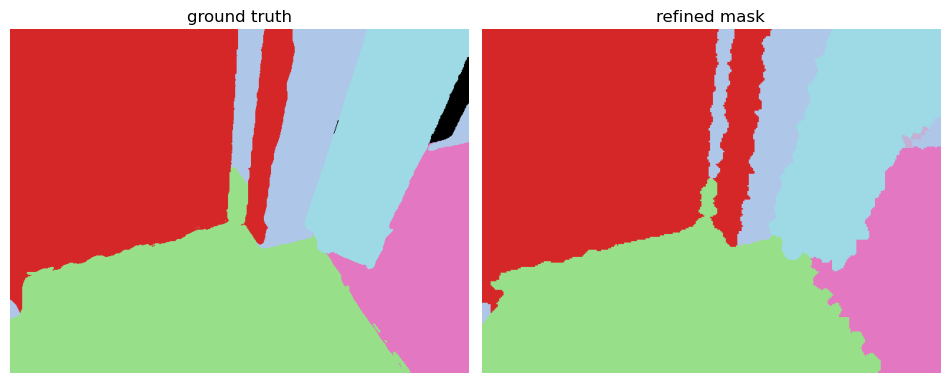

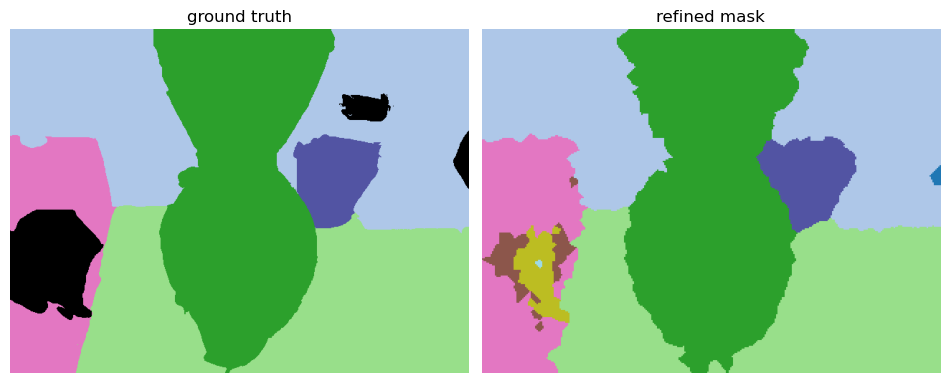

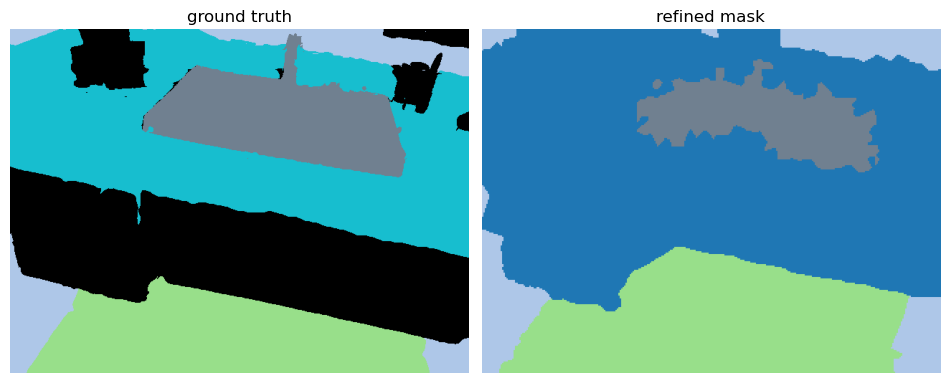

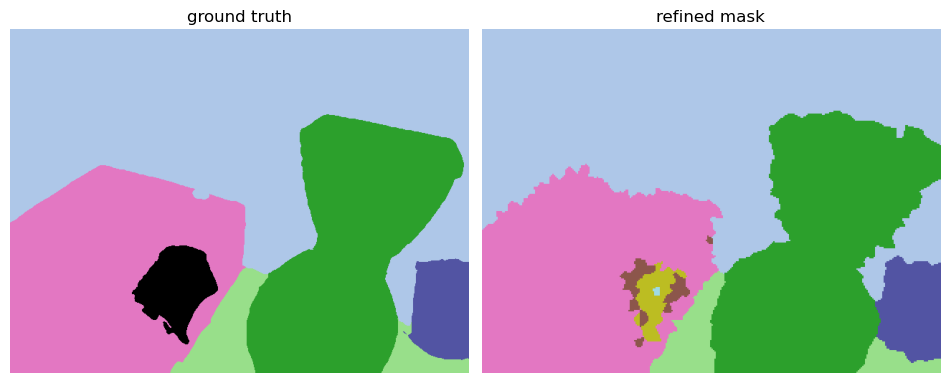

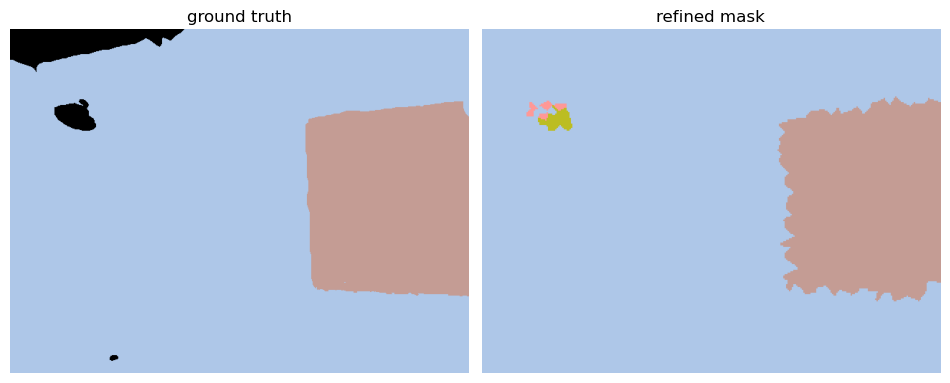

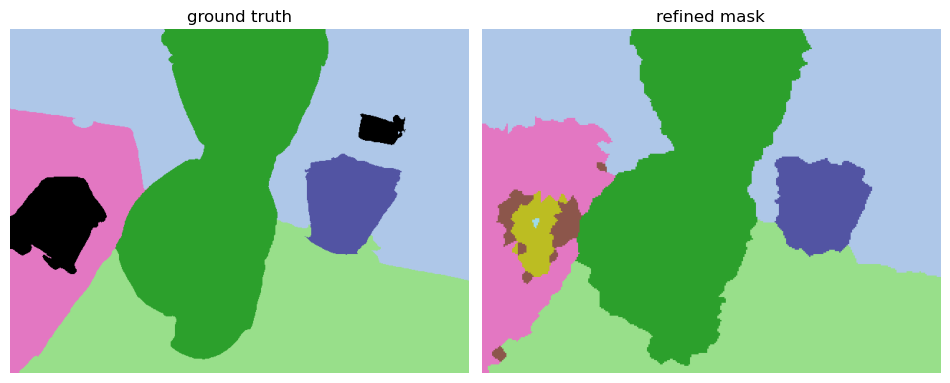

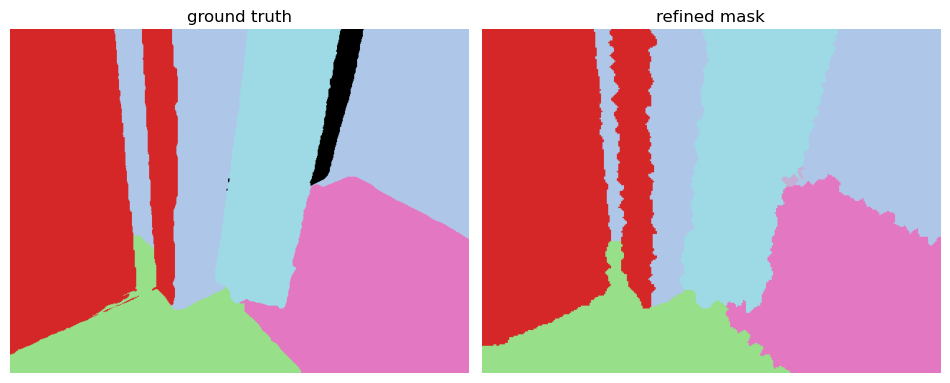

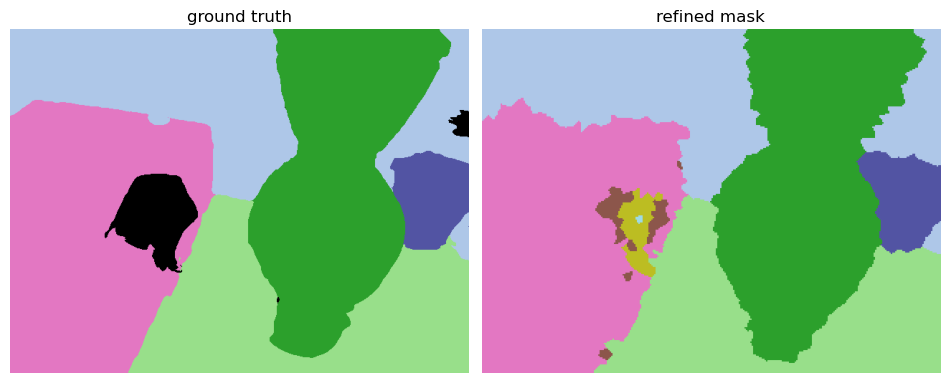

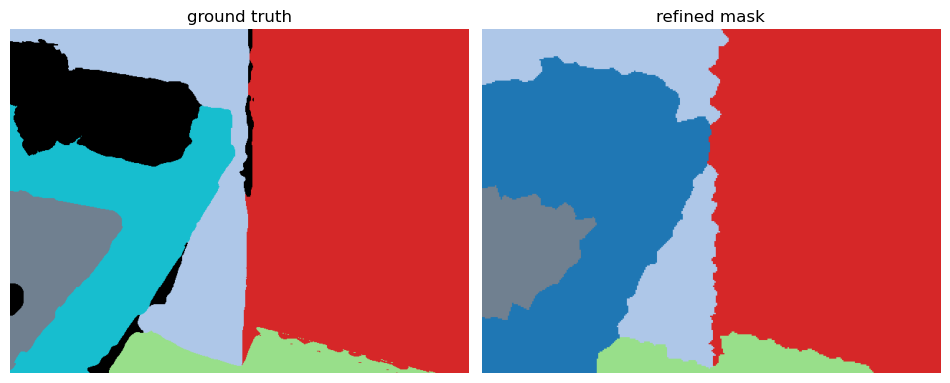

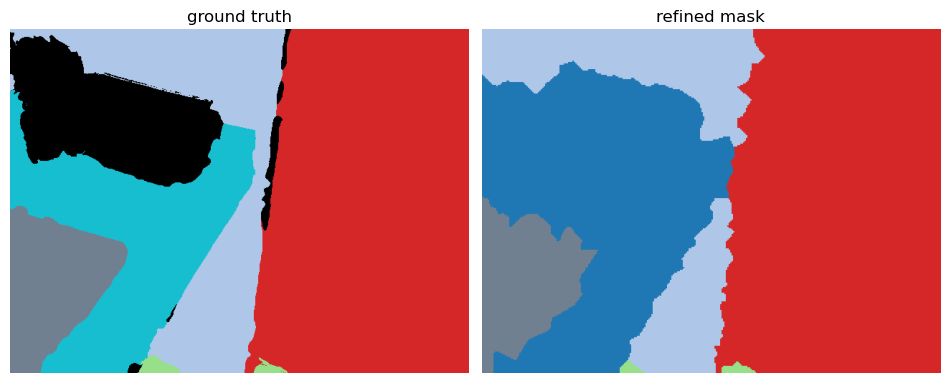

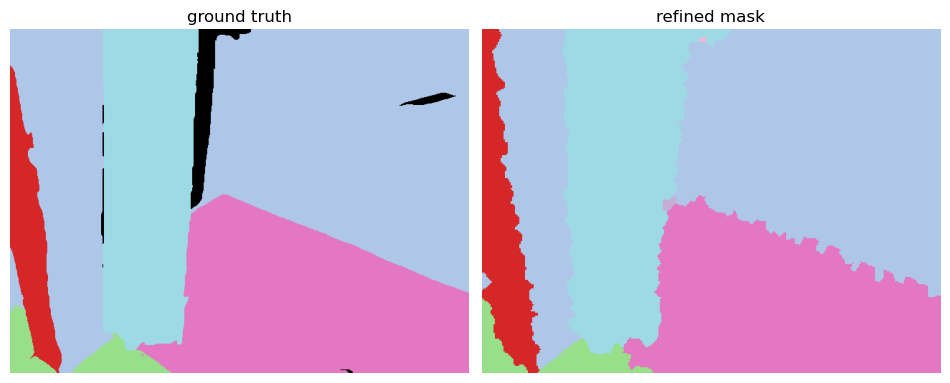

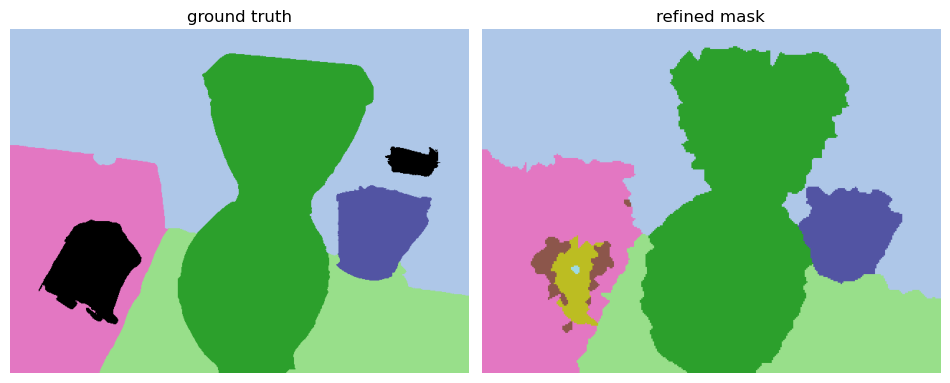

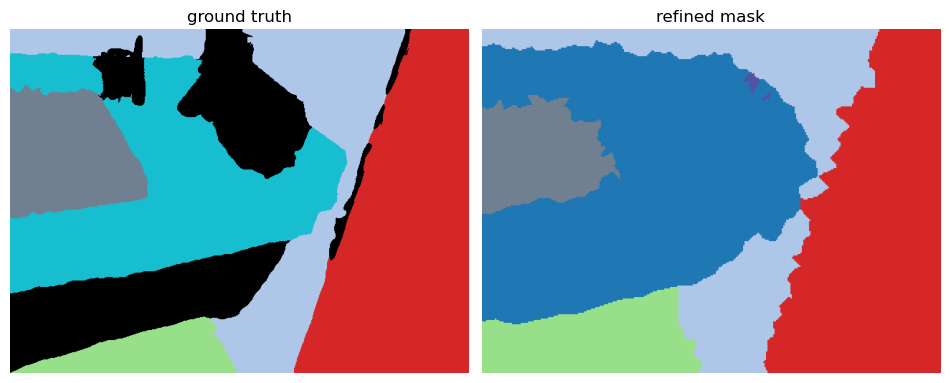

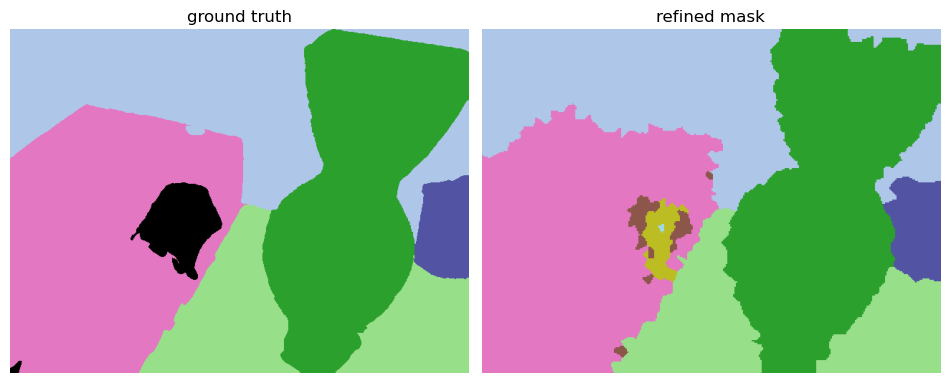

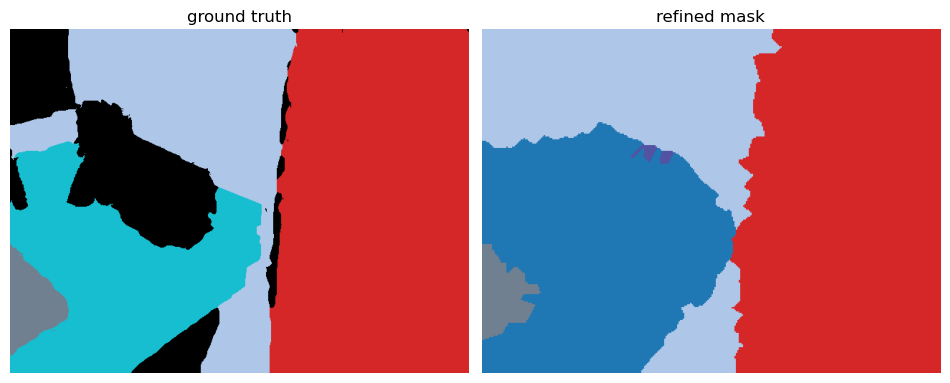

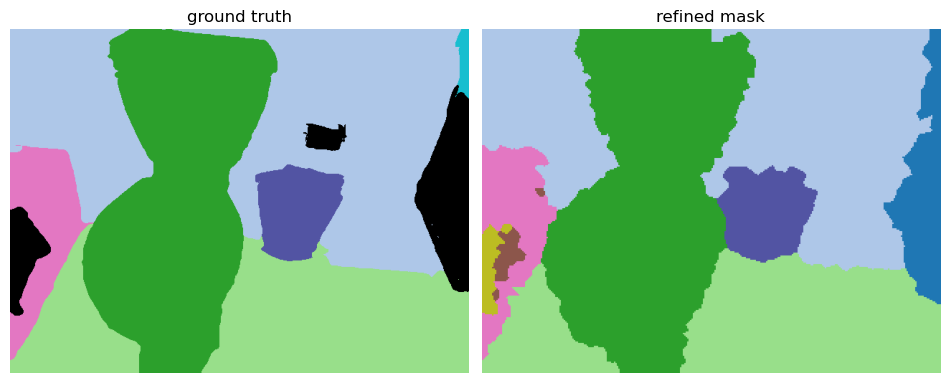

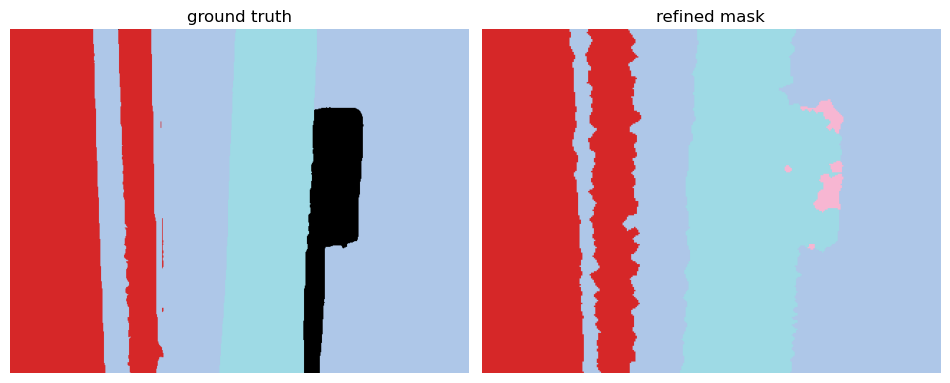

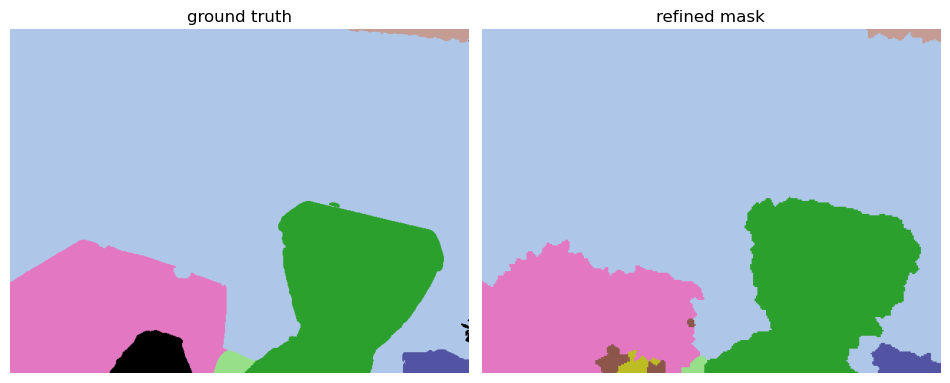

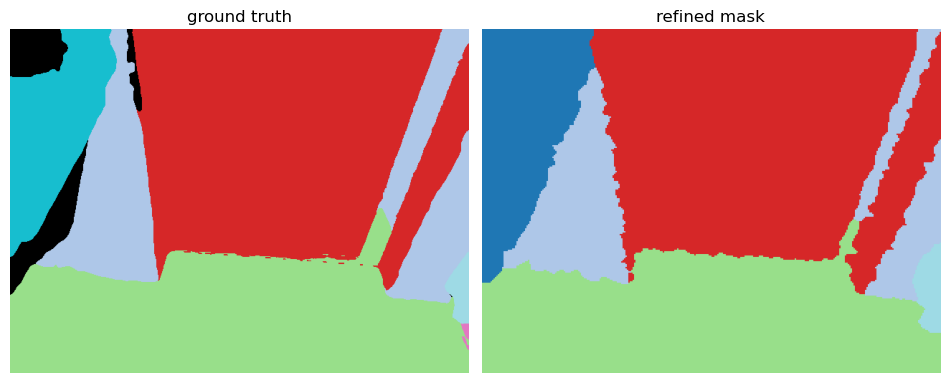

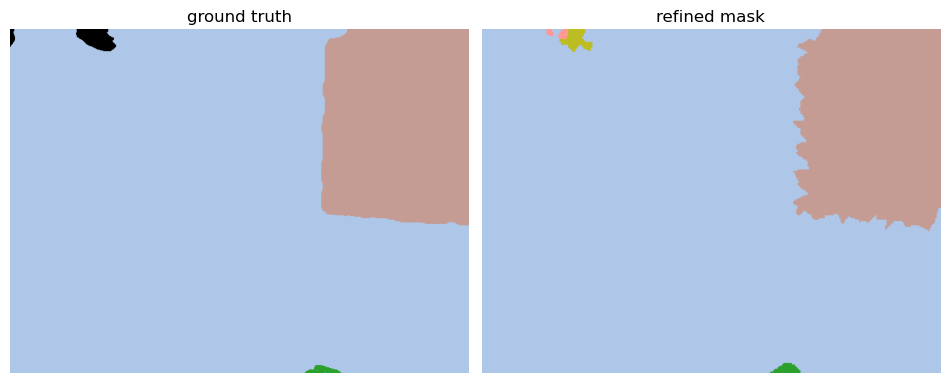

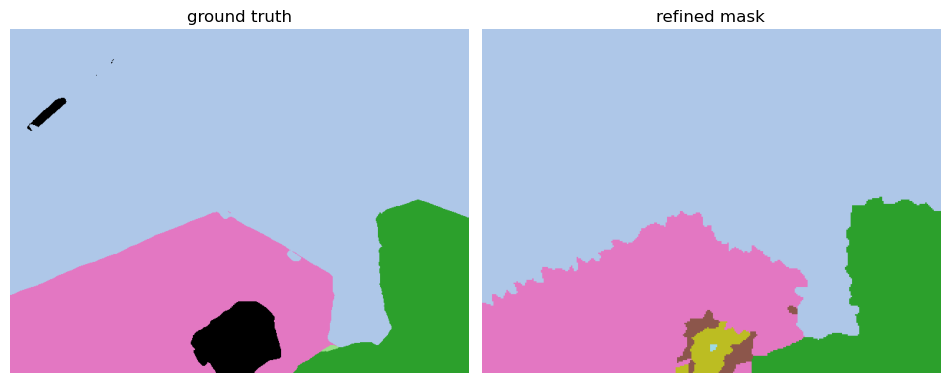

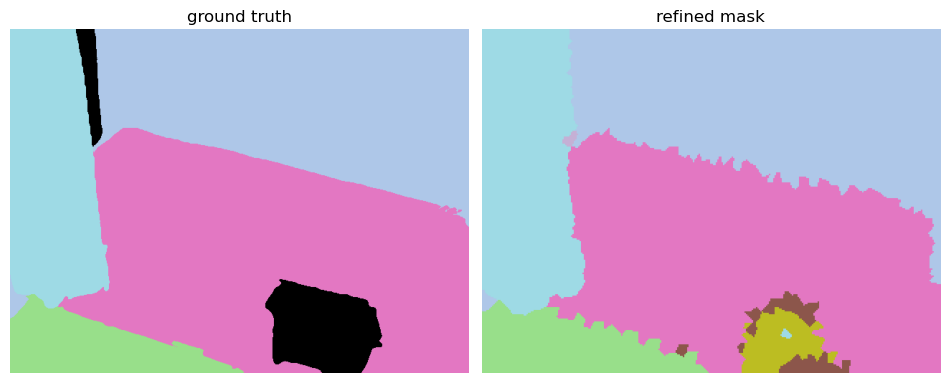

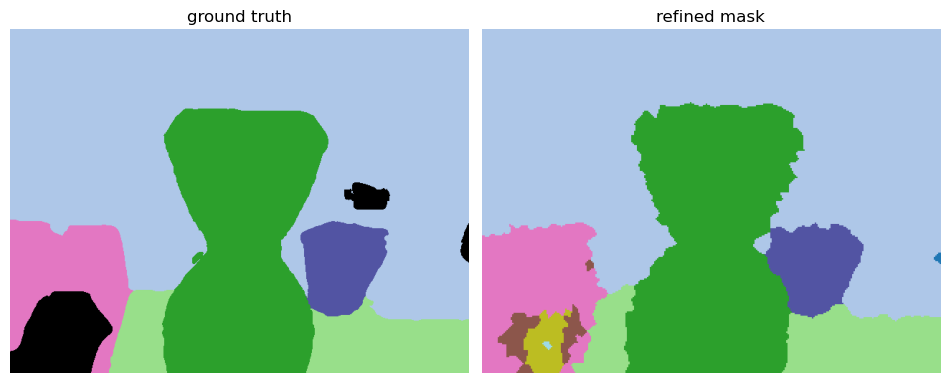

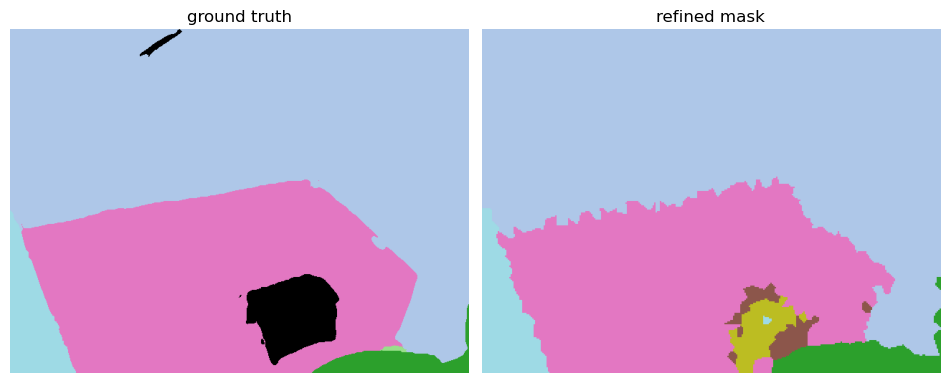

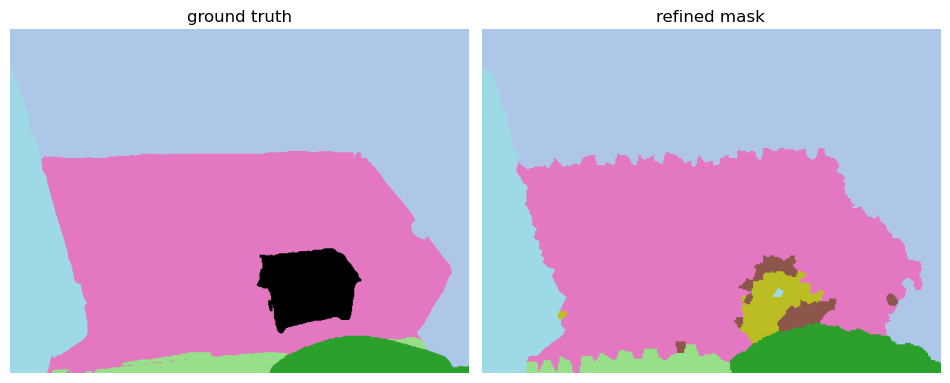

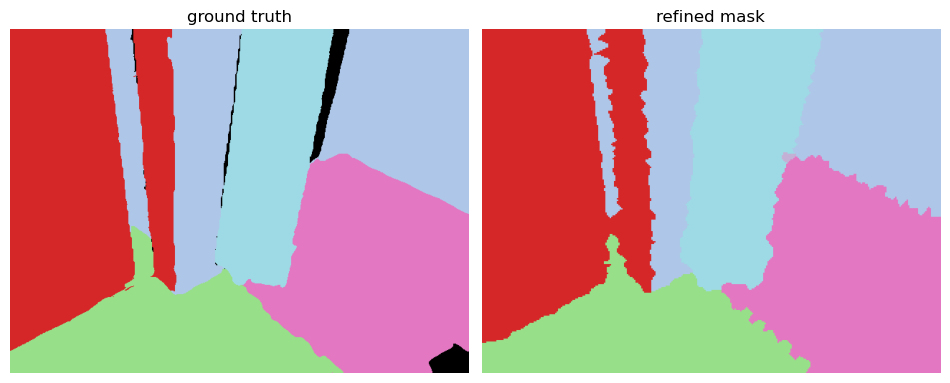

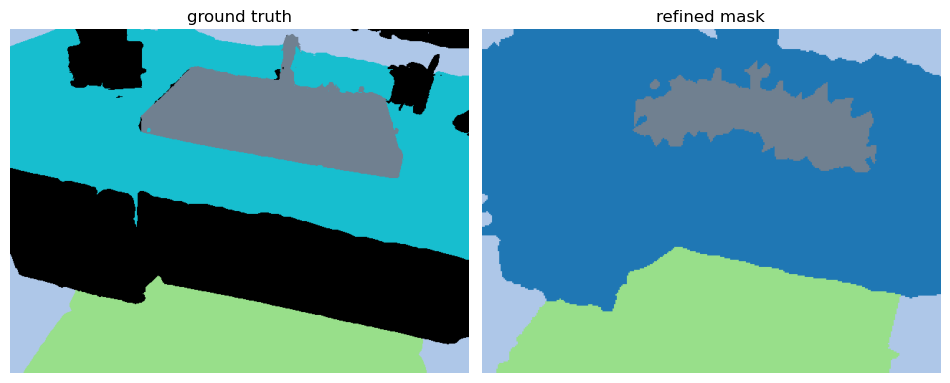

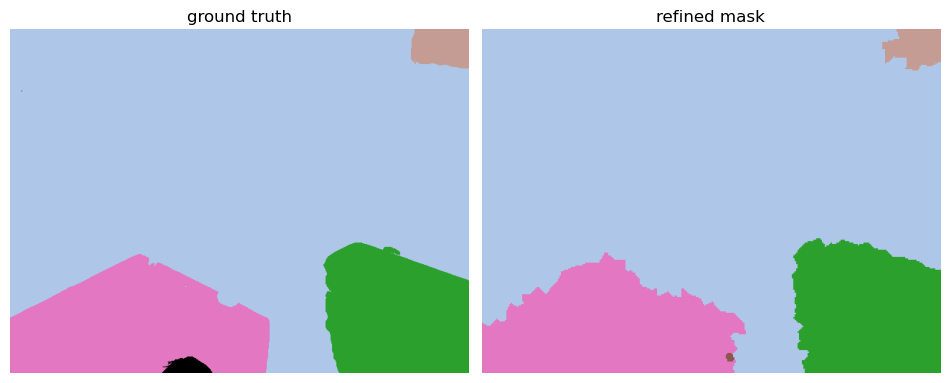

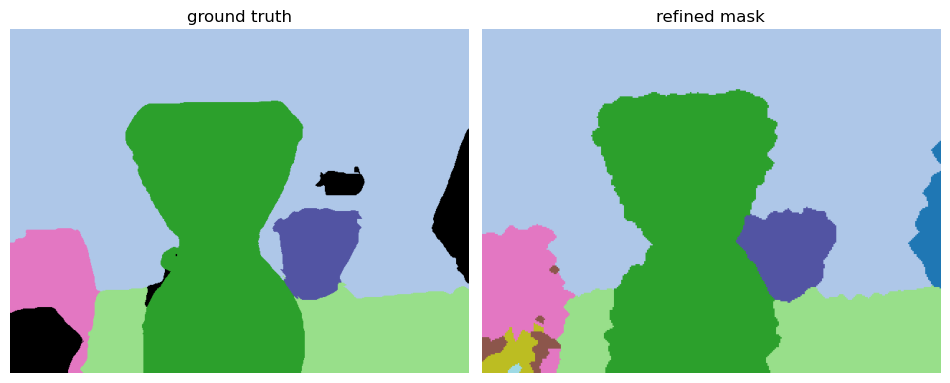

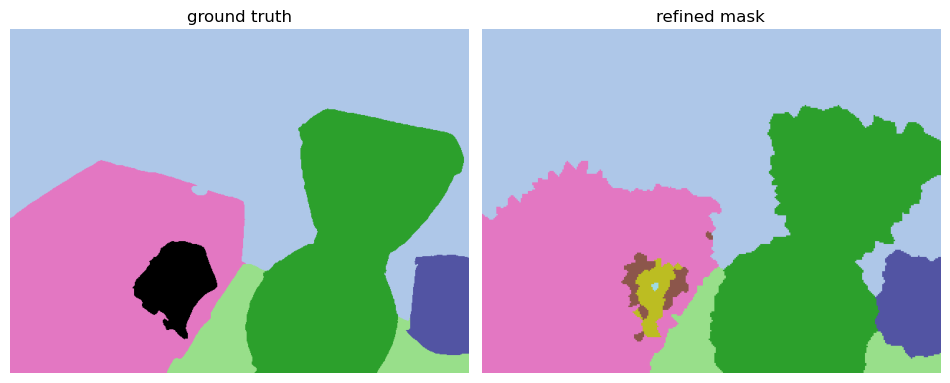

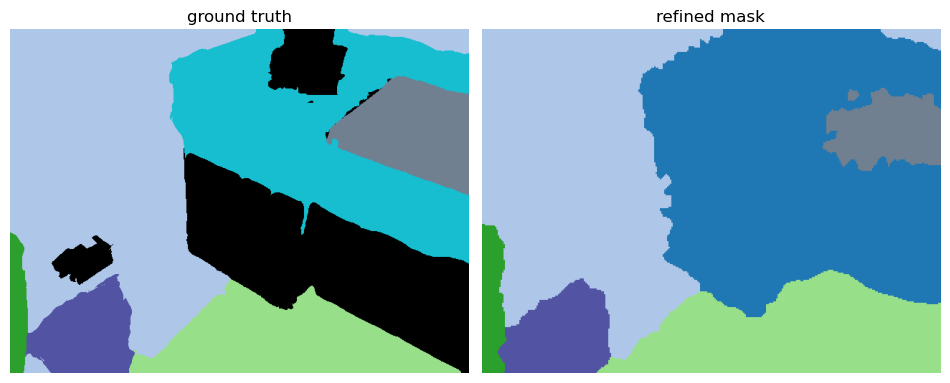

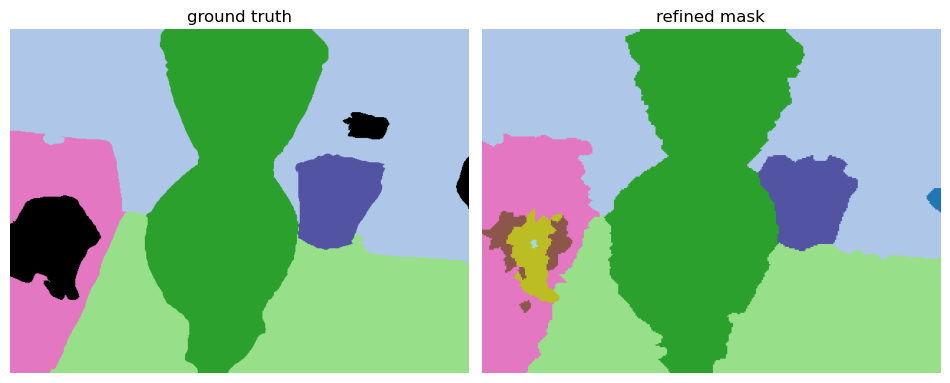

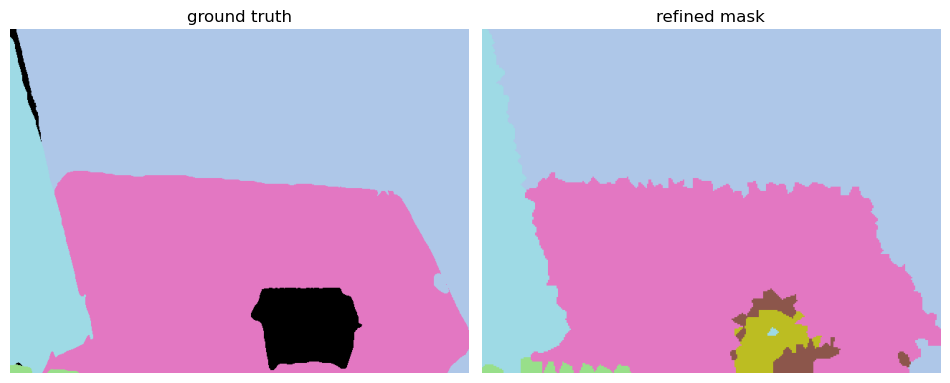

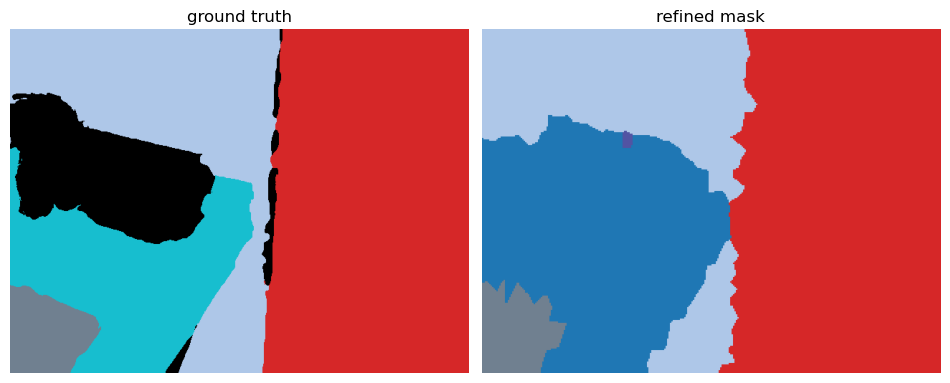

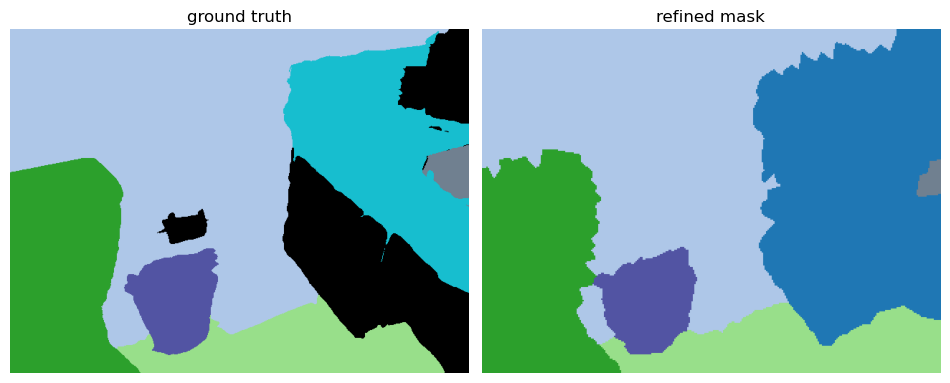

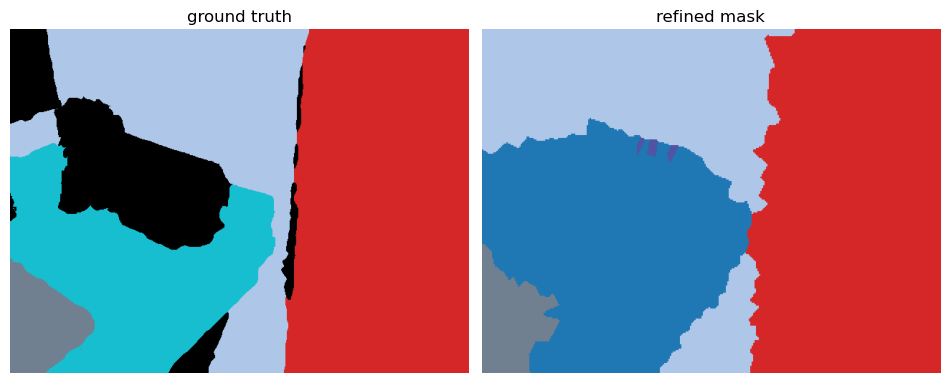

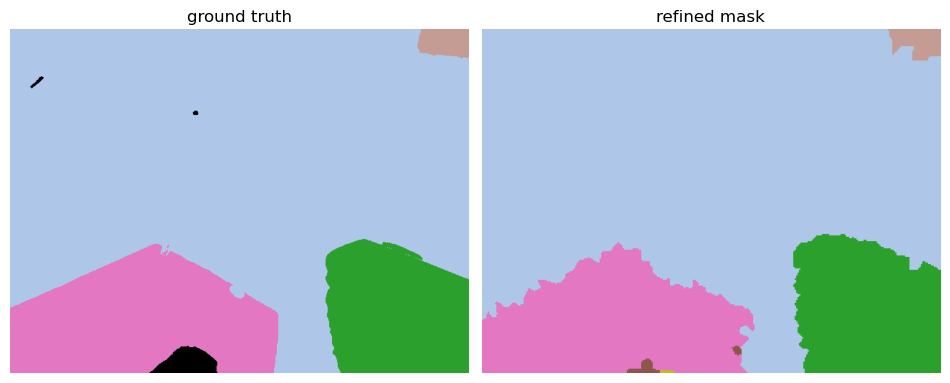

In [57]:
visualize_2d_upscaled(model, mm_data, contains_pred=True, save_output=False)

### Below is an example to visualize refined masks back-projected at full resolution

In [106]:
tracker = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker.reset(stage='val')

# Get prediction at small resolution
print("current scan: ", mm_data.id_scan.item())
batch = MMBatch.from_mm_data_list([mm_data])
with torch.no_grad():
    model.set_input(batch, model.device)
    model(batch)

mm_data.data.pred = model.output.detach().cpu().argmax(1)

current scan:  264


In [109]:
# Interpolate predictions to full resolution
s = time()
# tracker.track(model, full_res=True, data=batch)
# tracker.finalise(full_res=True, make_submission=True)

def _make_submission(tracker):
    orginal_class_ids = np.asarray(tracker._dataset.train_dataset.valid_class_idx)
    path_to_submission = tracker._dataset.path_to_submission
    
    for scan_id in tracker._full_preds:
        full_pred = tracker._full_preds[scan_id].cpu().numpy().astype(np.int8)
        full_pred = orginal_class_ids[full_pred]  # remap labels to original labels between 0 and 40
        scan_name = tracker._raw_datas[scan_id].scan_name
        path_file = osp.join(path_to_submission, "{}.txt".format(scan_name))
        
        np.savetxt(path_file, full_pred, delimiter="/n", fmt="%d")

_make_submission(tracker)

time() - s

0.05350613594055176

In [152]:
idx = 264

# Get pre-processed full 3d sample
data = dataset.val_dataset.get(idx)

scan_name = mapping_idx_to_scan_names[idx]   
images = torch.load(osp.join(
    dataset.val_dataset.processed_2d_paths[1], scan_name + '.pt'))

# add missing attribute placeholders
images.gt_mask = None
images.gt_mask_path = None

images = ImageData([images])


# Set upscaled predictions
mm_data_fullres = MMData(data, image=images)
mm_data_fullres.data.pred = list(tracker._full_preds.values())[0]

In [153]:
mm_data_fullres.modalities['image'][0].m2f_pred_mask_path

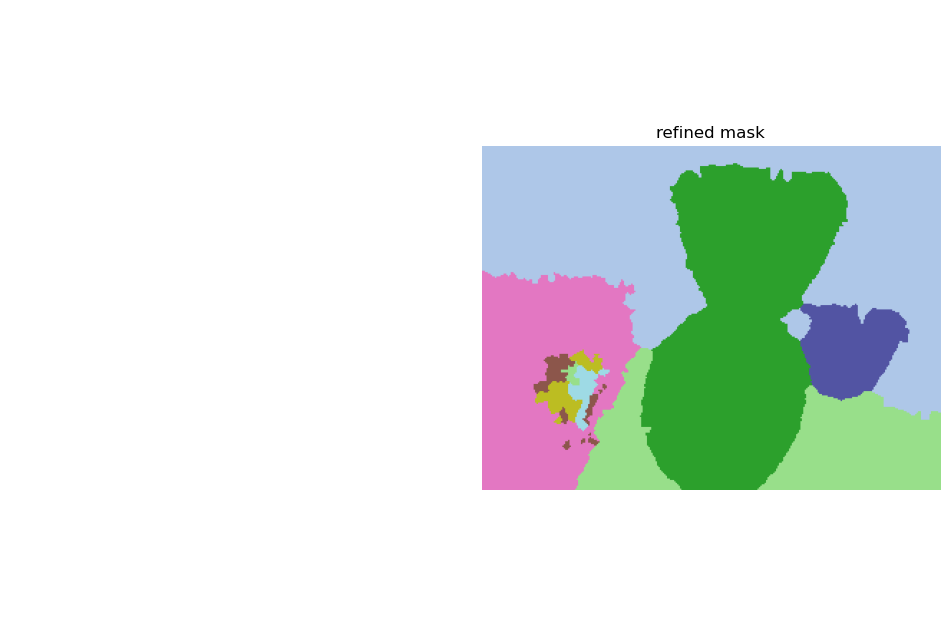

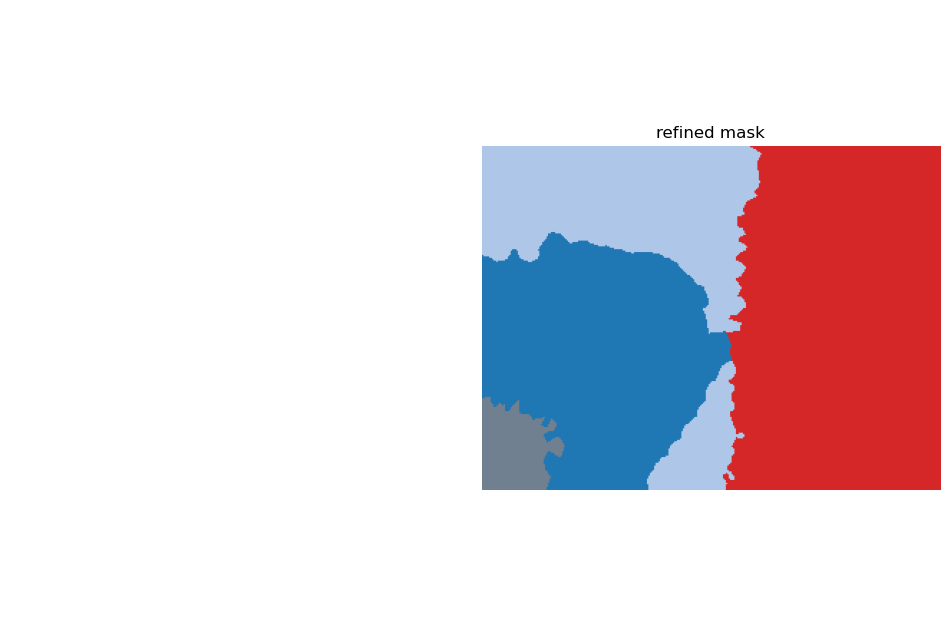

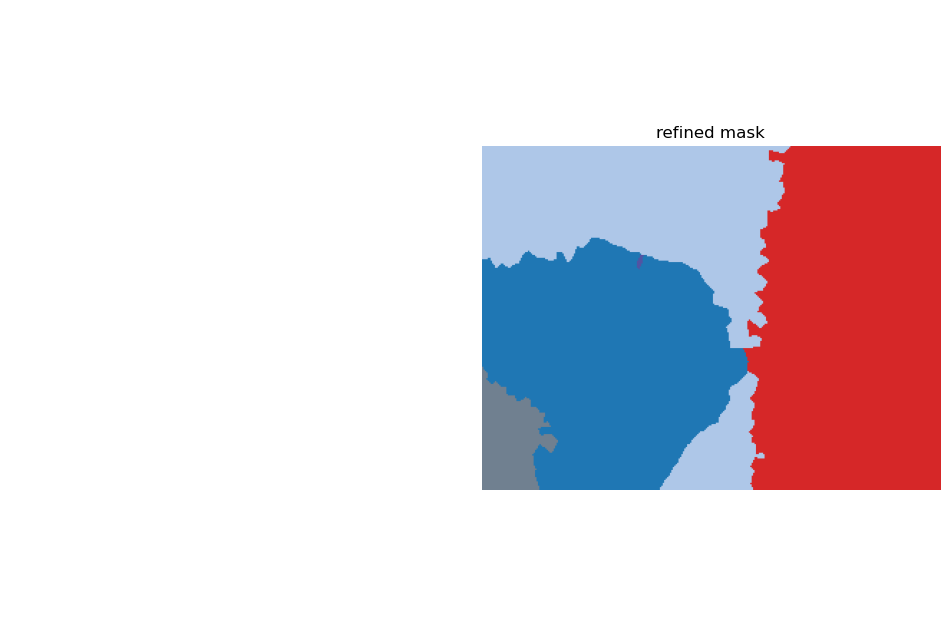

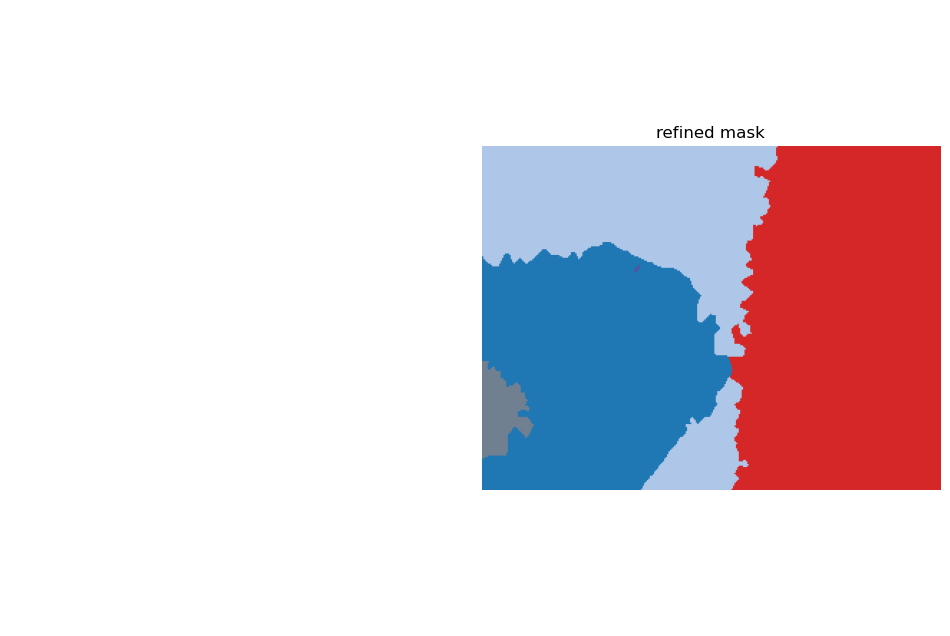

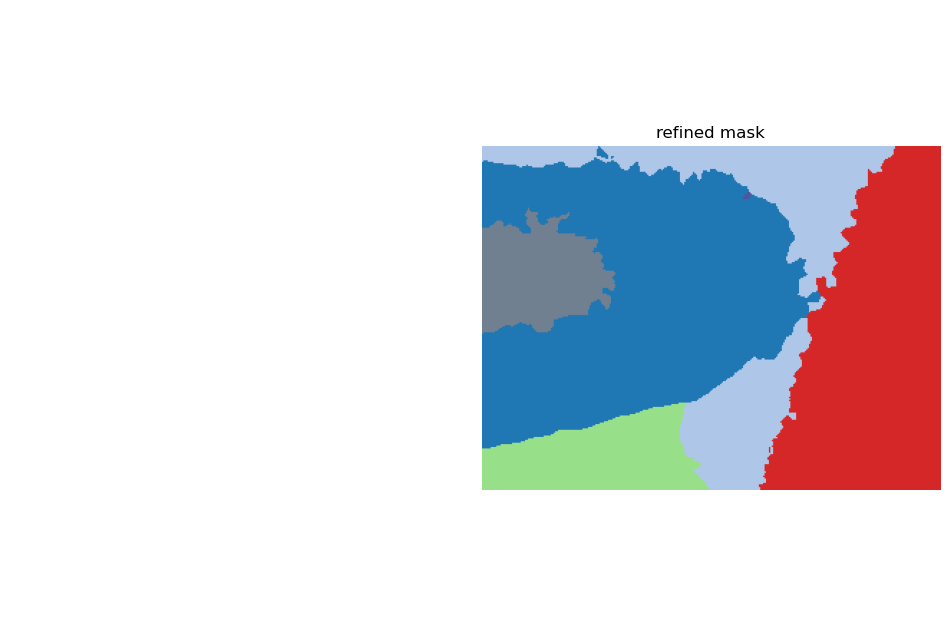

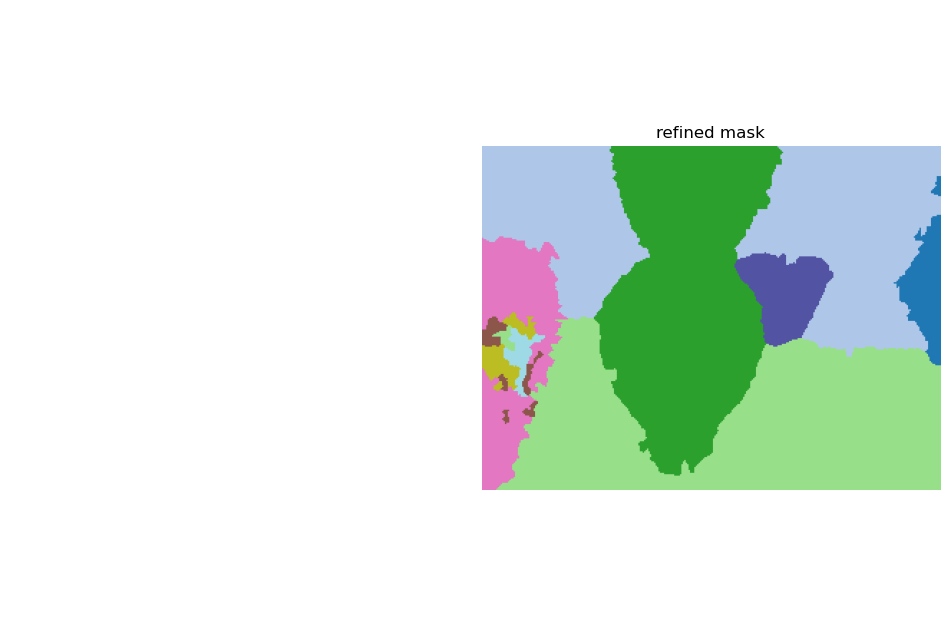

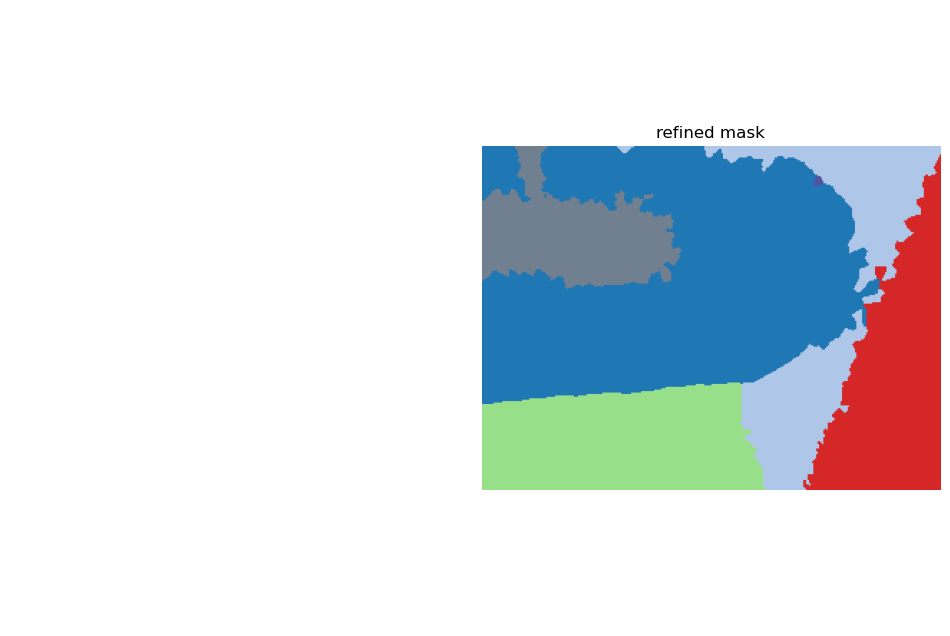

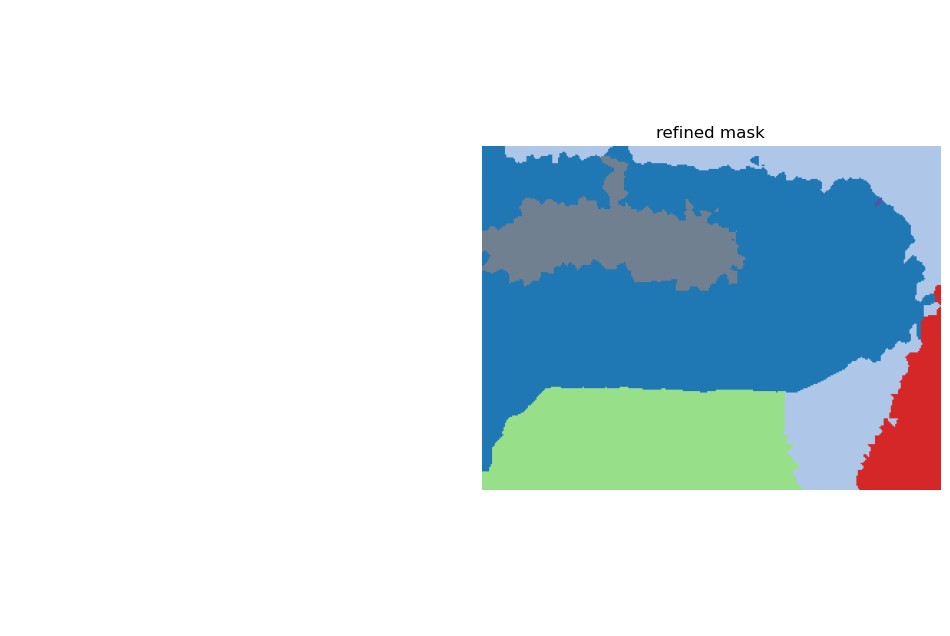

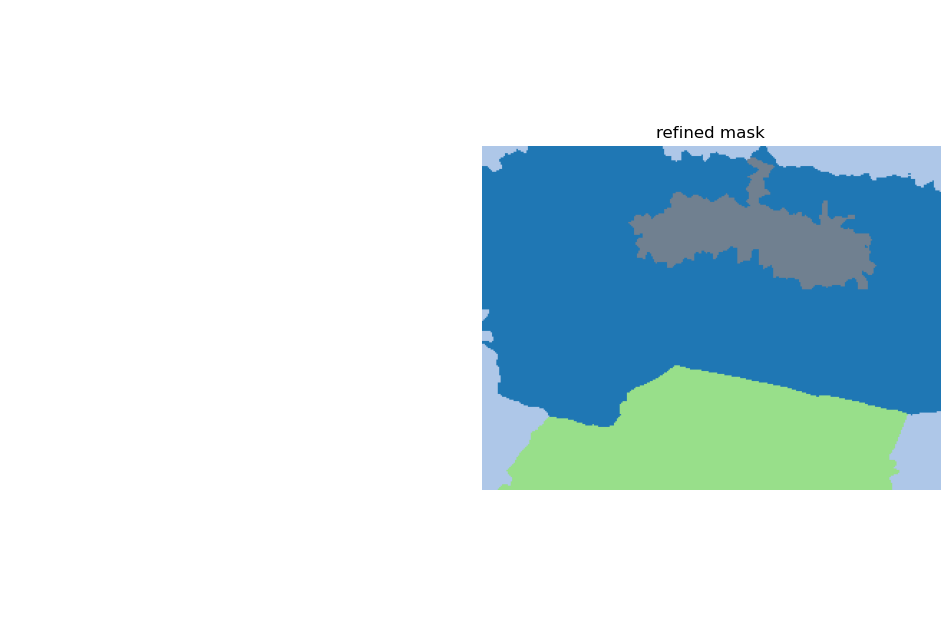

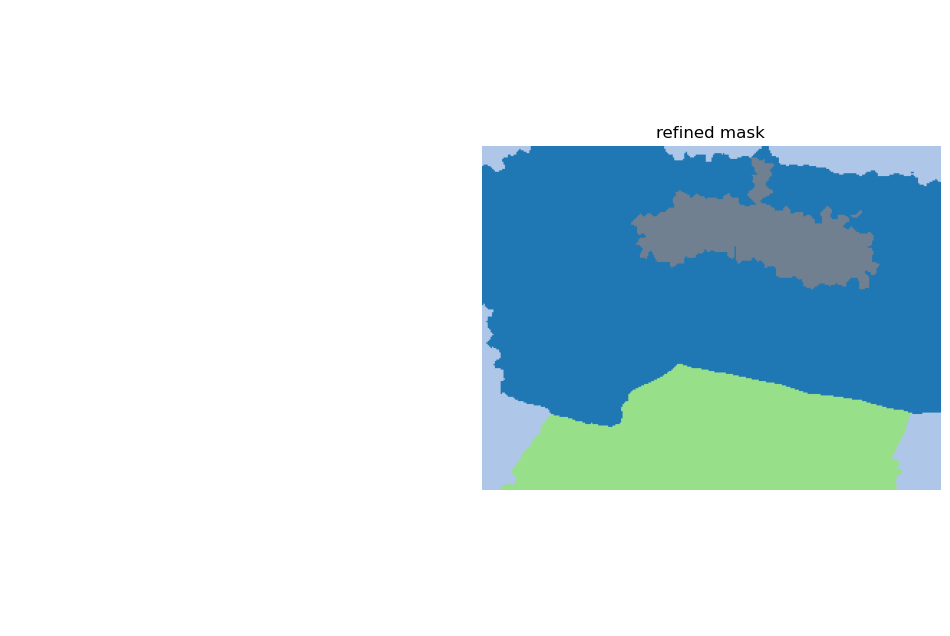

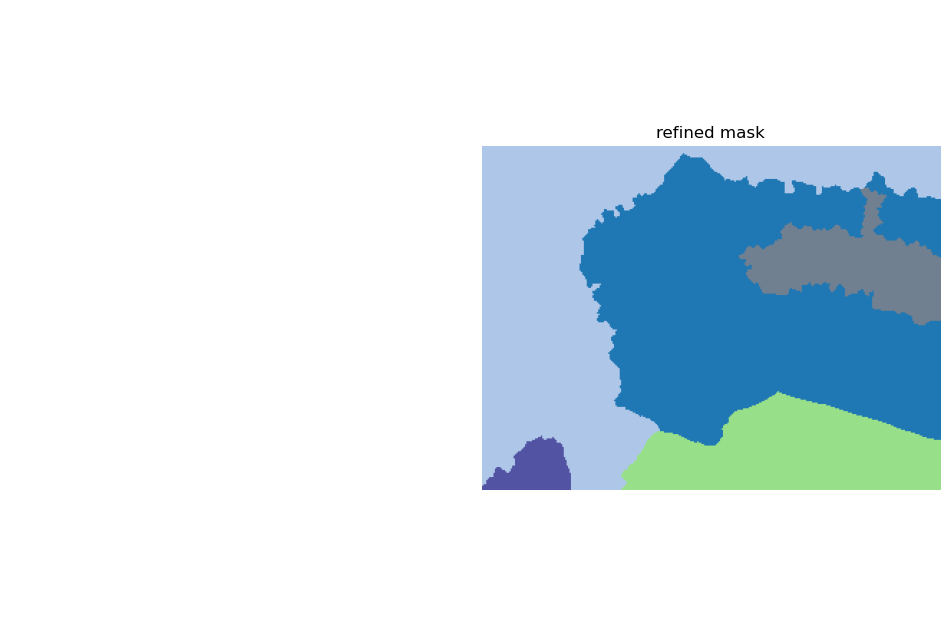

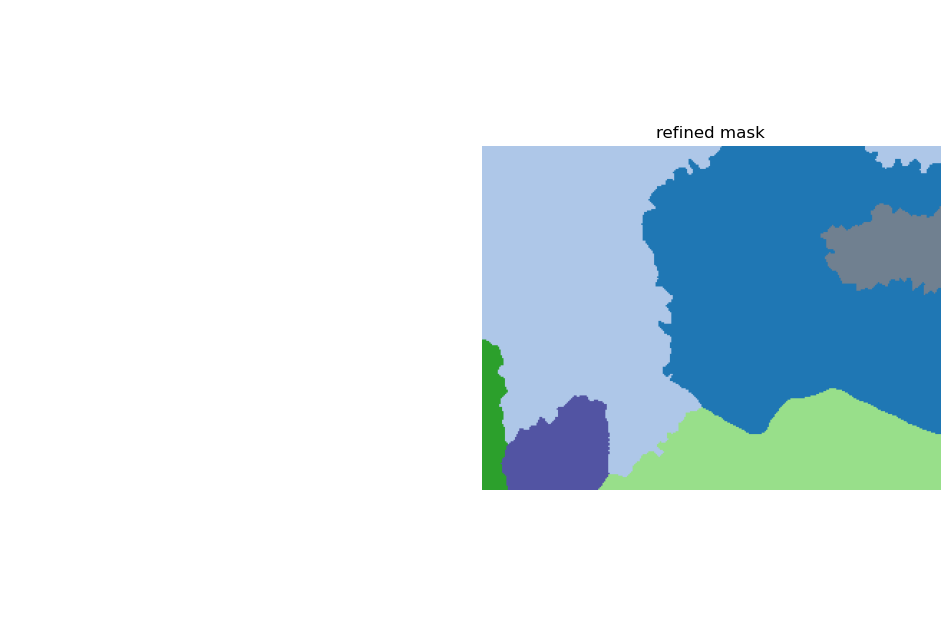

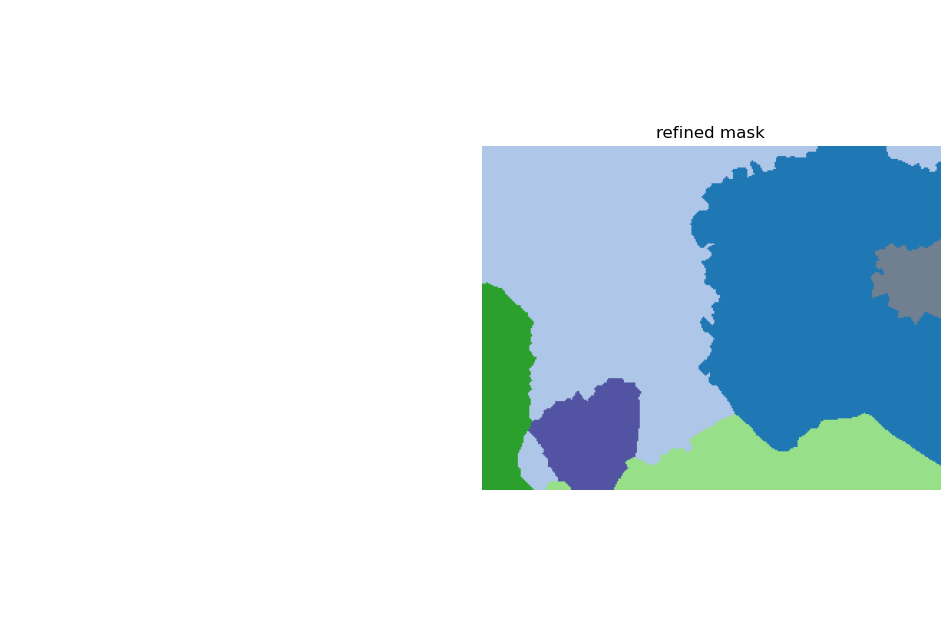

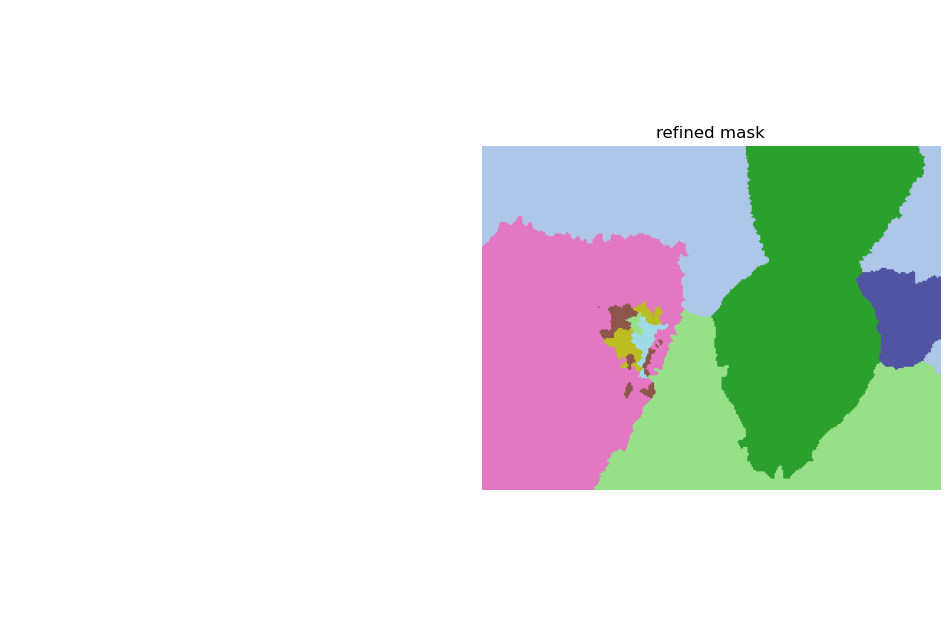

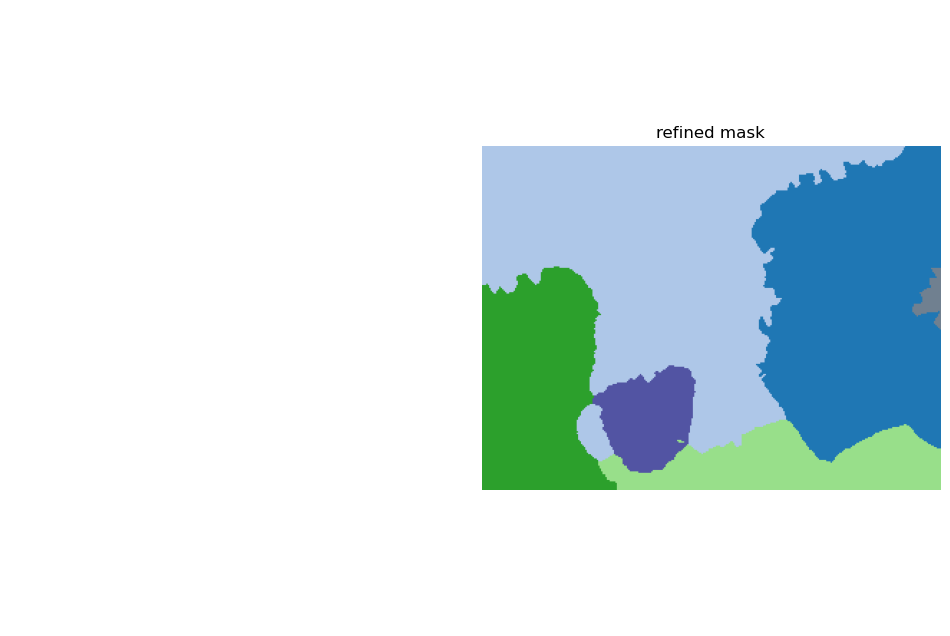

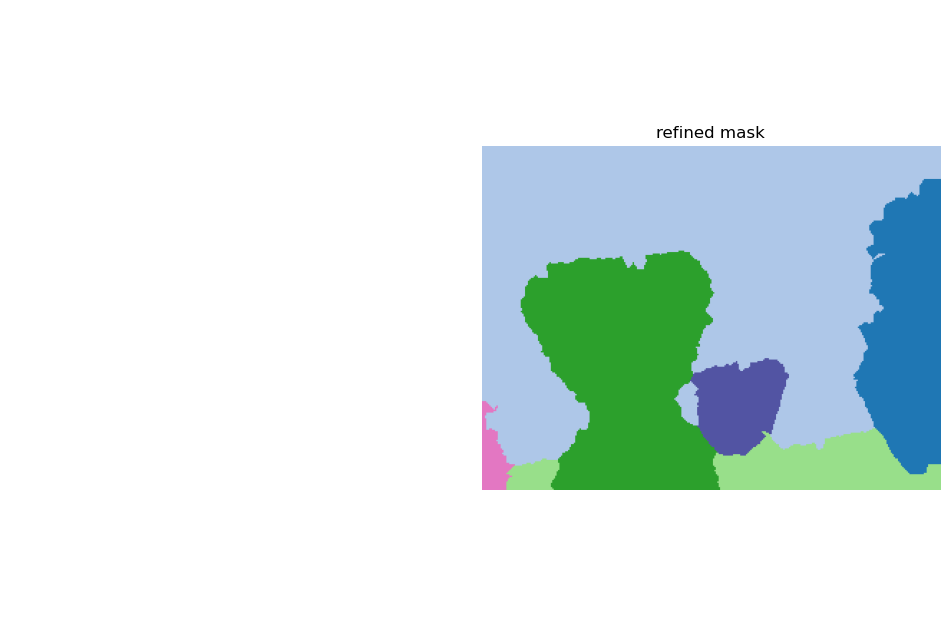

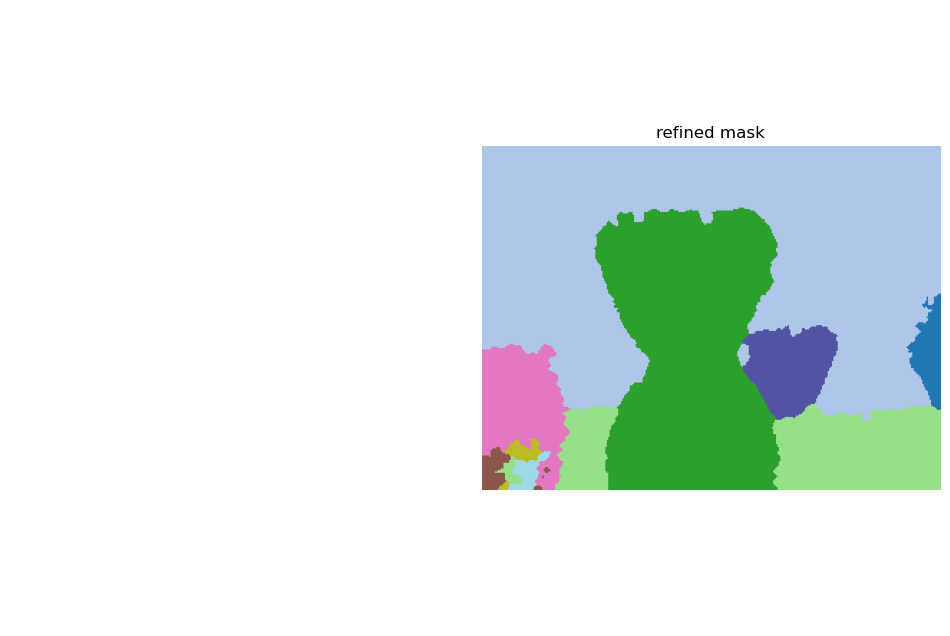

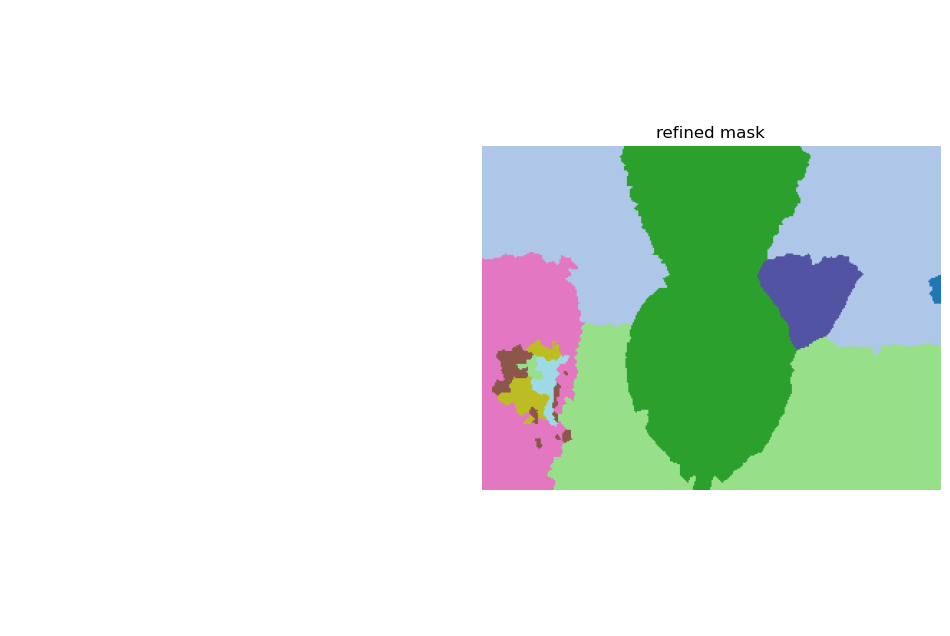

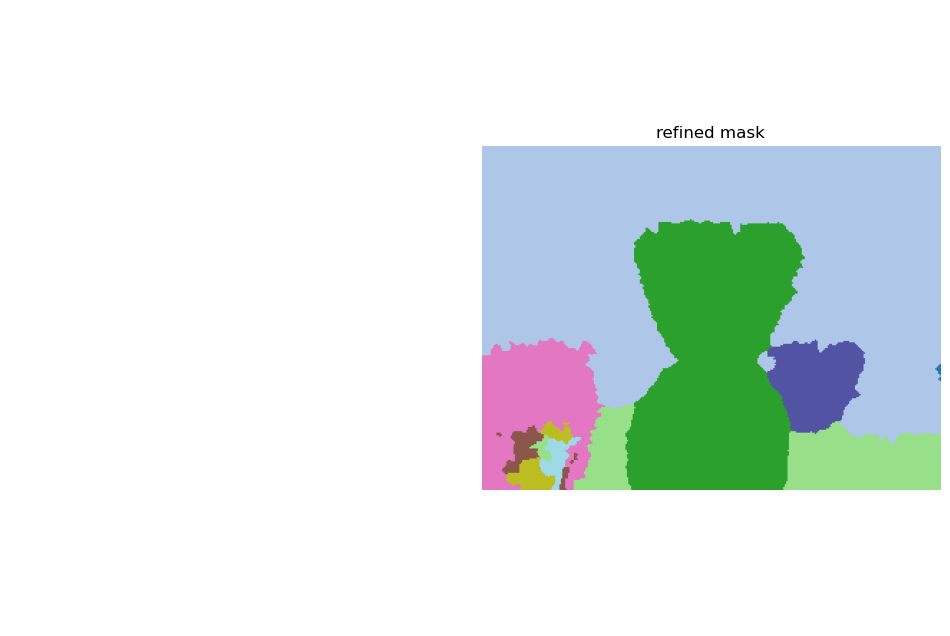

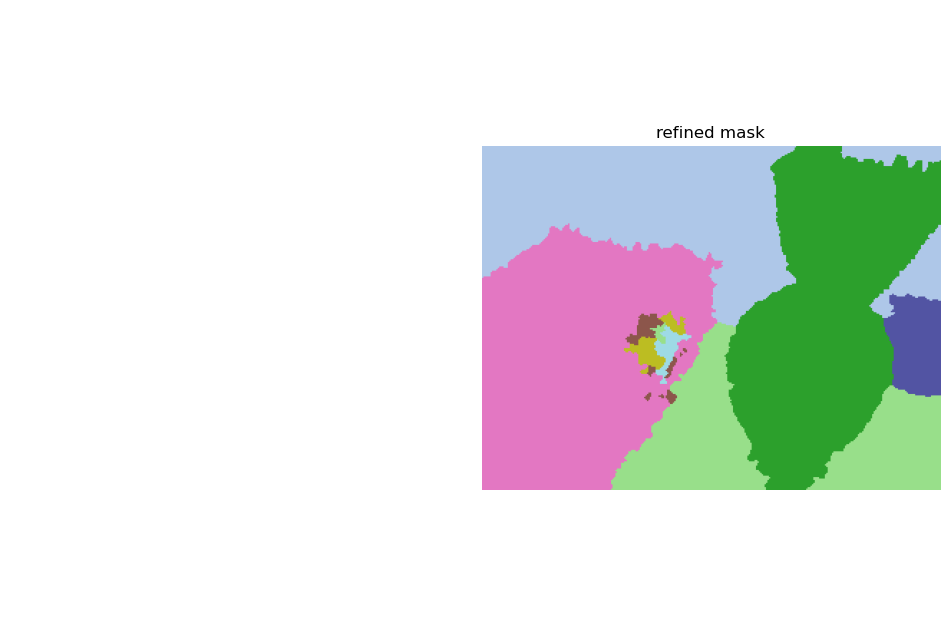

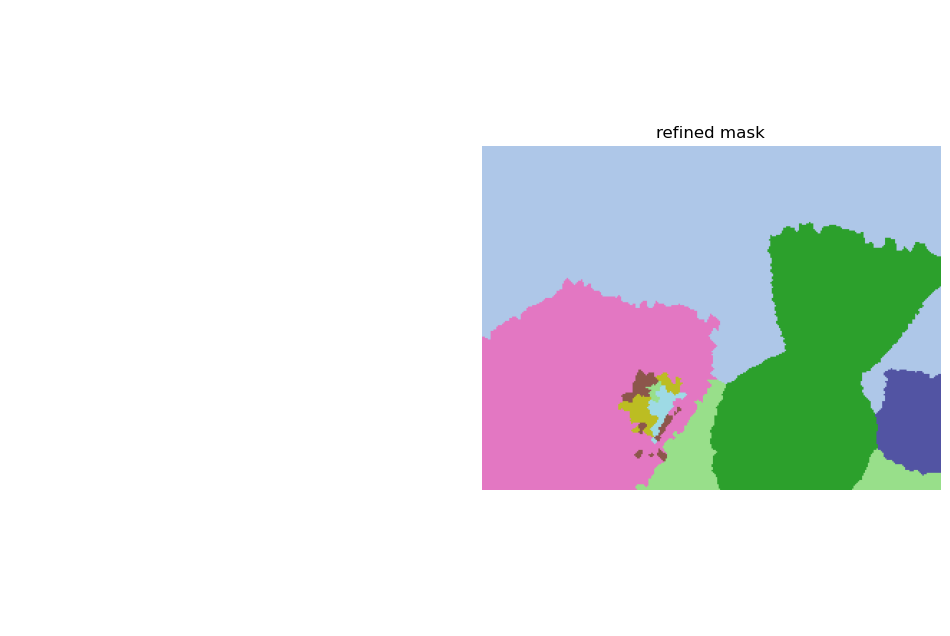

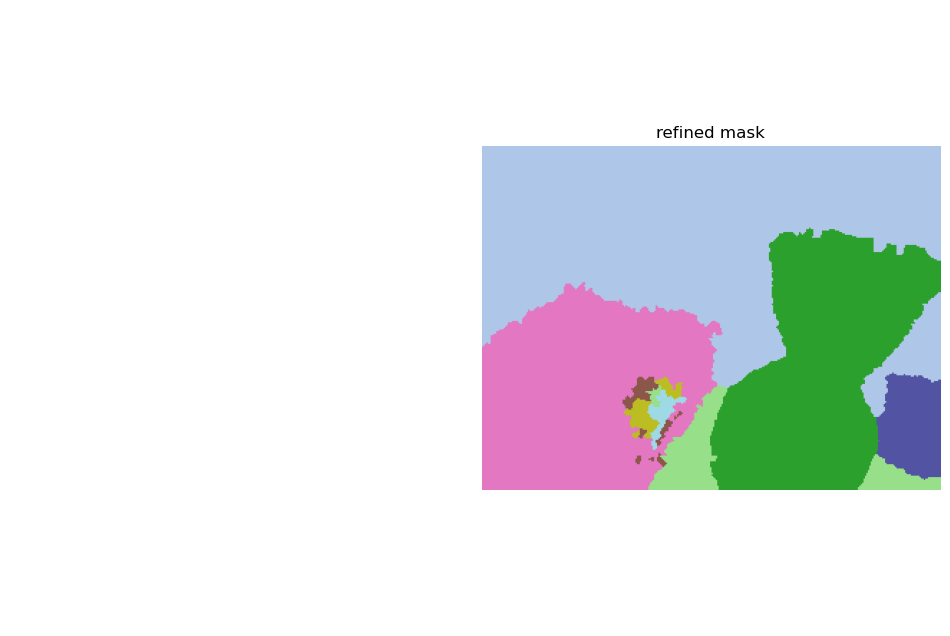

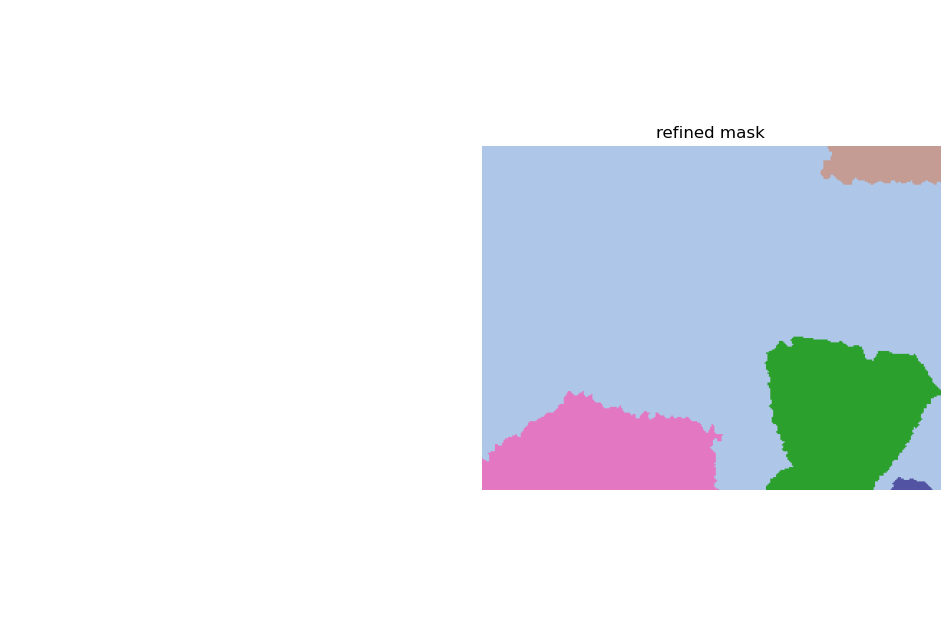

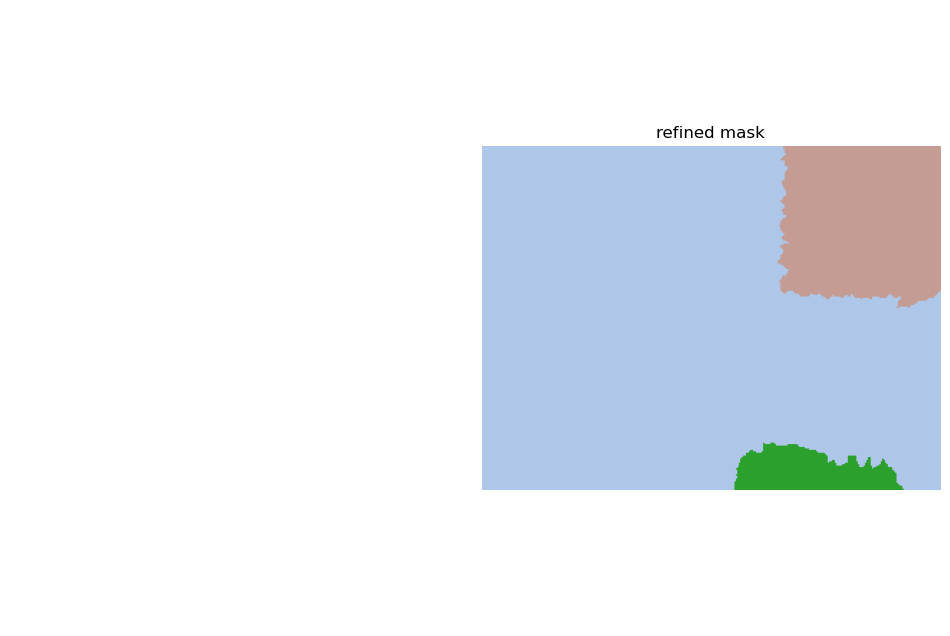

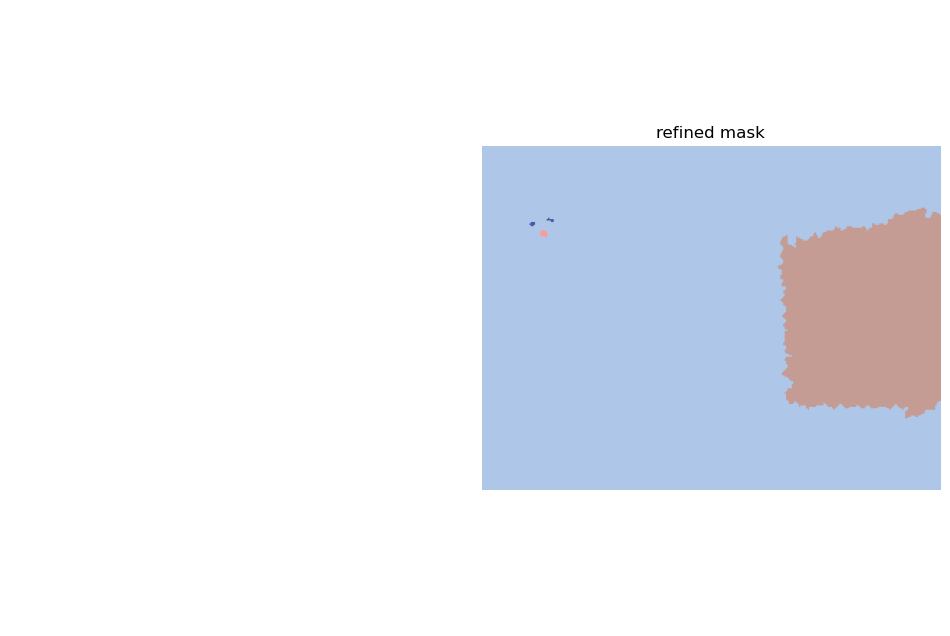

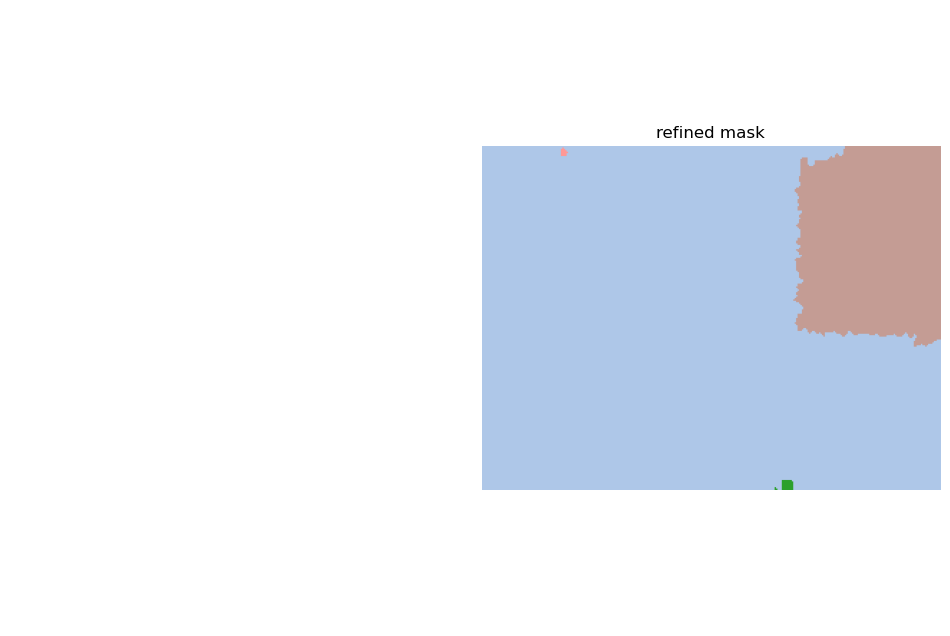

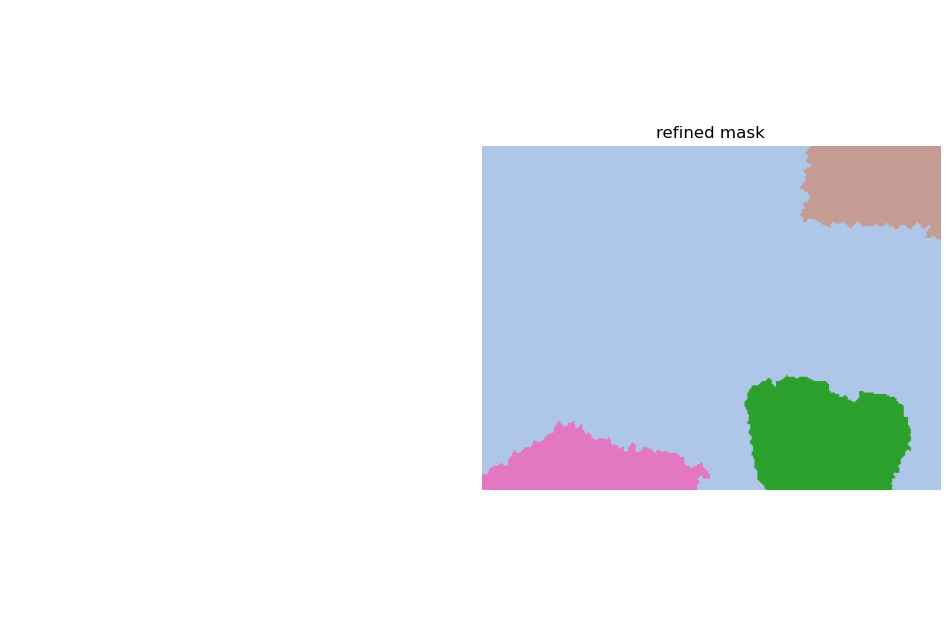

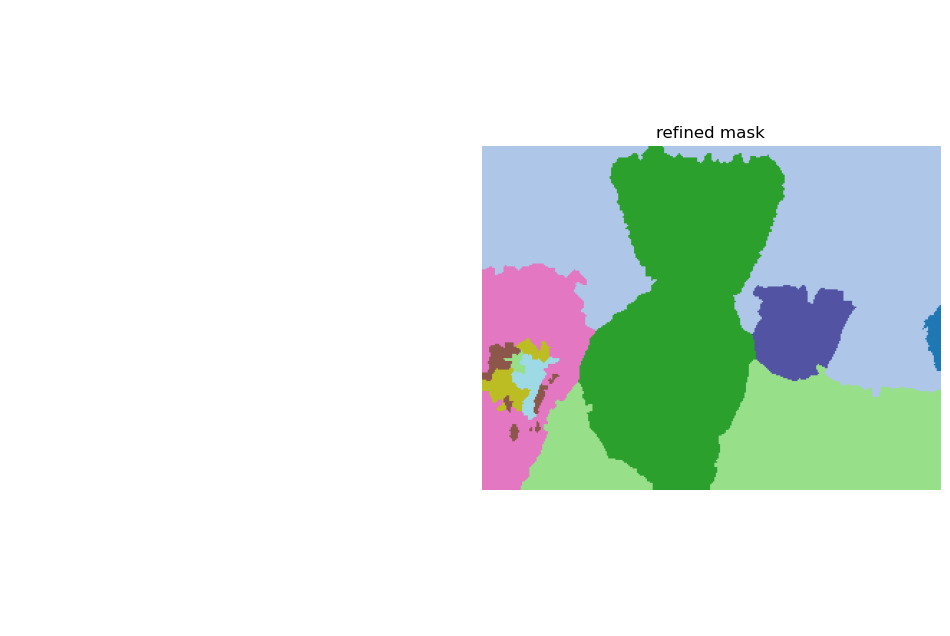

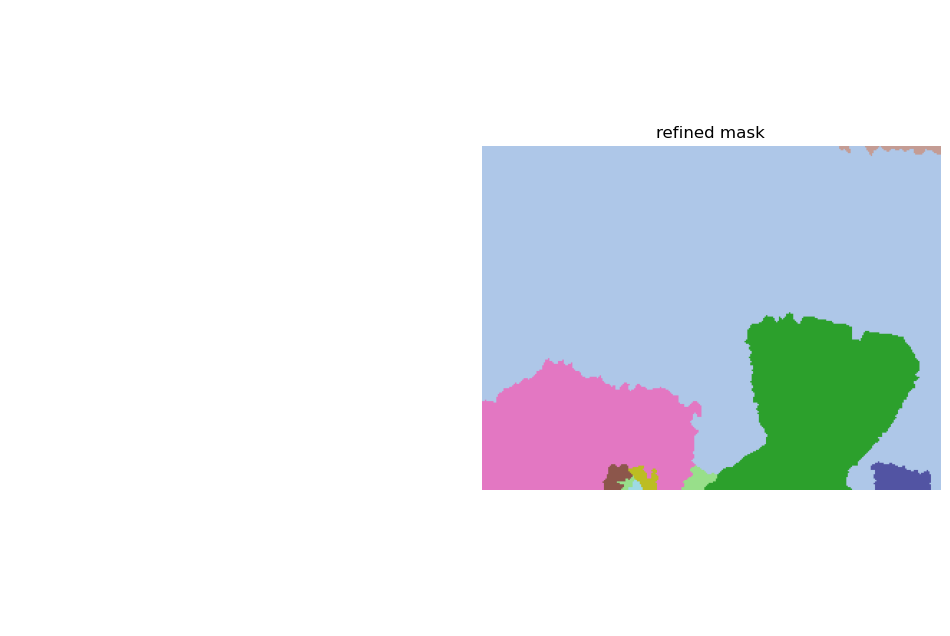

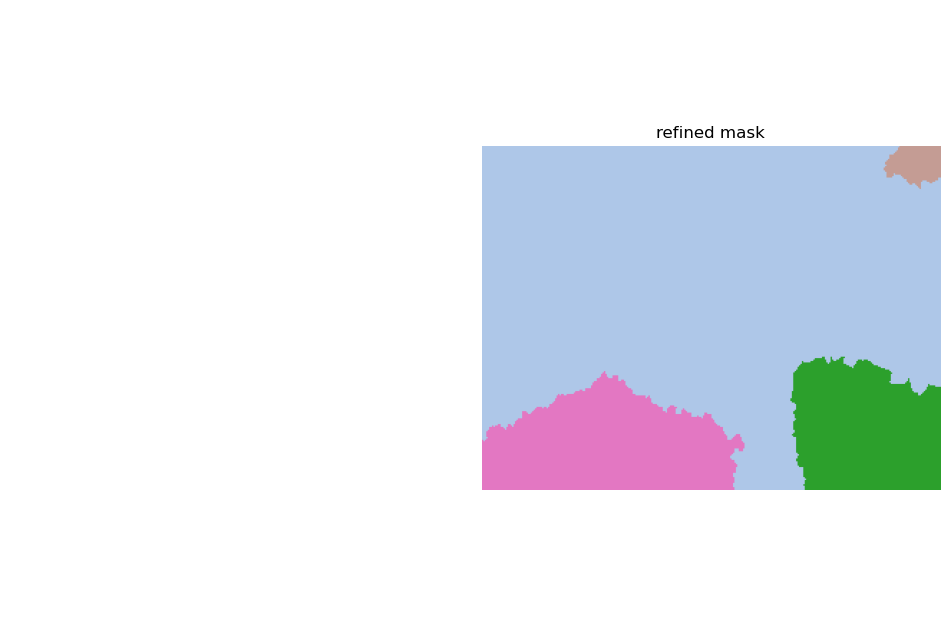

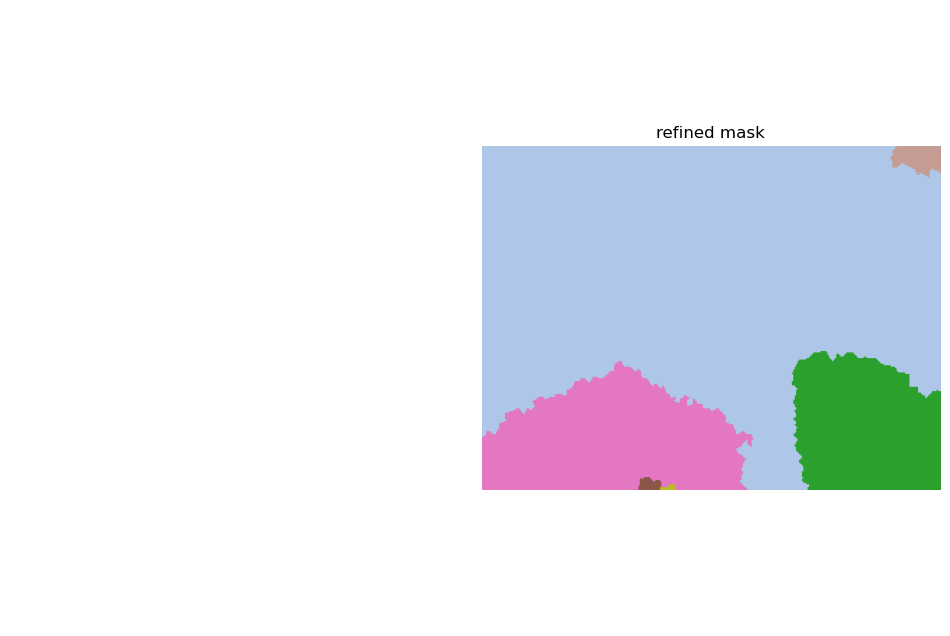

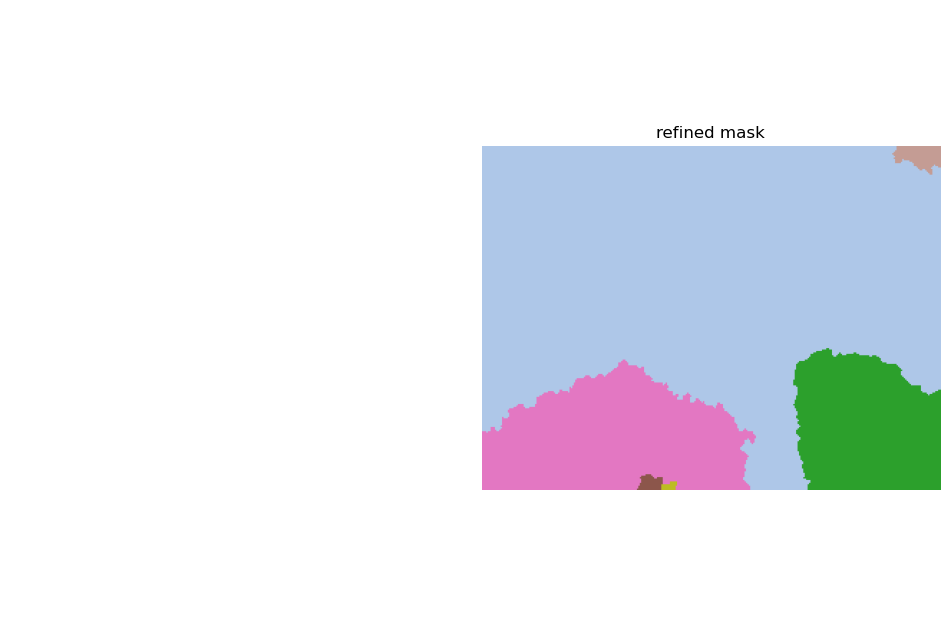

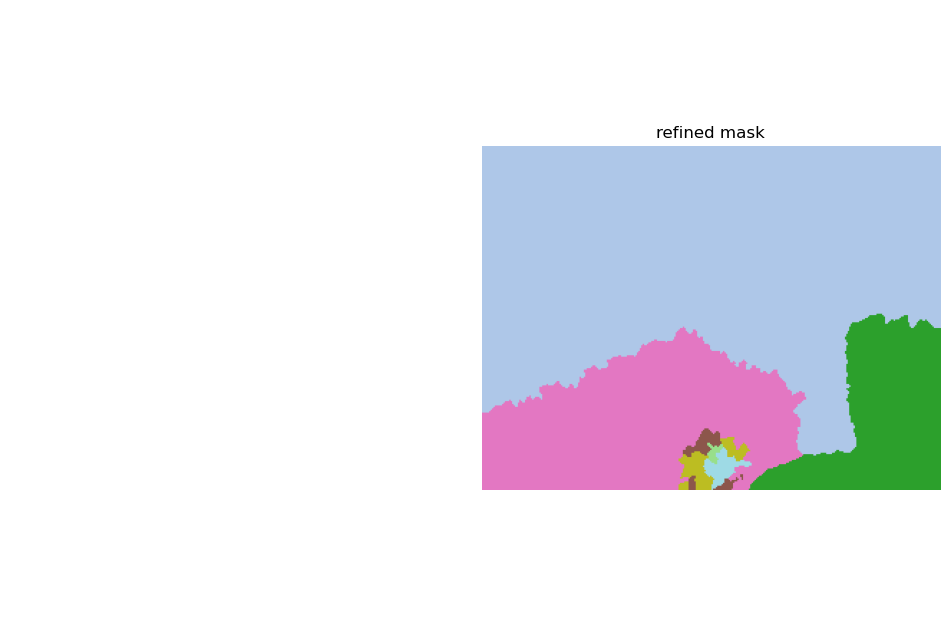

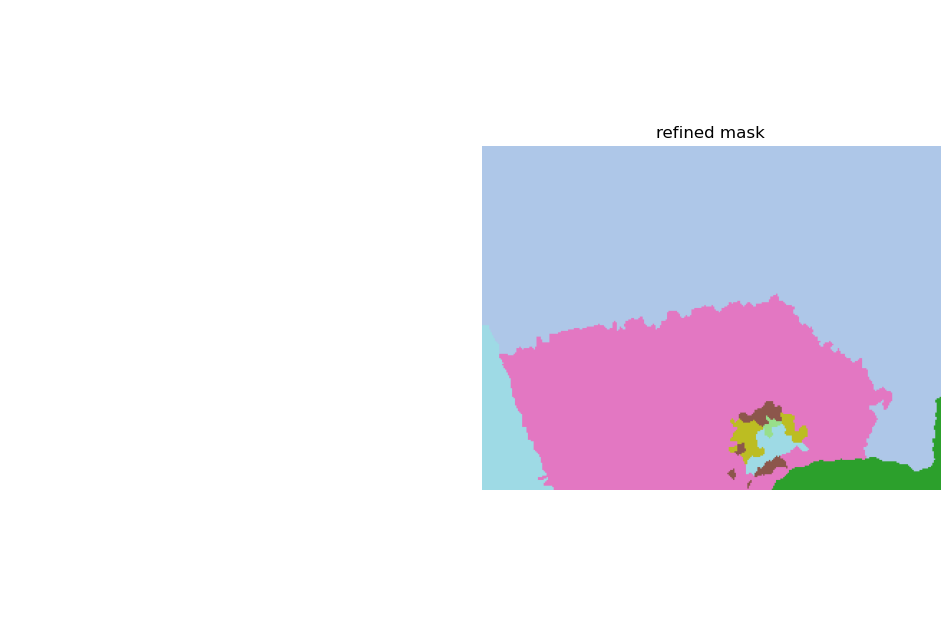

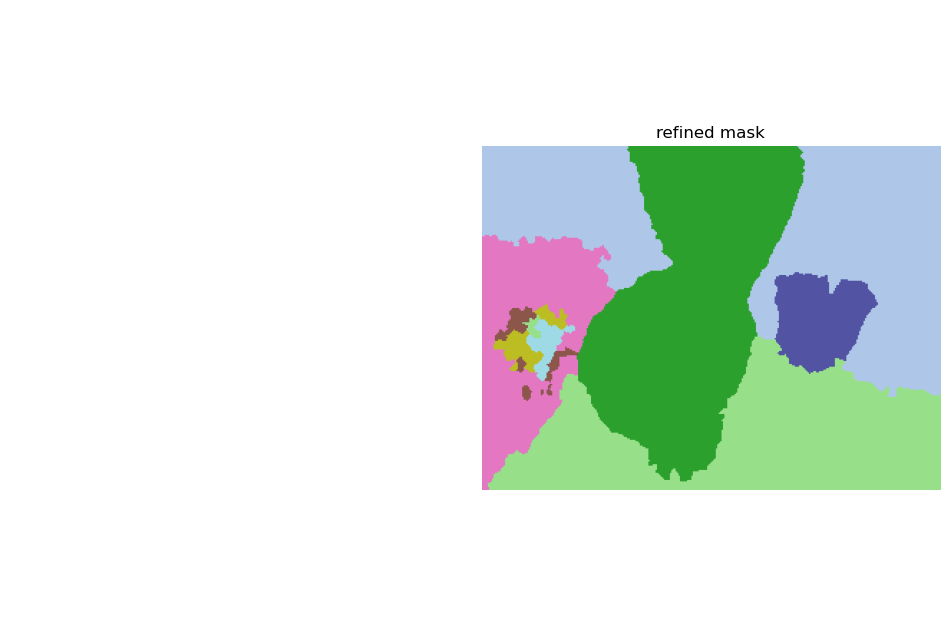

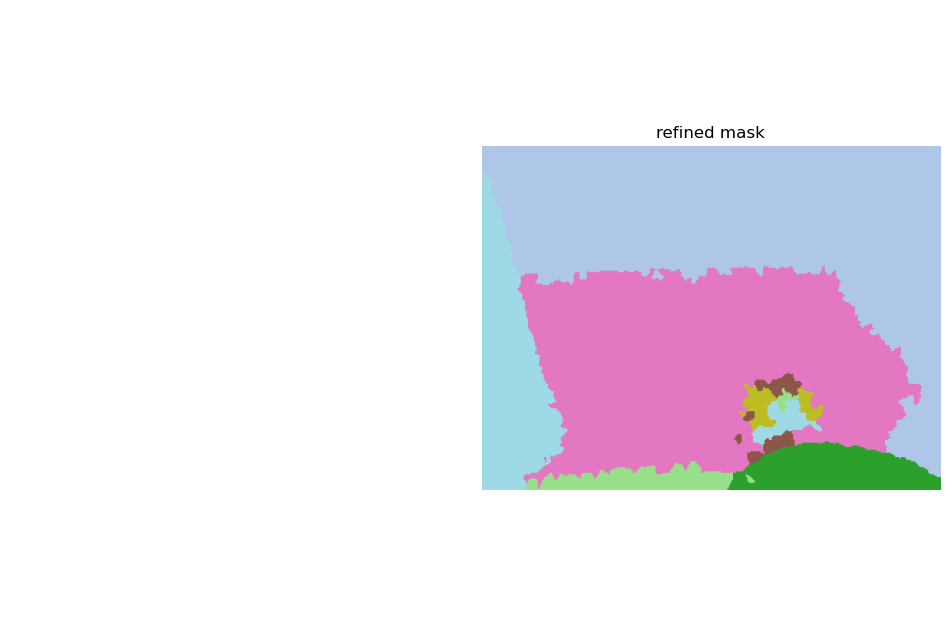

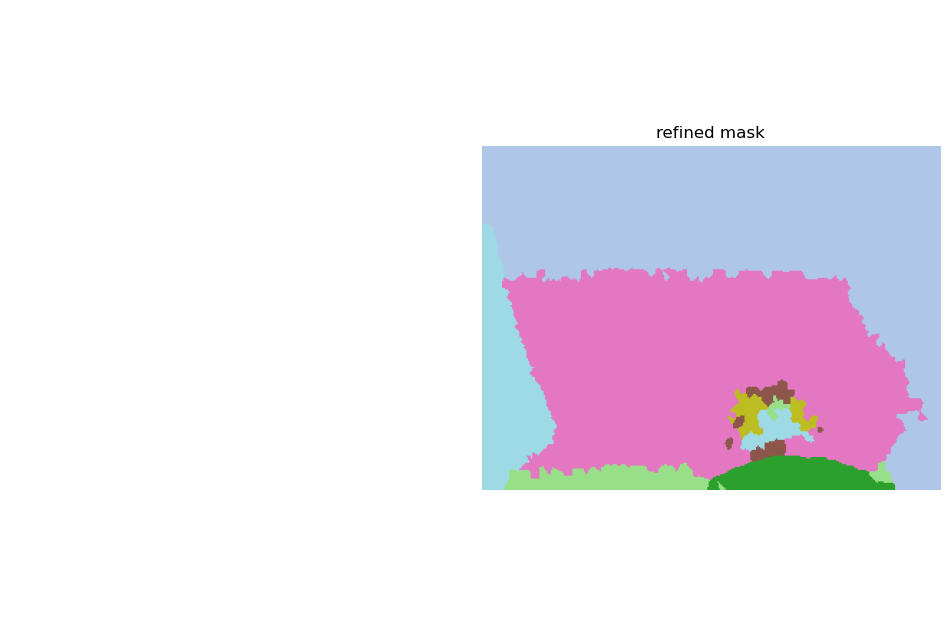

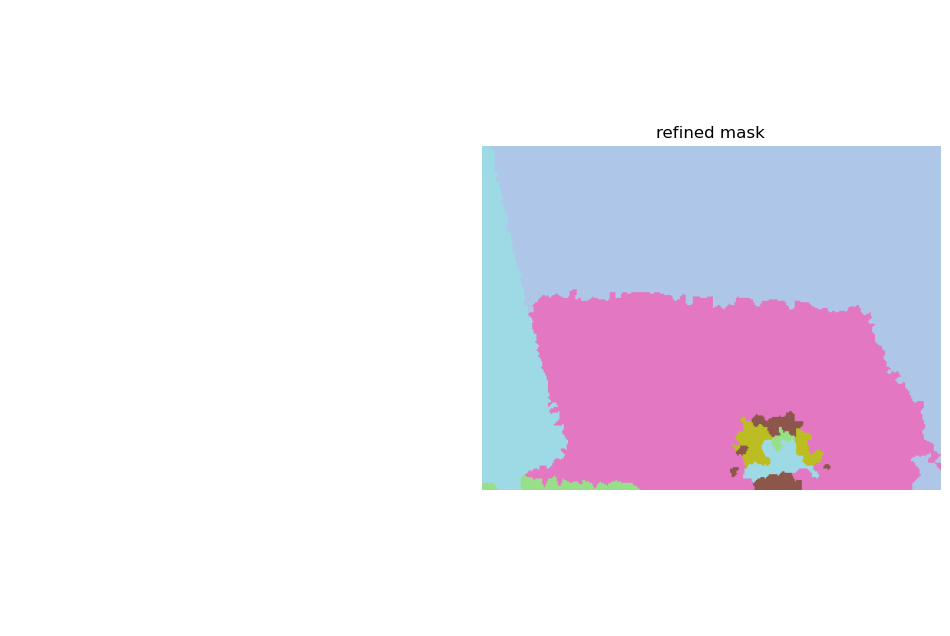

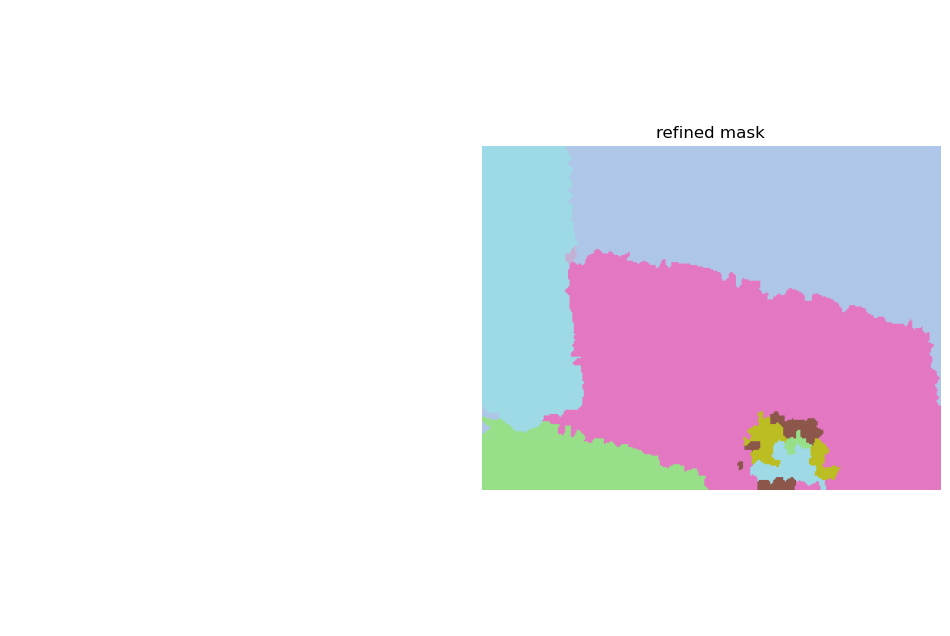

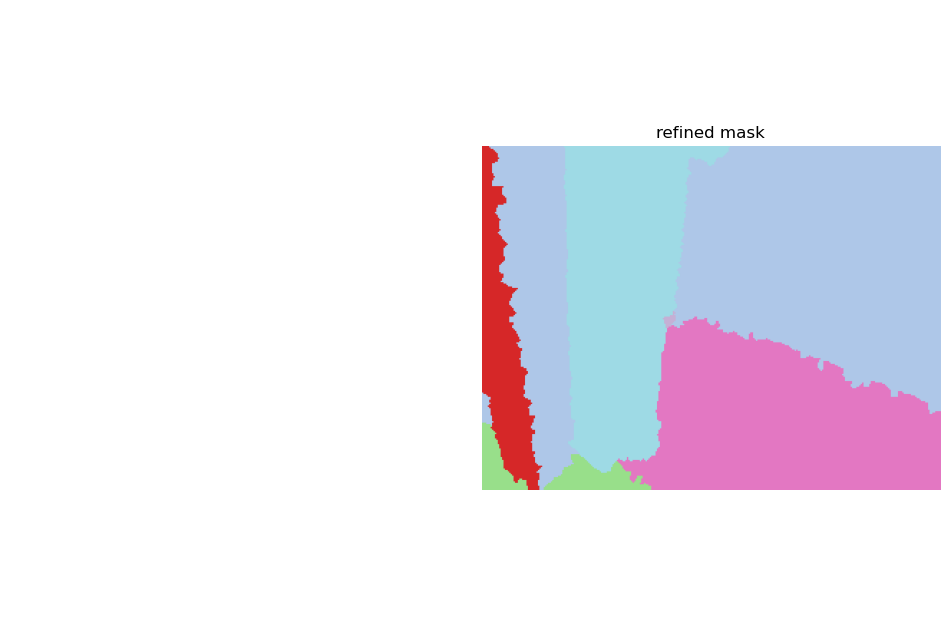

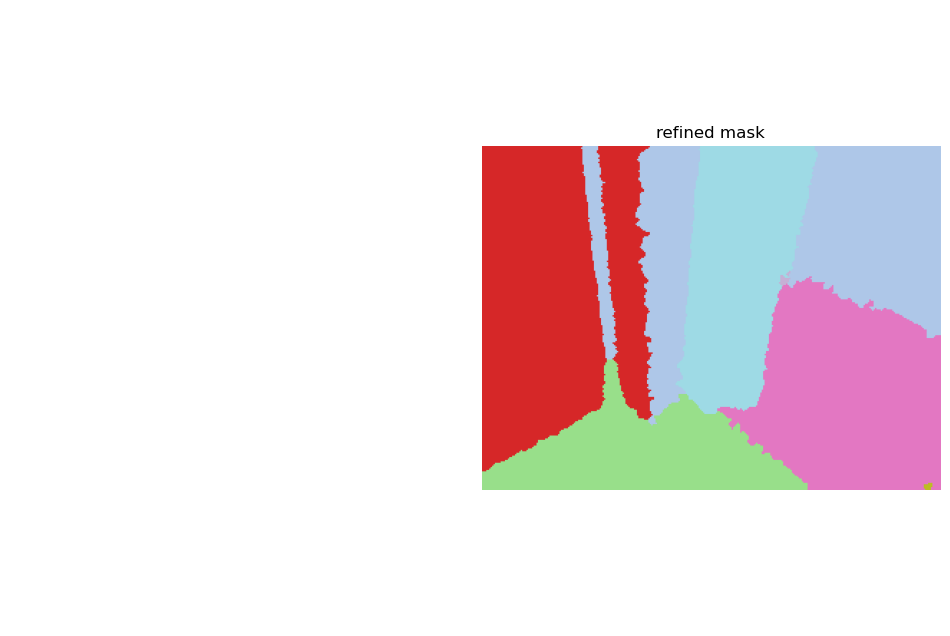

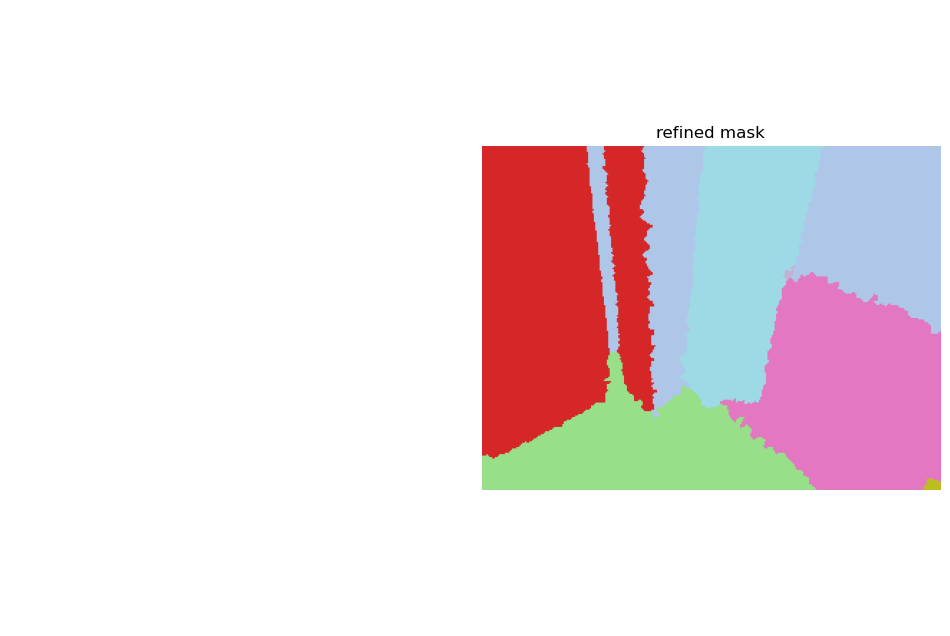

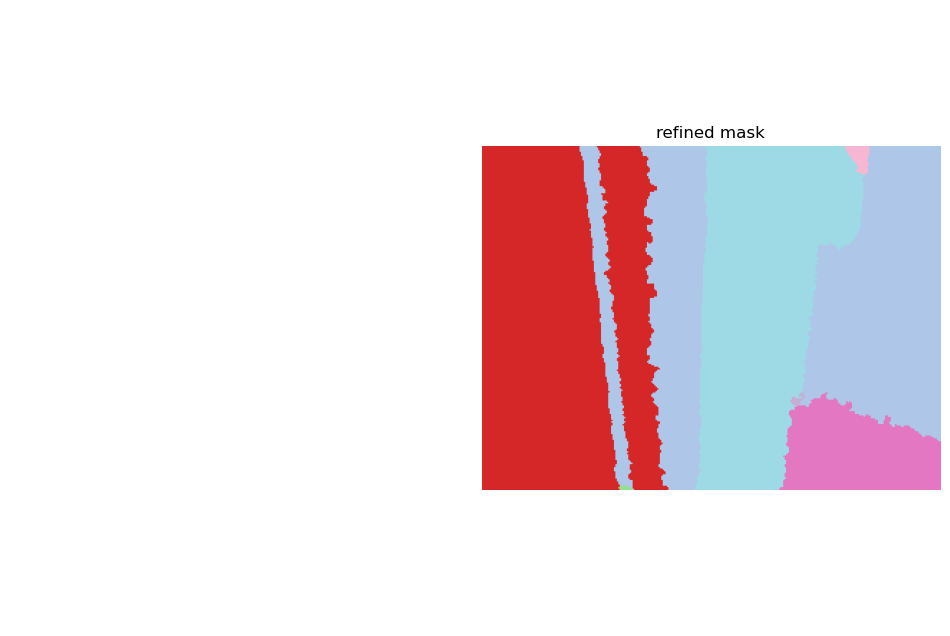

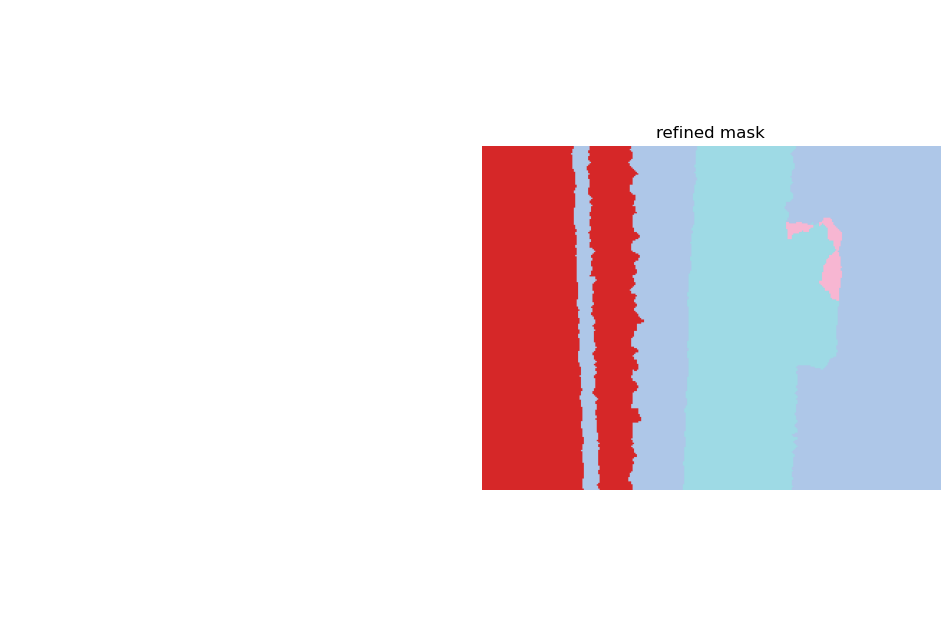

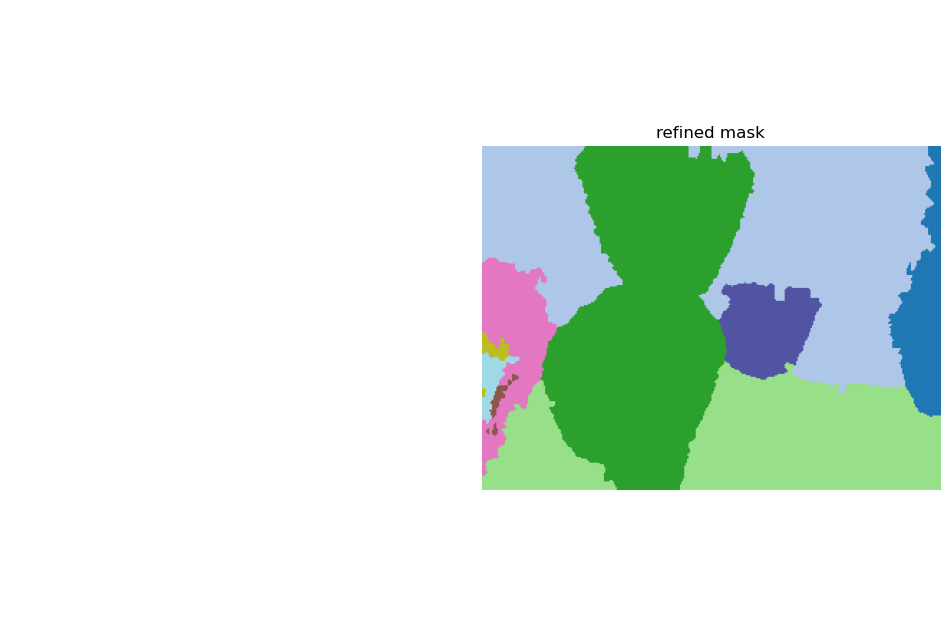

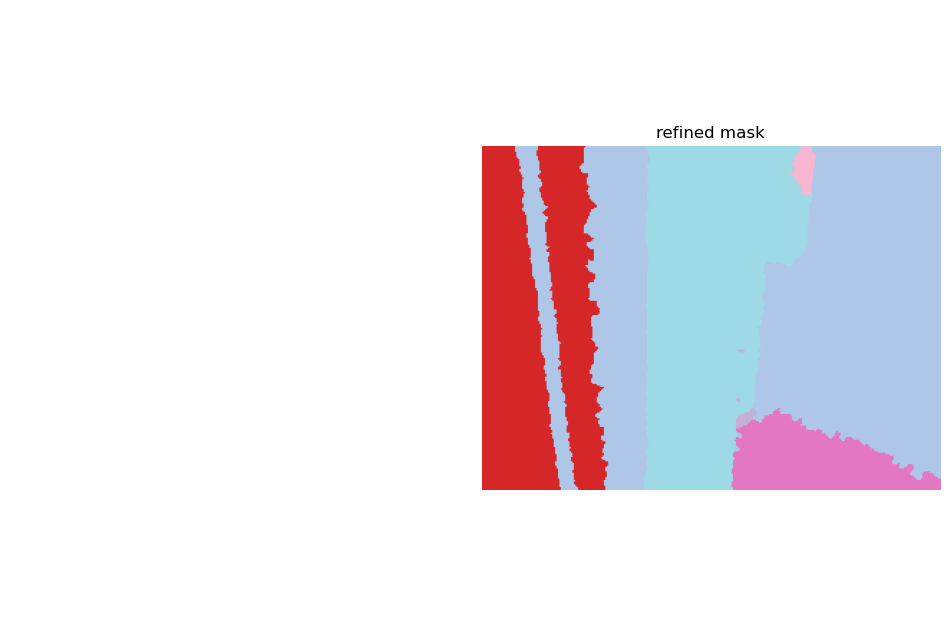

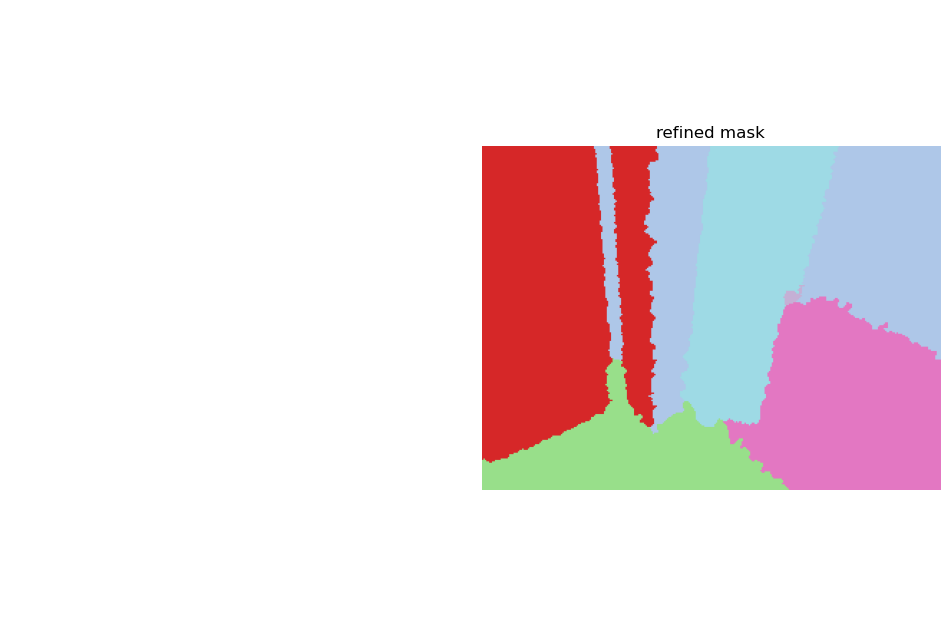

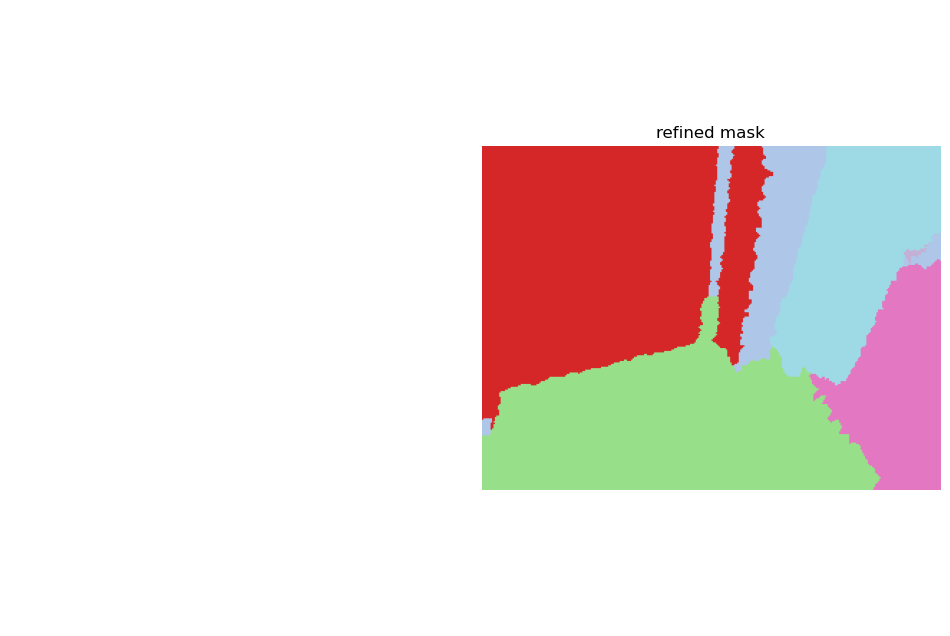

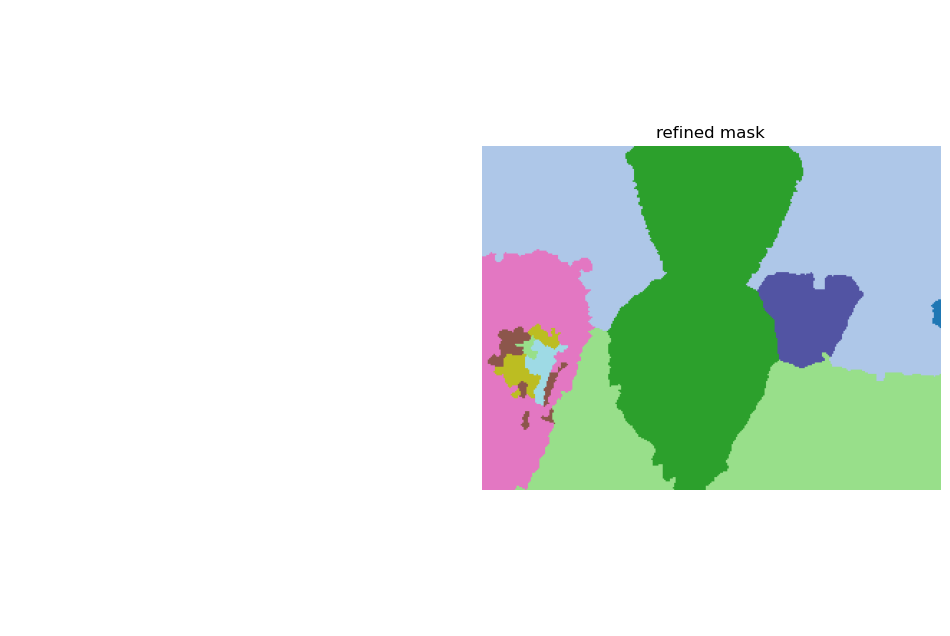

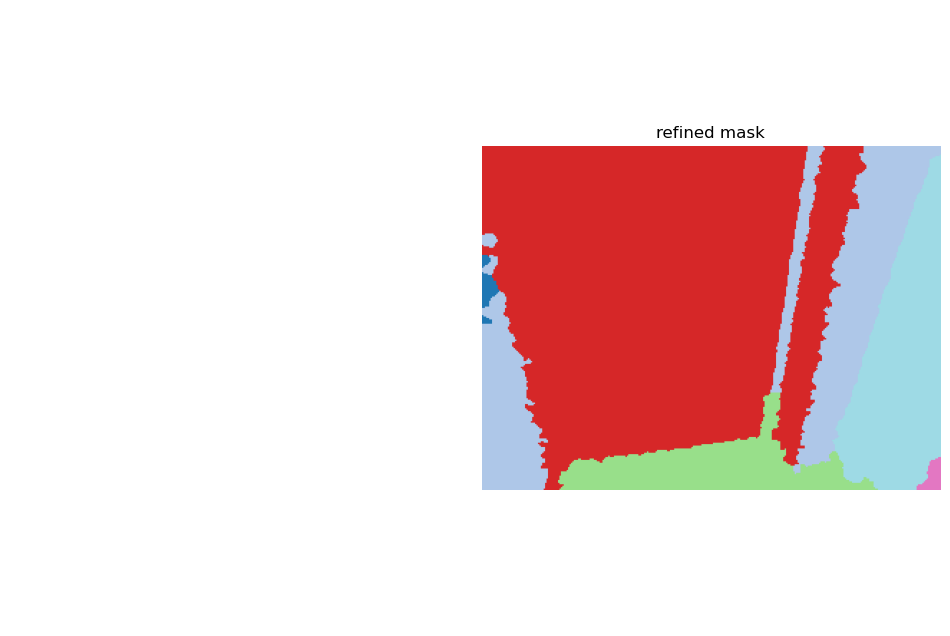

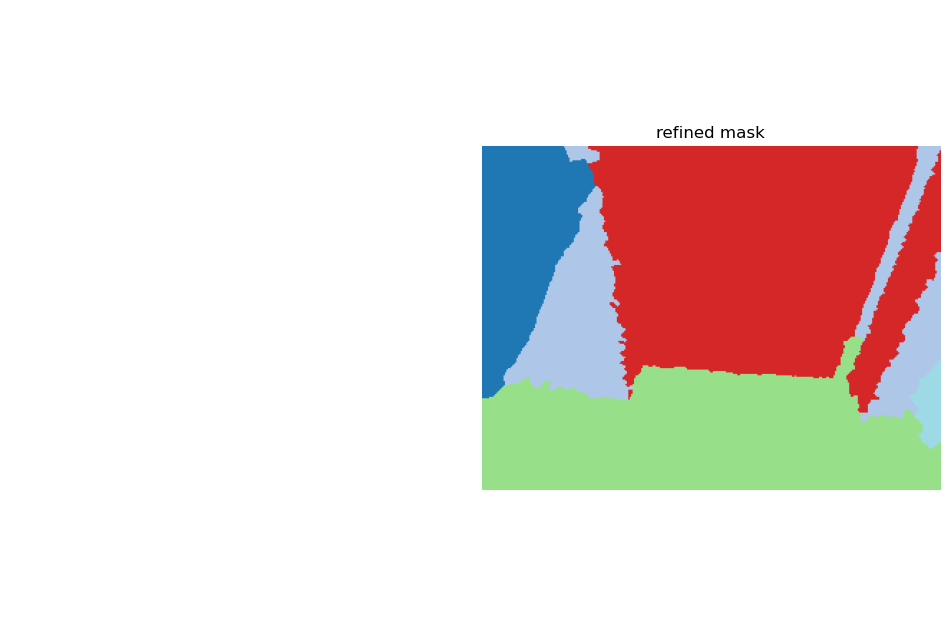

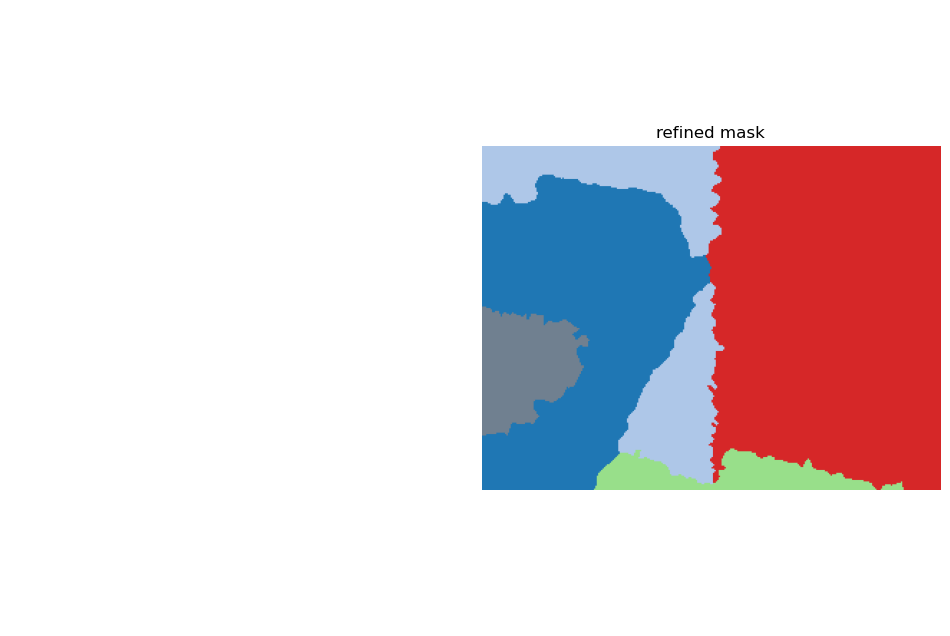

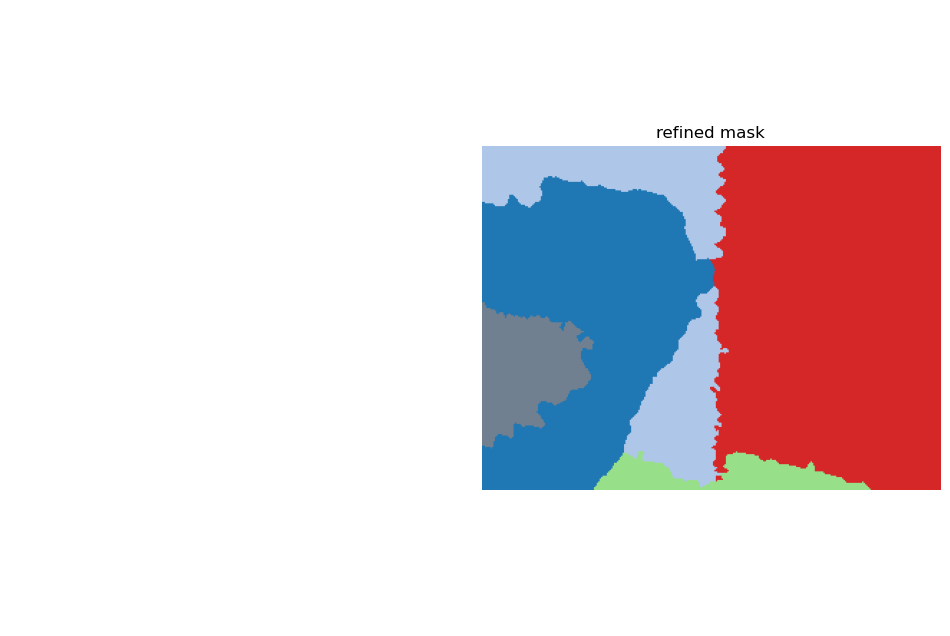

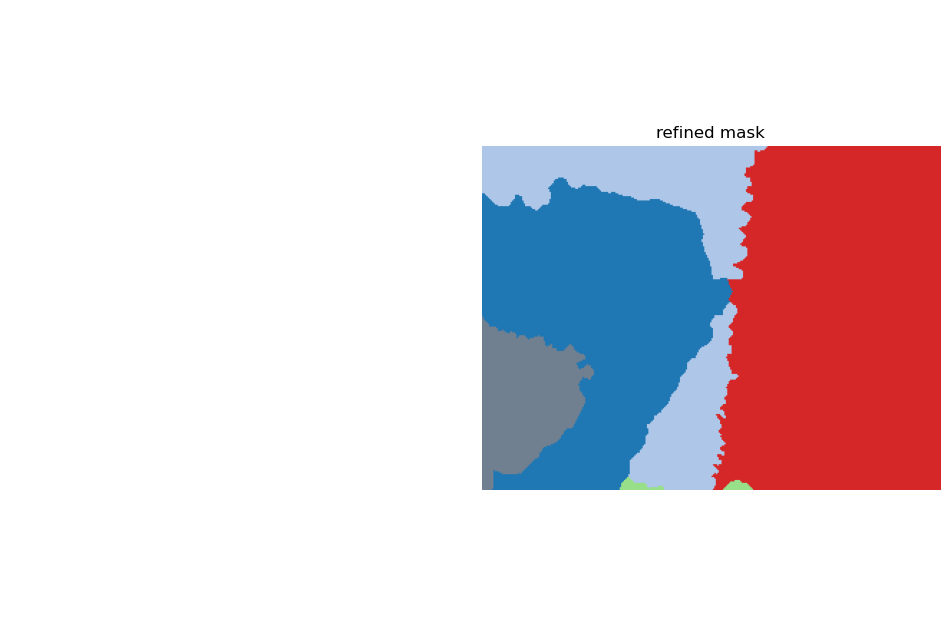

In [154]:
visualize_2d_fullres(model, mm_data_fullres, contains_pred=True)

In [140]:
# Visualize refined masks on 0.01 voxel size
from torch_points3d.utils.multimodal import lexargsort
from torch_points3d.core.multimodal.csr import CSRData
import scipy.ndimage
from PIL import Image
import numpy as np

def visualize_2d_fullres(model, mm_data, contains_pred=False, save_output=False):
    """ Track 2D scores for input semantic segmentation masks and output Multi-View Fusion refined 2D masks using simple nearest-neighbor interpolation and projected 3D point predictions.
    """
    if contains_pred == False:
        mm_data.data.pred = model.output.detach().cpu().argmax(1)

    mappings = mm_data.modalities['image'][0].mappings
    point_ids = torch.arange(
                    mappings.num_groups, device=mappings.device).repeat_interleave(
                    mappings.pointers[1:] - mappings.pointers[:-1])
    image_ids = mappings.images.repeat_interleave(
                    mappings.values[1].pointers[1:] - mappings.values[1].pointers[:-1])    
    pixels_full = mappings.pixels

    # Sort point and image ids based on image_id
    idx_sort = lexargsort(image_ids, point_ids)
    image_ids = image_ids[idx_sort]
    point_ids = point_ids[idx_sort]
    pixels_full = pixels_full[idx_sort].long()

    # Get pointers for easy indexing
    pointers = CSRData._sorted_indices_to_pointers(image_ids)

#     # Save refined masks
#     im_paths = mm_data.modalities['image'][0].gt_mask_path
#     scan_dir = os.sep.join(im_paths[0].split(os.sep)[:-2])
#     input_mask_name = mm_data.modalities['image'][0].m2f_pred_mask_path[0].split(os.sep)[-2]

#     # Dirty workaround for masks in different directory
#     if input_mask_name == 'ViT_masks':
#         scan_id = scan_dir.split(os.sep)[-1]
#         mask_im_dir = osp.join("/home/fsun/data/scannet/scans", scan_id, input_mask_name)
#         refined_mask_im_dir = osp.join(scan_dir, input_mask_name + '_refined')
#     else:
#         mask_im_dir = osp.join(scan_dir, input_mask_name)
#         refined_mask_im_dir = osp.join(scan_dir, input_mask_name + '_refined')

#     if save_output:
#         print("Creating refined mask dir at ", refined_mask_im_dir)
#         os.makedirs(refined_mask_im_dir, exist_ok=True)

    # Loop over all N views
    for i, x in enumerate(mm_data.modalities['image'][0]):

        # Grab the 3D points corresponding to ith view
        start, end = pointers[i], pointers[i+1]    
        points = point_ids[start:end]
        pixels = pixels_full[start:end]
        # Image (x, y) pixel index
        w, h = pixels[:, 0], pixels[:, 1]

        # Grab set of points visible in current view
        mm_data_of_view = mm_data[points]

        im_ref_w, im_ref_h = x.ref_size

        # Get nearest neighbor interpolated projection image filled with 3D labels
        pred_mask_2d = -1 * torch.ones((im_ref_h, im_ref_w), dtype=torch.long, device=mm_data_of_view.device)    
        pred_mask_2d[h, w] = mm_data_of_view.data.pred.squeeze()

        nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
            pred_mask_2d==-1, return_distances=False, return_indices=True)    
        pred_mask_2d = pred_mask_2d[nearest_neighbor].numpy().astype(np.uint8)
        pred_mask_2d = Image.fromarray(pred_mask_2d, 'L')          

#         # SAVE REFINED MASK IN GIVEN DIR
#         im_name = x.m2f_pred_mask_path[0].split("/")[-1]

        pred_mask_2d = pred_mask_2d.resize((640, 480), resample=0)

#         if save_output:
#             pred_mask_2d.save(osp.join(refined_mask_im_dir, im_name))

        pred_mask_2d = np.asarray(pred_mask_2d)

#         # 2D mIoU calculation for M2F labels per view
#         # Get gt 2d image
#         gt_img_path = x.m2f_pred_mask_path[0].split("/")
#         # Adjust filepath after Snellius migration
#         gt_img_path[1] = 'scratch-shared'
#         gt_img_path[-2] = 'label-filt-scannet20'
#         gt_img_path = "/".join(gt_img_path)
#         gt_img = Image.open(gt_img_path)

#         gt_img = np.asarray(gt_img.resize((640, 480), resample=0)).astype(int) - 1   # -1 label offset

        # Input mask and refined mask for current view
        refined_im = pred_mask_2d
#         gt_im = gt_img



        f, axarr = plt.subplots(1, 2, figsize=(12, 8))
        f.subplots_adjust(hspace=0.01, wspace=0.03)

#         input_im = Image.open(osp.join(input_mask_dir, scene_id, input_mask_name, m))
#         input_im = np.array(input_im) - 1   # label offset
#         input_im = np.array(CLASS_COLORS)[input_im].astype(np.uint8)

#         refined_im = Image.open(osp.join(refined_mask_dir, scene_id, refined_mask_name, m))
#         refined_im = np.array(refined_im)
        refined_im = np.array(CLASS_COLORS)[refined_im].astype(np.uint8)

#         gt_im = Image.open(osp.join(refined_mask_dir, scene_id, 'label-filt-scannet20', m))
#         gt_im = np.array(gt_im).astype(int) - 1   # label offset
#         gt_im = np.array(CLASS_COLORS)[gt_im].astype(np.uint8)

#         im = Image.open(osp.join(refined_mask_dir, scene_id, 'color_resized', m))

#         axarr[0].set_title("ground truth")
        axarr[1].set_title("refined mask")
#         axarr[2].set_title("segmentation mask")
#         axarr[3].set_title("refined mask")

#         axarr[0].imshow(gt_im) 
        axarr[1].imshow(refined_im) 
#         axarr[2].imshow(input_im)
#         axarr[3].imshow(refined_im) 

        for x in axarr:
            x.axis('off')
        plt.show()

In [155]:
visualize_mm_data(mm_data_fullres, figsize=1000, pointsize=3, voxel=0.01, show_2d=False, back='m2f_pred_mask', front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

# Semantic mesh to image - backprojection

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Load data
mesh = o3d.io.read_triangle_mesh("/scratch-shared/fsun/data/scannet/scans/scene0664_01/scene0664_01_vh_clean_2.ply")
mesh_triangles = np.asarray(mesh.triangles)
mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)

scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(mesh)

extrinsic = np.loadtxt("/scratch-shared/fsun/data/scannet/scans/scene0664_01/sens/pose/0.txt")
intrinsic = np.loadtxt("/scratch-shared/fsun/data/scannet/scans/scene0664_01/sens/intrinsic/intrinsic_depth.txt")[:3, :3]

class_id_faces = np.loadtxt("/home/fsun/DeepViewAgg/notebooks/model_debugging/submission_labels/scene0664_01.txt").astype(int)

# World-to-camera
extrinsic = np.linalg.inv(extrinsic)

In [3]:
# Initialize rays for given camera
rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    intrinsic_matrix=intrinsic,
    extrinsic_matrix=extrinsic,
    width_px=640,
    height_px=480,
)

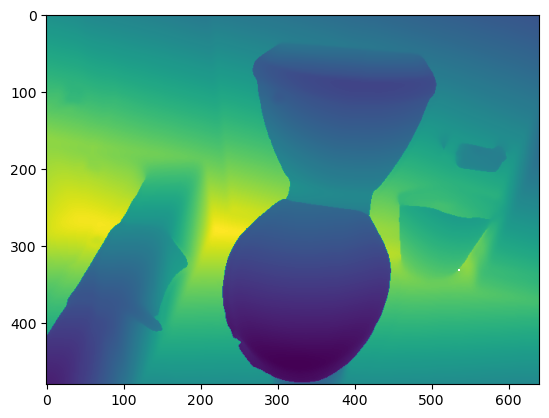

In [4]:
# Get result
ans = scene.cast_rays(rays)

primitive_ids = ans['primitive_ids'].numpy()
primitive_uvs = ans['primitive_uvs'].numpy()


plt.imshow(ans['t_hit'].numpy())
plt.show()

In [44]:
# Select the closest vertex for each valid face in the projected mesh
valid_mask = primitive_ids != scene.INVALID_ID

# https://stackoverflow.com/questions/45212949/vertex-of-a-3d-triangle-that-is-closest-to-a-point-given-barycentric-parameter-o
w_coords = (1 - primitive_uvs[:, :, 0][valid_mask] - primitive_uvs[:, :, 1][valid_mask])
barycentric_coords = np.concatenate((w_coords[:, None], primitive_uvs[valid_mask]), axis=-1)

selected_vertex_idx = np.argmax(barycentric_coords, axis=-1)

contained_mesh_triangles = mesh_triangles[primitive_ids[valid_mask]]
closest_mesh_vertices = contained_mesh_triangles[range(len(barycentric_coords)), selected_vertex_idx]

In [107]:
# Map mesh vertices to semantic label
labels = class_id_faces[closest_mesh_vertices]
# Remap to [0 ; num_labels - 1]
labels = dataset.val_dataset._remap_labels(torch.tensor(labels))

# Visualize back-projection
image = torch.ones((480, 640), dtype=torch.long) * -1
image[valid_mask] = labels


# NN interpolation at invalid pixels          
nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
    image==-1, return_distances=False, return_indices=True)    

image = image[nearest_neighbor].numpy()

# to rgb
image = np.array(CLASS_COLORS)[image].astype(np.uint8)

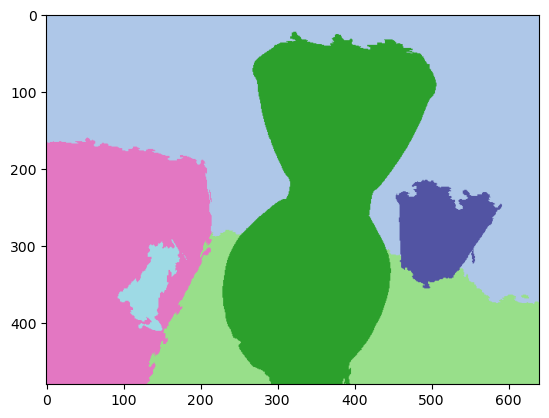

In [7]:
# plt.imshow(image)
im = np.asarray(Image.open("/scratch-shared/fsun/data/scannet/scans/scene0664_01/ViT_masks_refined/Deepset_3D/0.png"))
plt.imshow(np.array(CLASS_COLORS)[im].astype(np.uint8))

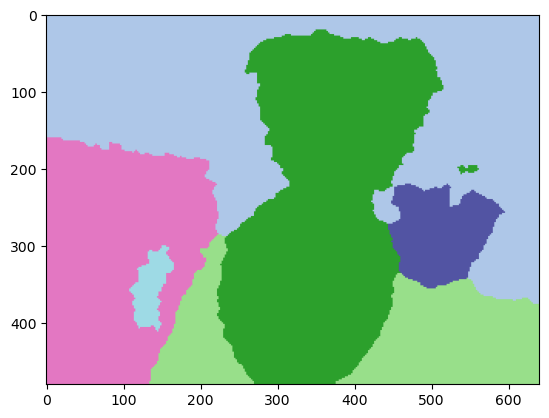

In [12]:
im = np.asarray(Image.open("/scratch-shared/fsun/data/scannet/scans/scene0664_01/ViT_masks_refined/0.png"))
plt.imshow(np.array(CLASS_COLORS)[im].astype(np.uint8))

In [12]:
s = "\textbf{87.4} & 92.0 & 72.0 & 84.5 & 81.8 & 79.4 & \textbf{81.3} & 72.4 & 65.8 & 77.4 & \textbf{52.1} & \textbf{66.2} & 68.8 & \textbf{80.1} & 78.9 & 78.1 & 86.9 & 69.1 & 85.5 & 60.3"
s = s.replace('\textbf{', '').replace('}', '')
np.mean([float(x) for x in s.split(" & ")])

75.99999999999999